In [1]:
!pip install scikit-posthocs

In [3]:
import os
import glob
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torchvision.transforms as T


from scipy import stats
from scipy.stats import ttest_rel, friedmanchisquare, rankdata
from scikit_posthocs import posthoc_nemenyi

In [4]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Dataset Preparation

In [5]:
class NestedImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        
        class_names = sorted([d for d in os.listdir(root_dir) 
                            if os.path.isdir(os.path.join(root_dir, d))])
        self.class_to_idx = {cls: idx for idx, cls in enumerate(class_names)}
        self.idx_to_class = {idx: cls for cls, idx in self.class_to_idx.items()}
        
        for class_name in class_names:
            class_folder = os.path.join(root_dir, class_name)
            if os.path.isdir(class_folder):
                for img_path in glob.glob(os.path.join(class_folder, '**', '*.*'), recursive=True):
                    if img_path.lower().endswith(('.jpg', '.jpeg', '.png')): 
                        self.image_paths.append(img_path)
                        self.labels.append(self.class_to_idx[class_name])
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
        
        return image, label


# SSL Augmentation Transforms

In [6]:
class SSLTransform:
    """Base SSL augmentation transforms"""
    def __init__(self, image_size=224):
        self.image_size = image_size
        
    def get_simclr_transform(self):
        """SimCLR augmentations - accepts PIL Image and returns tensor"""
        return transforms.Compose([
            transforms.RandomResizedCrop(size=self.image_size, scale=(0.2, 1.0)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomApply([
                transforms.ColorJitter(brightness=0.4, contrast=0.4, 
                                     saturation=0.4, hue=0.1)
            ], p=0.8),
            transforms.RandomGrayscale(p=0.2),
            transforms.RandomApply([T.GaussianBlur(kernel_size=23)], p=0.1),
            transforms.ToTensor(),
        ])
    
    def get_byol_transform(self):
        """BYOL augmentations - accepts PIL Image and returns tensor"""
        return transforms.Compose([
            transforms.RandomResizedCrop(size=self.image_size, scale=(0.2, 1.0)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomApply([
                transforms.ColorJitter(brightness=0.4, contrast=0.4, 
                                     saturation=0.4, hue=0.1)
            ], p=0.8),
            transforms.RandomGrayscale(p=0.2),
            transforms.RandomApply([T.GaussianBlur(kernel_size=23)], p=0.5),
            transforms.ToTensor(),
        ])
    
    def get_barlow_transform(self):
        """Barlow Twins augmentations - accepts PIL Image and returns tensor"""
        return transforms.Compose([
            transforms.RandomResizedCrop(size=self.image_size, scale=(0.2, 1.0)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomApply([
                transforms.ColorJitter(brightness=0.4, contrast=0.4, 
                                     saturation=0.4, hue=0.1)
            ], p=0.8),
            transforms.ToTensor(),
        ])
    
    def get_simclr_transform_no_color_jitter(self):
        """SimCLR without color jitter (for ablation)"""
        return transforms.Compose([
            transforms.RandomResizedCrop(size=self.image_size, scale=(0.2, 1.0)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomGrayscale(p=0.2),
            transforms.RandomApply([T.GaussianBlur(kernel_size=23)], p=0.1),
            transforms.ToTensor(),
        ])
    
    def get_byol_transform_no_blur(self):
        """BYOL without Gaussian blur (for ablation)"""
        return transforms.Compose([
            transforms.RandomResizedCrop(size=self.image_size, scale=(0.2, 1.0)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomApply([
                transforms.ColorJitter(brightness=0.4, contrast=0.4, 
                                     saturation=0.4, hue=0.1)
            ], p=0.8),
            transforms.RandomGrayscale(p=0.2),
            transforms.ToTensor(),
        ])
    
    def get_barlow_transform_no_color_jitter(self):
        """Barlow Twins without color jitter (for ablation)"""
        return transforms.Compose([
            transforms.RandomResizedCrop(size=self.image_size, scale=(0.2, 1.0)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.ToTensor(),
        ])

# SSL Model Architectures

In [7]:
class ProjectionHead(nn.Module):
    """Projection head for SSL methods"""
    def __init__(self, in_dim=512, hidden_dim=512, out_dim=128, num_layers=2):
        super().__init__()
        layers = []
        
        # Input layer
        layers.append(nn.Linear(in_dim, hidden_dim))
        layers.append(nn.BatchNorm1d(hidden_dim))
        layers.append(nn.ReLU(inplace=True))
        
        # Hidden layers (if more than 2 layers)
        for _ in range(num_layers - 2):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.BatchNorm1d(hidden_dim))
            layers.append(nn.ReLU(inplace=True))
        
        # Output layer
        layers.append(nn.Linear(hidden_dim, out_dim))
        
        self.net = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.net(x)

class SimCLR(nn.Module):
    """SimCLR model"""
    def __init__(self, backbone='resnet18', projection_dim=128, 
                 projection_layers=2, temperature=0.5):
        super().__init__()
        self.temperature = temperature
        
        # Backbone
        if backbone == 'resnet18':
            self.encoder = models.resnet18(pretrained=False)
            self.encoder.fc = nn.Identity()
            in_features = 512
        elif backbone == 'resnet50':
            self.encoder = models.resnet50(pretrained=False)
            self.encoder.fc = nn.Identity()
            in_features = 2048
            
        # Projection head
        self.projector = ProjectionHead(
            in_dim=in_features,
            hidden_dim=512,
            out_dim=projection_dim,
            num_layers=projection_layers
        )
        
    def forward(self, x1, x2):
        # Get representations
        h1 = self.encoder(x1)
        h2 = self.encoder(x2)
        
        # Project to latent space
        z1 = self.projector(h1)
        z2 = self.projector(h2)
        
        return z1, z2
    
    def compute_loss(self, z1, z2):
        """NT-Xent loss"""
        batch_size = z1.shape[0]
        
        # Normalize
        z1 = F.normalize(z1, dim=1)
        z2 = F.normalize(z2, dim=1)
        
        # Concatenate representations
        representations = torch.cat([z1, z2], dim=0)
        
        # Compute similarity matrix
        similarity_matrix = torch.matmul(representations, representations.T)
        
        # Create labels for positive pairs
        labels = torch.arange(batch_size, device=z1.device)
        labels = torch.cat([labels + batch_size, labels], dim=0)
        
        # Mask self-similarity
        mask = torch.eye(2 * batch_size, device=z1.device, dtype=torch.bool)
        similarity_matrix[mask] = -float('inf')
        
        # Compute logits and labels
        logits = similarity_matrix / self.temperature
        loss = F.cross_entropy(logits, labels)
        
        return loss
    
    def get_representation(self, x):
        """Get representation without projection"""
        return self.encoder(x)

class BYOL(nn.Module):
    """BYOL model"""
    def __init__(self, backbone='resnet18', projection_dim=256, 
                 hidden_dim=512, projection_layers=2, moving_average=0.99):
        super().__init__()
        self.moving_average = moving_average
        
        # Online network
        if backbone == 'resnet18':
            self.online_encoder = models.resnet18(pretrained=False)
            self.online_encoder.fc = nn.Identity()
            in_features = 512
        elif backbone == 'resnet50':
            self.online_encoder = models.resnet50(pretrained=False)
            self.online_encoder.fc = nn.Identity()
            in_features = 2048
        else:
            raise ValueError(f"Unsupported backbone: {backbone}")
            
        # Target network (with no grad)
        self.target_encoder = models.__dict__[backbone](pretrained=False)
        self.target_encoder.fc = nn.Identity()
        
        # Projection heads
        self.online_projector = ProjectionHead(
            in_dim=in_features,
            hidden_dim=hidden_dim,
            out_dim=projection_dim,
            num_layers=projection_layers
        )
        
        # Target projector - MUST BE DEFINED BEFORE INIT_TARGET_NETWORK
        self.target_projector = ProjectionHead(
            in_dim=in_features,
            hidden_dim=hidden_dim,
            out_dim=projection_dim,
            num_layers=projection_layers
        )
        
        # Predictor (only for online network)
        self.online_predictor = nn.Sequential(
            nn.Linear(projection_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim, projection_dim)
        )
        
        # Initialize target network as copy of online
        self._init_target_network()
    
    def _init_target_network(self):
        """Initialize target network with online network weights"""
        for param_online, param_target in zip(self.online_encoder.parameters(),
                                            self.target_encoder.parameters()):
            param_target.data.copy_(param_online.data)
            param_target.requires_grad = False
            
        for param_online, param_target in zip(self.online_projector.parameters(),
                                            self.target_projector.parameters()):
            param_target.data.copy_(param_online.data)
            param_target.requires_grad = False
    
    @torch.no_grad()
    def update_target_network(self):
        """Update target network with exponential moving average"""
        for param_online, param_target in zip(self.online_encoder.parameters(),
                                            self.target_encoder.parameters()):
            param_target.data = self.moving_average * param_target.data + \
                              (1 - self.moving_average) * param_online.data
            
        for param_online, param_target in zip(self.online_projector.parameters(),
                                            self.target_projector.parameters()):
            param_target.data = self.moving_average * param_target.data + \
                              (1 - self.moving_average) * param_online.data
    
    def forward(self, x1, x2):
        # Online network
        online_proj_one = self.online_projector(self.online_encoder(x1))
        online_proj_two = self.online_projector(self.online_encoder(x2))
        
        online_pred_one = self.online_predictor(online_proj_one)
        online_pred_two = self.online_predictor(online_proj_two)
        
        # Target network (no gradient)
        with torch.no_grad():
            target_proj_one = self.target_projector(self.target_encoder(x1))
            target_proj_two = self.target_projector(self.target_encoder(x2))
            
        return (online_pred_one, online_pred_two), (target_proj_one, target_proj_two)
    
    def compute_loss(self, online_preds, target_projs):
        """BYOL loss - MSE between normalized predictions and targets"""
        online_pred_one, online_pred_two = online_preds
        target_proj_one, target_proj_two = target_projs
        
        # Normalize
        online_pred_one = F.normalize(online_pred_one, dim=1)
        online_pred_two = F.normalize(online_pred_two, dim=1)
        target_proj_one = F.normalize(target_proj_one, dim=1)
        target_proj_two = F.normalize(target_proj_two, dim=1)
        
        # Compute loss
        loss_one = F.mse_loss(online_pred_one, target_proj_two)
        loss_two = F.mse_loss(online_pred_two, target_proj_one)
        
        return (loss_one + loss_two) / 2
    
    def get_representation(self, x):
        """Get representation from online encoder"""
        return self.online_encoder(x)

class BarlowTwins(nn.Module):
    """Barlow Twins model"""
    def __init__(self, backbone='resnet18', projection_dim=512, 
                 projection_layers=2, lambda_param=5e-3):
        super().__init__()
        self.lambda_param = lambda_param
        
        # Backbone
        if backbone == 'resnet18':
            self.encoder = models.resnet18(pretrained=False)
            self.encoder.fc = nn.Identity()
            in_features = 512
        elif backbone == 'resnet50':
            self.encoder = models.resnet50(pretrained=False)
            self.encoder.fc = nn.Identity()
            in_features = 2048
            
        # Projection head
        self.projector = ProjectionHead(
            in_dim=in_features,
            hidden_dim=512,
            out_dim=projection_dim,
            num_layers=projection_layers
        )
        
        # Batch normalization for the projector
        self.bn = nn.BatchNorm1d(projection_dim, affine=False)
        
    def forward(self, x1, x2):
        # Get representations
        y1 = self.encoder(x1)
        y2 = self.encoder(x2)
        
        # Project
        z1 = self.projector(y1)
        z2 = self.projector(y2)
        
        return z1, z2
    
    def compute_loss(self, z1, z2):
        """Barlow Twins loss"""
        batch_size = z1.shape[0]
        
        # Normalize along batch dimension
        z1_norm = (z1 - z1.mean(0)) / (z1.std(0) + 1e-6)
        z2_norm = (z2 - z2.mean(0)) / (z2.std(0) + 1e-6)
        
        # Cross-correlation matrix
        c = torch.matmul(z1_norm.T, z2_norm) / batch_size
        
        # Loss
        on_diag = torch.diagonal(c).add_(-1).pow_(2).sum()
        off_diag = c.flatten()[1:].view(c.shape[0]-1, c.shape[0]+1)[:, :-1].pow_(2).sum()
        
        loss = on_diag + self.lambda_param * off_diag
        
        return loss
    
    def get_representation(self, x):
        """Get representation without projection"""
        return self.encoder(x)

# SSL Trainer

In [8]:
class SSLTrainer:
    def __init__(self, model, train_loader, val_loader=None, 
                 device='cuda', lr=1e-3, weight_decay=1e-4):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device
        self.optimizer = optim.AdamW(model.parameters(), lr=lr, 
                                     weight_decay=weight_decay)
        self.scheduler = optim.lr_scheduler.CosineAnnealingLR(
            self.optimizer, T_max=len(train_loader), eta_min=1e-6
        )
        
    def train_epoch(self, epoch):
        self.model.train()
        total_loss = 0
        
        for batch_idx, (images, _) in enumerate(tqdm(self.train_loader, 
                                                     desc=f'Epoch {epoch}')):
            images = torch.cat(images, dim=0).to(self.device)
            batch_size = images.shape[0] // 2
            
            x1 = images[:batch_size]
            x2 = images[batch_size:]
            
            # Forward pass
            z1, z2 = self.model(x1, x2)
            loss = self.model.compute_loss(z1, z2)
            
            # Backward pass
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            self.scheduler.step()
            
            # Update target network if BYOL
            if hasattr(self.model, 'update_target_network'):
                self.model.update_target_network()
            
            total_loss += loss.item()
            
        return total_loss / len(self.train_loader)
    
    def train(self, num_epochs):
        losses = []
        for epoch in range(1, num_epochs + 1):
            loss = self.train_epoch(epoch)
            losses.append(loss)
            print(f'Epoch {epoch}: Loss = {loss:.4f}')
        return losses

# Linear Evaluation

In [9]:
class LinearEvaluator:
    def __init__(self, ssl_model, train_loader, test_loader, 
                 device='cuda', label_fraction=1.0):
        self.ssl_model = ssl_model
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.device = device
        self.label_fraction = label_fraction
        
        # Freeze SSL model
        self.ssl_model.eval()
        for param in self.ssl_model.parameters():
            param.requires_grad = False
            
        # Get feature dimension
        with torch.no_grad():
            sample, _ = next(iter(train_loader))
            sample = sample[0].unsqueeze(0).to(device)
            features = self.ssl_model.get_representation(sample)
            feature_dim = features.shape[1]
        
        # Create linear classifier
        self.classifier = nn.Linear(feature_dim, 
                                   len(train_loader.dataset.class_to_idx)).to(device)
        
    def extract_features(self, data_loader):
        """Extract features from SSL model"""
        features, labels = [], []
        with torch.no_grad():
            for images, targets in data_loader:
                images = images.to(self.device)
                feats = self.ssl_model.get_representation(images)
                features.append(feats.cpu())
                labels.append(targets)
        
        return torch.cat(features, dim=0), torch.cat(labels, dim=0)
    
    def train_classifier(self, num_epochs=100, lr=1e-3):
        """Train linear classifier on frozen features"""
        # Extract features
        train_features, train_labels = self.extract_features(self.train_loader)
        
        # Apply label fraction
        if self.label_fraction < 1.0:
            indices = np.arange(len(train_features))
            selected_idx = np.random.choice(
                indices, 
                size=int(len(indices) * self.label_fraction),
                replace=False
            )
            train_features = train_features[selected_idx]
            train_labels = train_labels[selected_idx]
        
        # Create dataset and loader
        train_dataset = torch.utils.data.TensorDataset(train_features, train_labels)
        train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
        
        # Train classifier
        optimizer = optim.AdamW(self.classifier.parameters(), lr=lr)
        criterion = nn.CrossEntropyLoss()
        
        self.classifier.train()
        for epoch in range(num_epochs):
            total_loss, total_correct = 0, 0
            
            for feats, labels in train_loader:
                feats, labels = feats.to(self.device), labels.to(self.device)
                
                optimizer.zero_grad()
                outputs = self.classifier(feats)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                
                total_loss += loss.item()
                _, predicted = outputs.max(1)
                total_correct += predicted.eq(labels).sum().item()
            
            if (epoch + 1) % 20 == 0:
                acc = 100. * total_correct / len(train_dataset)
                print(f'Epoch {epoch+1}: Loss={total_loss/len(train_loader):.4f}, '
                      f'Acc={acc:.2f}%')
    
    def evaluate(self):
        """Evaluate classifier"""
        self.classifier.eval()
        test_features, test_labels = self.extract_features(self.test_loader)
        test_features = test_features.to(self.device)
        test_labels = test_labels.to(self.device)
        
        with torch.no_grad():
            outputs = self.classifier(test_features)
            _, predicted = outputs.max(1)
            accuracy = predicted.eq(test_labels).sum().item() / len(test_labels)
            
        return accuracy

# Experiment Runner

In [10]:
class SSLExperiment:
    def __init__(self, root_dir, image_size=224, batch_size=64, 
                 device='cuda' if torch.cuda.is_available() else 'cpu'):
        self.root_dir = root_dir
        self.image_size = image_size
        self.batch_size = batch_size
        self.device = device
        
        # Load dataset and compute stats
        self.load_dataset()
        self.compute_stats()
        
        # SSL transforms
        self.ssl_transform = SSLTransform(image_size)
        
    def load_dataset(self):
        """Load and split dataset"""
        # Base transform for computing stats
        temp_transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor()
        ])
        
        self.full_dataset = NestedImageDataset(
            root_dir=self.root_dir,
            transform=temp_transform
        )
        
        # Split indices
        indices = list(range(len(self.full_dataset)))
        labels = [self.full_dataset.labels[i] for i in indices]
        
        self.train_idx, self.test_idx = train_test_split(
            indices, test_size=0.2, random_state=42, stratify=labels
        )
        
        print(f"Dataset loaded: {len(self.full_dataset)} samples")
        print(f"Train: {len(self.train_idx)}, Test: {len(self.test_idx)}")
        print(f"Classes: {list(self.full_dataset.class_to_idx.keys())}")
    
    def compute_stats(self):
        """Compute dataset statistics"""
        temp_loader = DataLoader(self.full_dataset, batch_size=32, 
                                shuffle=False, num_workers=2)
        
        mean = torch.zeros(3)
        std = torch.zeros(3)
        total_images = 0
        
        for images, _ in tqdm(temp_loader, desc="Computing stats"):
            batch_size = images.size(0)
            images = images.view(batch_size, images.size(1), -1)
            mean += images.mean(2).sum(0)
            std += images.std(2).sum(0)
            total_images += batch_size
        
        self.mean = mean / total_images
        self.std = std / total_images
        
        print(f"Mean: {self.mean.tolist()}")
        print(f"Std: {self.std.tolist()}")
    
    def create_ssl_dataloader(self, ssl_method, indices, ablation=None):
        """Create SSL dataloader with optional ablation"""
        # Base transforms for different methods
        if ssl_method == 'simclr':
            transform = self.ssl_transform.get_simclr_transform()
            if ablation == 'no_color_jitter':
                # Remove color jitter augmentation
                transform = self.ssl_transform.get_simclr_transform_no_color_jitter()
            elif ablation == 'deep_projection':
                # This is handled in model creation, not in transforms
                transform = self.ssl_transform.get_simclr_transform()
                
        elif ssl_method == 'byol':
            transform = self.ssl_transform.get_byol_transform()
            if ablation == 'shallow_projection':
                # This is handled in model creation, not in transforms
                transform = self.ssl_transform.get_byol_transform()
            elif ablation == 'no_blur':
                transform = self.ssl_transform.get_byol_transform_no_blur()
                    
        elif ssl_method == 'barlow':
            transform = self.ssl_transform.get_barlow_transform()
            if ablation == 'high_lambda':
                # This is handled in model creation, not in transforms
                transform = self.ssl_transform.get_barlow_transform()
            elif ablation == 'no_color_jitter':
                transform = self.ssl_transform.get_barlow_transform_no_color_jitter()
            elif ablation == 'small_batch':
                # Batch size handled separately below
                transform = self.ssl_transform.get_barlow_transform()
        
        # Create dataset with TwoView transform
        class TwoViewDataset(Dataset):
            def __init__(self, base_dataset, indices, transform):
                self.base_dataset = base_dataset
                self.indices = indices
                self.transform = transform
                
                # Store the image paths and labels from the base dataset
                self.image_paths = [base_dataset.image_paths[i] for i in indices]
                self.labels = [base_dataset.labels[i] for i in indices]
                
                # Add class_to_idx attribute
                self.class_to_idx = base_dataset.class_to_idx
                self.idx_to_class = base_dataset.idx_to_class
                
            def __len__(self):
                return len(self.indices)
            
            def __getitem__(self, idx):
                # Load image fresh from disk as PIL Image
                img_path = self.image_paths[idx]
                label = self.labels[idx]
                image = Image.open(img_path).convert("RGB")
                
                # Apply transform to the PIL image (returns tensor)
                return [self.transform(image), self.transform(image)], label
        
        # Create dataset
        dataset = TwoViewDataset(self.full_dataset, indices, transform)
        
        # Handle batch size ablation
        batch_size = self.batch_size
        if ablation == 'small_batch':
            batch_size = 32  # Smaller batch for ablation
            
        loader = DataLoader(dataset, batch_size=batch_size, 
                          shuffle=True, num_workers=2, pin_memory=True)
        
        return loader
    
    def create_eval_dataloader(self, indices):
        """Create evaluation dataloader"""
        transform = transforms.Compose([
            transforms.Resize((self.image_size, self.image_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=self.mean.tolist(), std=self.std.tolist())
        ])
        
        class EvalDataset(Dataset):
            def __init__(self, base_dataset, indices, transform):
                self.base_dataset = base_dataset
                self.indices = indices
                self.transform = transform
                
                # Store the image paths and labels from the base dataset
                self.image_paths = [base_dataset.image_paths[i] for i in indices]
                self.labels = [base_dataset.labels[i] for i in indices]
                
                # Add class_to_idx attribute
                self.class_to_idx = base_dataset.class_to_idx
                self.idx_to_class = base_dataset.idx_to_class
                
            def __len__(self):
                return len(self.indices)
            
            def __getitem__(self, idx):
                # Load image fresh from disk as PIL Image
                img_path = self.image_paths[idx]
                label = self.labels[idx]
                image = Image.open(img_path).convert("RGB")
                
                # Apply transform to the PIL image
                return self.transform(image), label
        
        dataset = EvalDataset(self.full_dataset, indices, transform)
        loader = DataLoader(dataset, batch_size=64, shuffle=False, 
                          num_workers=2, pin_memory=True)
        
        return loader
    
    def run_single_experiment(self, ssl_method, ablation=None, 
                            pretrain_epochs=50, num_seeds=3):
        """Run single SSL experiment with given method and ablation"""
        results = {}
        
        for seed in range(num_seeds):
            set_seed(42 + seed)
            print(f"\n{'='*50}")
            print(f"Running {ssl_method.upper()} - {ablation if ablation else 'Baseline'} (Seed {seed})")
            print('='*50)
            
            # Create dataloaders
            train_loader = self.create_ssl_dataloader(ssl_method, self.train_idx, ablation)
            eval_train_loader = self.create_eval_dataloader(self.train_idx)
            eval_test_loader = self.create_eval_dataloader(self.test_idx)
            
            # Create model with ablation parameters
            if ssl_method == 'simclr':
                model = SimCLR(backbone='resnet18', projection_layers=2)
                if ablation == 'deep_projection':
                    model = SimCLR(backbone='resnet18', projection_layers=4)
                    
            elif ssl_method == 'byol':
                model = BYOL(backbone='resnet18', projection_layers=2)
                if ablation == 'shallow_projection':
                    model = BYOL(backbone='resnet18', projection_layers=1)
                    
            elif ssl_method == 'barlow':
                model = BarlowTwins(backbone='resnet18', projection_layers=2)
                if ablation == 'high_lambda':
                    model = BarlowTwins(backbone='resnet18', lambda_param=5e-2)
            
            # Train SSL model
            trainer = SSLTrainer(model, train_loader, device=self.device, lr=1e-3)
            losses = trainer.train(pretrain_epochs)
            
            # Linear evaluation with different label fractions
            label_fractions = [1.0, 0.1, 0.01]  # 100%, 10%, 1%
            accuracies = {}
            
            for fraction in label_fractions:
                print(f"\nLinear evaluation with {fraction*100}% labels:")
                
                evaluator = LinearEvaluator(
                    model, eval_train_loader, eval_test_loader,
                    device=self.device, label_fraction=fraction
                )
                evaluator.train_classifier(num_epochs=100)
                acc = evaluator.evaluate()
                accuracies[f'label_{int(fraction*100)}%'] = acc
                print(f"Test Accuracy: {acc*100:.2f}%")
            
            # Store results
            results[seed] = {
                'losses': losses,
                'accuracies': accuracies,
                'final_loss': losses[-1]
            }
        
        return results
    
    def run_all_experiments(self):
        """Run all SSL methods with ablations"""
        ssl_methods = ['simclr', 'byol', 'barlow']
        ablations = {
            'simclr': ['no_color_jitter', 'deep_projection'],
            'byol': ['shallow_projection'],
            'barlow': ['high_lambda', 'small_batch']
        }
        
        all_results = {}
        
        for method in ssl_methods:
            print(f"\n{'#'*60}")
            print(f"Running {method.upper()} experiments")
            print('#'*60)
            
            # Run baseline
            baseline_results = self.run_single_experiment(method, ablation=None)
            
            # Run ablations
            method_results = {'baseline': baseline_results}
            
            for ablation in ablations[method]:
                ablation_results = self.run_single_experiment(method, ablation=ablation)
                method_results[ablation] = ablation_results
            
            all_results[method] = method_results
        
        return all_results

# Statistical Analysis

In [11]:
class StatisticalAnalyzer:
    def __init__(self, results):
        self.results = results
    
    def compare_two_models(self, results1, results2, metric='label_100%'):
        """Paired t-test for two models"""
        accs1 = []
        accs2 = []
        
        for seed in results1.keys():
            if seed in results2:
                accs1.append(results1[seed]['accuracies'][metric])
                accs2.append(results2[seed]['accuracies'][metric])
        
        # Perform paired t-test
        t_stat, p_value = ttest_rel(accs1, accs2)
        
        return {
            't_statistic': t_stat,
            'p_value': p_value,
            'mean1': np.mean(accs1),
            'mean2': np.mean(accs2),
            'std1': np.std(accs1),
            'std2': np.std(accs2)
        }
    
    def compare_multiple_models(self, models_results, metric='label_100%'):
        """Friedman test with Nemenyi post-hoc for multiple models"""
        # Prepare data
        model_names = list(models_results.keys())
        n_models = len(model_names)
        n_seeds = len(next(iter(models_results.values())))
        
        # Create matrix of accuracies
        acc_matrix = np.zeros((n_seeds, n_models))
        
        for i, model_name in enumerate(model_names):
            for j in range(n_seeds):
                acc_matrix[j, i] = models_results[model_name][j]['accuracies'][metric]
        
        # Friedman test
        friedman_stat, friedman_p = friedmanchisquare(*[acc_matrix[:, i] for i in range(n_models)])
        
        # Nemenyi post-hoc test
        ranks = np.zeros((n_seeds, n_models))
        for i in range(n_seeds):
            ranks[i, :] = rankdata(-acc_matrix[i, :])  # Negative because higher is better
        
        mean_ranks = ranks.mean(axis=0)
        
        # Critical difference (CD) for Nemenyi test
        k = n_models
        N = n_seeds
        q_alpha = 2.343  # For alpha=0.05, k=3 (from Nemenyi table)
        cd = q_alpha * np.sqrt(k * (k + 1) / (6 * N))
        
        # Pairwise comparisons
        pairwise_p_values = {}
        for i in range(n_models):
            for j in range(i+1, n_models):
                diff = abs(mean_ranks[i] - mean_ranks[j])
                significant = diff > cd
                pairwise_p_values[f"{model_names[i]} vs {model_names[j]}"] = {
                    'rank_diff': diff,
                    'significant': significant,
                    'cd': cd
                }
        
        return {
            'friedman_statistic': friedman_stat,
            'friedman_p_value': friedman_p,
            'mean_ranks': dict(zip(model_names, mean_ranks)),
            'pairwise_comparisons': pairwise_p_values,
            'critical_difference': cd
        }
    
    def analyze_label_efficiency(self, method_results):
        """Analyze label efficiency across different fractions"""
        fractions = ['label_100%', 'label_10%', 'label_1%']
        efficiency = {}
        
        for config_name, config_results in method_results.items():
            efficiency[config_name] = {}
            for fraction in fractions:
                accs = [config_results[seed]['accuracies'][fraction] 
                       for seed in config_results.keys()]
                efficiency[config_name][fraction] = {
                    'mean': np.mean(accs),
                    'std': np.std(accs),
                    'relative_to_100%': np.mean(accs) / efficiency[config_name].get('label_100%', {}).get('mean', 1)
                }
        
        return efficiency
    
    def generate_report(self):
        """Generate comprehensive statistical report"""
        report = {}
        
        # 1. Compare each method's baseline with its ablation
        for method, method_results in self.results.items():
            baseline = method_results['baseline']
            report[method] = {}
            
            for ablation_name, ablation_results in method_results.items():
                if ablation_name != 'baseline':
                    comparison = self.compare_two_models(baseline, ablation_results)
                    report[method][f'baseline_vs_{ablation_name}'] = comparison
        
        # 2. Compare all SSL methods (baselines)
        ssl_baselines = {method: self.results[method]['baseline'] 
                        for method in self.results.keys()}
        ssl_comparison = self.compare_multiple_models(ssl_baselines)
        report['ssl_methods_comparison'] = ssl_comparison
        
        # 3. Label efficiency analysis
        for method, method_results in self.results.items():
            efficiency = self.analyze_label_efficiency(method_results)
            report[method]['label_efficiency'] = efficiency
        
        return report
    
    def plot_results(self):
        """Visualize results"""
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        
        # Plot 1: SSL method comparison (baselines)
        ax = axes[0, 0]
        methods = list(self.results.keys())
        accuracies = []
        
        for method in methods:
            baseline = self.results[method]['baseline']
            accs = [baseline[seed]['accuracies']['label_100%'] 
                   for seed in baseline.keys()]
            accuracies.append(accs)
        
        ax.boxplot(accuracies, labels=methods)
        ax.set_title('SSL Method Comparison (100% labels)')
        ax.set_ylabel('Accuracy')
        ax.grid(True, alpha=0.3)
        
        # Plot 2: Label efficiency for each method
        ax = axes[0, 1]
        fractions = ['100%', '10%', '1%']
        fraction_keys = ['label_100%', 'label_10%', 'label_1%']
        
        for method in methods:
            baseline = self.results[method]['baseline']
            means = []
            stds = []
            
            for key in fraction_keys:
                accs = [baseline[seed]['accuracies'][key] 
                       for seed in baseline.keys()]
                means.append(np.mean(accs))
                stds.append(np.std(accs))
            
            ax.errorbar(fractions, means, yerr=stds, marker='o', 
                       label=method, capsize=5)
        
        ax.set_title('Label Efficiency')
        ax.set_xlabel('Label Fraction')
        ax.set_ylabel('Accuracy')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Plot 3: Ablation effects for each method
        for idx, method in enumerate(methods):
            ax = axes[1, idx]
            
            configs = list(self.results[method].keys())
            means = []
            stds = []
            
            for config in configs:
                config_results = self.results[method][config]
                accs = [config_results[seed]['accuracies']['label_100%'] 
                       for seed in config_results.keys()]
                means.append(np.mean(accs))
                stds.append(np.std(accs))
            
            x = np.arange(len(configs))
            ax.bar(x, means, yerr=stds, capsize=5)
            ax.set_xticks(x)
            ax.set_xticklabels([c.replace('_', '\n') for c in configs], 
                             rotation=45, ha='right')
            ax.set_title(f'{method.upper()} Ablations')
            ax.set_ylabel('Accuracy')
            ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

# SIMCLR

RUNNING SIMCLR EXPERIMENTS
Using device: cuda
PyTorch version: 2.6.0+cu124
Dataset loaded: 375 samples
Train: 300, Test: 75
Classes: ['Akbar', 'Dilkash', 'urooj']


Computing stats: 100%|██████████| 12/12 [00:00<00:00, 13.71it/s]


Mean: [0.49219194054603577, 0.46283817291259766, 0.4575345516204834]
Std: [0.07509942352771759, 0.07036154717206955, 0.053037378937006]

############################################################
Running SIMCLR Baseline
############################################################

Running SIMCLR - Baseline (Seed 0)


Epoch 1: 100%|██████████| 5/5 [00:05<00:00,  1.09s/it]


Epoch 1: Loss = 4.5324


Epoch 2: 100%|██████████| 5/5 [00:05<00:00,  1.18s/it]


Epoch 2: Loss = 4.3998


Epoch 3: 100%|██████████| 5/5 [00:05<00:00,  1.13s/it]


Epoch 3: Loss = 4.4413


Epoch 4: 100%|██████████| 5/5 [00:04<00:00,  1.05it/s]


Epoch 4: Loss = 4.4204


Epoch 5: 100%|██████████| 5/5 [00:04<00:00,  1.00it/s]


Epoch 5: Loss = 4.5008


Epoch 6: 100%|██████████| 5/5 [00:04<00:00,  1.09it/s]


Epoch 6: Loss = 4.3682


Epoch 7: 100%|██████████| 5/5 [00:05<00:00,  1.11s/it]


Epoch 7: Loss = 4.4081


Epoch 8: 100%|██████████| 5/5 [00:05<00:00,  1.00s/it]


Epoch 8: Loss = 4.3812


Epoch 9: 100%|██████████| 5/5 [00:05<00:00,  1.09s/it]


Epoch 9: Loss = 4.3030


Epoch 10: 100%|██████████| 5/5 [00:05<00:00,  1.12s/it]


Epoch 10: Loss = 4.2703


Epoch 11: 100%|██████████| 5/5 [00:04<00:00,  1.02it/s]


Epoch 11: Loss = 4.3803


Epoch 12: 100%|██████████| 5/5 [00:05<00:00,  1.13s/it]


Epoch 12: Loss = 4.3440


Epoch 13: 100%|██████████| 5/5 [00:04<00:00,  1.15it/s]


Epoch 13: Loss = 4.3855


Epoch 14: 100%|██████████| 5/5 [00:05<00:00,  1.11s/it]


Epoch 14: Loss = 4.3739


Epoch 15: 100%|██████████| 5/5 [00:05<00:00,  1.06s/it]


Epoch 15: Loss = 4.3233


Epoch 16: 100%|██████████| 5/5 [00:05<00:00,  1.05s/it]


Epoch 16: Loss = 4.3113


Epoch 17: 100%|██████████| 5/5 [00:04<00:00,  1.04it/s]


Epoch 17: Loss = 4.3236


Epoch 18: 100%|██████████| 5/5 [00:05<00:00,  1.07s/it]


Epoch 18: Loss = 4.2721


Epoch 19: 100%|██████████| 5/5 [00:05<00:00,  1.19s/it]


Epoch 19: Loss = 4.2903


Epoch 20: 100%|██████████| 5/5 [00:04<00:00,  1.02it/s]


Epoch 20: Loss = 4.2667


Epoch 21: 100%|██████████| 5/5 [00:05<00:00,  1.16s/it]


Epoch 21: Loss = 4.3068


Epoch 22: 100%|██████████| 5/5 [00:07<00:00,  1.53s/it]


Epoch 22: Loss = 4.3390


Epoch 23: 100%|██████████| 5/5 [00:06<00:00,  1.38s/it]


Epoch 23: Loss = 4.6405


Epoch 24: 100%|██████████| 5/5 [00:05<00:00,  1.19s/it]


Epoch 24: Loss = 4.4799


Epoch 25: 100%|██████████| 5/5 [00:05<00:00,  1.20s/it]


Epoch 25: Loss = 4.3321


Epoch 26: 100%|██████████| 5/5 [00:05<00:00,  1.18s/it]


Epoch 26: Loss = 4.3403


Epoch 27: 100%|██████████| 5/5 [00:05<00:00,  1.12s/it]


Epoch 27: Loss = 4.3954


Epoch 28: 100%|██████████| 5/5 [00:05<00:00,  1.06s/it]


Epoch 28: Loss = 4.2969


Epoch 29: 100%|██████████| 5/5 [00:06<00:00,  1.26s/it]


Epoch 29: Loss = 4.4886


Epoch 30: 100%|██████████| 5/5 [00:05<00:00,  1.15s/it]


Epoch 30: Loss = 4.4550


Epoch 31: 100%|██████████| 5/5 [00:05<00:00,  1.13s/it]


Epoch 31: Loss = 4.4981


Epoch 32: 100%|██████████| 5/5 [00:06<00:00,  1.27s/it]


Epoch 32: Loss = 4.5026


Epoch 33: 100%|██████████| 5/5 [00:05<00:00,  1.13s/it]


Epoch 33: Loss = 4.4331


Epoch 34: 100%|██████████| 5/5 [00:06<00:00,  1.25s/it]


Epoch 34: Loss = 4.4187


Epoch 35: 100%|██████████| 5/5 [00:05<00:00,  1.11s/it]


Epoch 35: Loss = 4.4427


Epoch 36: 100%|██████████| 5/5 [00:05<00:00,  1.01s/it]


Epoch 36: Loss = 4.3423


Epoch 37: 100%|██████████| 5/5 [00:05<00:00,  1.12s/it]


Epoch 37: Loss = 4.3602


Epoch 38: 100%|██████████| 5/5 [00:06<00:00,  1.27s/it]


Epoch 38: Loss = 4.3017


Epoch 39: 100%|██████████| 5/5 [00:05<00:00,  1.06s/it]


Epoch 39: Loss = 4.3091


Epoch 40: 100%|██████████| 5/5 [00:04<00:00,  1.03it/s]


Epoch 40: Loss = 4.3046


Epoch 41: 100%|██████████| 5/5 [00:05<00:00,  1.05s/it]


Epoch 41: Loss = 4.2829


Epoch 42: 100%|██████████| 5/5 [00:04<00:00,  1.00it/s]


Epoch 42: Loss = 4.2342


Epoch 43: 100%|██████████| 5/5 [00:04<00:00,  1.01it/s]


Epoch 43: Loss = 4.2380


Epoch 44: 100%|██████████| 5/5 [00:05<00:00,  1.10s/it]


Epoch 44: Loss = 4.2210


Epoch 45: 100%|██████████| 5/5 [00:04<00:00,  1.02it/s]


Epoch 45: Loss = 4.2304


Epoch 46: 100%|██████████| 5/5 [00:04<00:00,  1.08it/s]


Epoch 46: Loss = 4.1321


Epoch 47: 100%|██████████| 5/5 [00:05<00:00,  1.12s/it]


Epoch 47: Loss = 4.1887


Epoch 48: 100%|██████████| 5/5 [00:05<00:00,  1.05s/it]


Epoch 48: Loss = 4.1994


Epoch 49: 100%|██████████| 5/5 [00:05<00:00,  1.04s/it]


Epoch 49: Loss = 4.2081


Epoch 50: 100%|██████████| 5/5 [00:04<00:00,  1.09it/s]

Epoch 50: Loss = 4.1229

Linear evaluation with 100.0% labels:


Epoch 20: Loss=0.7469, Acc=61.67%
Epoch 40: Loss=0.6220, Acc=69.67%
Epoch 60: Loss=0.6055, Acc=70.67%
Epoch 80: Loss=0.5446, Acc=74.67%
Epoch 100: Loss=0.5353, Acc=74.00%
Test Accuracy: 68.00%

Linear evaluation with 10.0% labels:
Epoch 20: Loss=0.8030, Acc=50.00%
Epoch 40: Loss=0.5590, Acc=73.33%
Epoch 60: Loss=0.4909, Acc=80.00%
Epoch 80: Loss=0.4541, Acc=80.00%
Epoch 100: Loss=0.4268, Acc=80.00%
Test Accuracy: 56.00%

Linear evaluation with 1.0% labels:
Epoch 20: Loss=0.0870, Acc=100.00%
Epoch 40: Loss=0.0368, Acc=100.00%
Epoch 60: Loss=0.0172, Acc=100.00%
Epoch 80: Loss=0.0107, Acc=100.00%
Epoch 100: Loss=0.0082, Acc=100.00%
Test Accuracy: 57.33%

Running SIMCLR - Baseline (Seed 1)


Epoch 1: 100%|██████████| 5/5 [00:04<00:00,  1.04it/s]


Epoch 1: Loss = 4.5896


Epoch 2: 100%|██████████| 5/5 [00:05<00:00,  1.01s/it]


Epoch 2: Loss = 4.4107


Epoch 3: 100%|██████████| 5/5 [00:04<00:00,  1.05it/s]


Epoch 3: Loss = 4.4692


Epoch 4: 100%|██████████| 5/5 [00:05<00:00,  1.09s/it]


Epoch 4: Loss = 4.4369


Epoch 5: 100%|██████████| 5/5 [00:05<00:00,  1.07s/it]


Epoch 5: Loss = 4.4231


Epoch 6: 100%|██████████| 5/5 [00:05<00:00,  1.16s/it]


Epoch 6: Loss = 4.3862


Epoch 7: 100%|██████████| 5/5 [00:05<00:00,  1.09s/it]


Epoch 7: Loss = 4.4300


Epoch 8: 100%|██████████| 5/5 [00:04<00:00,  1.01it/s]


Epoch 8: Loss = 4.3258


Epoch 9: 100%|██████████| 5/5 [00:05<00:00,  1.16s/it]


Epoch 9: Loss = 4.3534


Epoch 10: 100%|██████████| 5/5 [00:05<00:00,  1.11s/it]


Epoch 10: Loss = 4.3770


Epoch 11: 100%|██████████| 5/5 [00:05<00:00,  1.06s/it]


Epoch 11: Loss = 4.3626


Epoch 12: 100%|██████████| 5/5 [00:05<00:00,  1.10s/it]


Epoch 12: Loss = 4.4008


Epoch 13: 100%|██████████| 5/5 [00:05<00:00,  1.13s/it]


Epoch 13: Loss = 4.3479


Epoch 14: 100%|██████████| 5/5 [00:05<00:00,  1.05s/it]


Epoch 14: Loss = 4.2724


Epoch 15: 100%|██████████| 5/5 [00:04<00:00,  1.16it/s]


Epoch 15: Loss = 4.3912


Epoch 16: 100%|██████████| 5/5 [00:06<00:00,  1.28s/it]


Epoch 16: Loss = 4.3144


Epoch 17: 100%|██████████| 5/5 [00:04<00:00,  1.09it/s]


Epoch 17: Loss = 4.4636


Epoch 18: 100%|██████████| 5/5 [00:04<00:00,  1.00it/s]


Epoch 18: Loss = 4.4231


Epoch 19: 100%|██████████| 5/5 [00:05<00:00,  1.06s/it]


Epoch 19: Loss = 4.2993


Epoch 20: 100%|██████████| 5/5 [00:04<00:00,  1.00it/s]


Epoch 20: Loss = 4.2738


Epoch 21: 100%|██████████| 5/5 [00:04<00:00,  1.05it/s]


Epoch 21: Loss = 4.2968


Epoch 22: 100%|██████████| 5/5 [00:06<00:00,  1.25s/it]


Epoch 22: Loss = 4.3233


Epoch 23: 100%|██████████| 5/5 [00:05<00:00,  1.12s/it]


Epoch 23: Loss = 4.3476


Epoch 24: 100%|██████████| 5/5 [00:04<00:00,  1.03it/s]


Epoch 24: Loss = 4.2685


Epoch 25: 100%|██████████| 5/5 [00:04<00:00,  1.01it/s]


Epoch 25: Loss = 4.2195


Epoch 26: 100%|██████████| 5/5 [00:05<00:00,  1.18s/it]


Epoch 26: Loss = 4.2170


Epoch 27: 100%|██████████| 5/5 [00:04<00:00,  1.10it/s]


Epoch 27: Loss = 4.2086


Epoch 28: 100%|██████████| 5/5 [00:05<00:00,  1.17s/it]


Epoch 28: Loss = 4.2141


Epoch 29: 100%|██████████| 5/5 [00:05<00:00,  1.08s/it]


Epoch 29: Loss = 4.2080


Epoch 30: 100%|██████████| 5/5 [00:05<00:00,  1.07s/it]


Epoch 30: Loss = 4.1803


Epoch 31: 100%|██████████| 5/5 [00:05<00:00,  1.08s/it]


Epoch 31: Loss = 4.1662


Epoch 32: 100%|██████████| 5/5 [00:04<00:00,  1.01it/s]


Epoch 32: Loss = 4.1656


Epoch 33: 100%|██████████| 5/5 [00:05<00:00,  1.08s/it]


Epoch 33: Loss = 4.0774


Epoch 34: 100%|██████████| 5/5 [00:05<00:00,  1.08s/it]


Epoch 34: Loss = 4.1308


Epoch 35: 100%|██████████| 5/5 [00:05<00:00,  1.03s/it]


Epoch 35: Loss = 4.1805


Epoch 36: 100%|██████████| 5/5 [00:05<00:00,  1.14s/it]


Epoch 36: Loss = 4.1089


Epoch 37: 100%|██████████| 5/5 [00:04<00:00,  1.04it/s]


Epoch 37: Loss = 4.1251


Epoch 38: 100%|██████████| 5/5 [00:05<00:00,  1.09s/it]


Epoch 38: Loss = 4.1329


Epoch 39: 100%|██████████| 5/5 [00:05<00:00,  1.05s/it]


Epoch 39: Loss = 4.1596


Epoch 40: 100%|██████████| 5/5 [00:04<00:00,  1.02it/s]


Epoch 40: Loss = 4.1182


Epoch 41: 100%|██████████| 5/5 [00:05<00:00,  1.14s/it]


Epoch 41: Loss = 4.1928


Epoch 42: 100%|██████████| 5/5 [00:04<00:00,  1.07it/s]


Epoch 42: Loss = 4.1255


Epoch 43: 100%|██████████| 5/5 [00:05<00:00,  1.08s/it]


Epoch 43: Loss = 4.1731


Epoch 44: 100%|██████████| 5/5 [00:04<00:00,  1.02it/s]


Epoch 44: Loss = 4.2139


Epoch 45: 100%|██████████| 5/5 [00:05<00:00,  1.06s/it]


Epoch 45: Loss = 4.2970


Epoch 46: 100%|██████████| 5/5 [00:04<00:00,  1.08it/s]


Epoch 46: Loss = 4.2529


Epoch 47: 100%|██████████| 5/5 [00:05<00:00,  1.18s/it]


Epoch 47: Loss = 4.3291


Epoch 48: 100%|██████████| 5/5 [00:04<00:00,  1.12it/s]


Epoch 48: Loss = 4.2252


Epoch 49: 100%|██████████| 5/5 [00:04<00:00,  1.07it/s]


Epoch 49: Loss = 4.1492


Epoch 50: 100%|██████████| 5/5 [00:04<00:00,  1.00it/s]

Epoch 50: Loss = 4.1399

Linear evaluation with 100.0% labels:


Epoch 20: Loss=0.6487, Acc=66.00%
Epoch 40: Loss=0.5873, Acc=67.67%
Epoch 60: Loss=0.5338, Acc=73.00%
Epoch 80: Loss=0.4849, Acc=79.00%
Epoch 100: Loss=0.4614, Acc=80.67%
Test Accuracy: 76.00%

Linear evaluation with 10.0% labels:
Epoch 20: Loss=0.6389, Acc=66.67%
Epoch 40: Loss=0.5263, Acc=86.67%
Epoch 60: Loss=0.4686, Acc=83.33%
Epoch 80: Loss=0.4323, Acc=83.33%
Epoch 100: Loss=0.4018, Acc=86.67%
Test Accuracy: 69.33%

Linear evaluation with 1.0% labels:
Epoch 20: Loss=0.4318, Acc=66.67%
Epoch 40: Loss=0.2373, Acc=100.00%
Epoch 60: Loss=0.1482, Acc=100.00%
Epoch 80: Loss=0.1101, Acc=100.00%
Epoch 100: Loss=0.0862, Acc=100.00%
Test Accuracy: 57.33%

Running SIMCLR - Baseline (Seed 2)


Epoch 1: 100%|██████████| 5/5 [00:05<00:00,  1.17s/it]


Epoch 1: Loss = 4.5483


Epoch 2: 100%|██████████| 5/5 [00:05<00:00,  1.05s/it]


Epoch 2: Loss = 4.3134


Epoch 3: 100%|██████████| 5/5 [00:05<00:00,  1.01s/it]


Epoch 3: Loss = 4.5065


Epoch 4: 100%|██████████| 5/5 [00:05<00:00,  1.00s/it]


Epoch 4: Loss = 4.3675


Epoch 5: 100%|██████████| 5/5 [00:04<00:00,  1.09it/s]


Epoch 5: Loss = 4.3644


Epoch 6: 100%|██████████| 5/5 [00:05<00:00,  1.16s/it]


Epoch 6: Loss = 4.3026


Epoch 7: 100%|██████████| 5/5 [00:05<00:00,  1.19s/it]


Epoch 7: Loss = 4.3178


Epoch 8: 100%|██████████| 5/5 [00:05<00:00,  1.01s/it]


Epoch 8: Loss = 4.4748


Epoch 9: 100%|██████████| 5/5 [00:04<00:00,  1.03it/s]


Epoch 9: Loss = 4.5094


Epoch 10: 100%|██████████| 5/5 [00:04<00:00,  1.08it/s]


Epoch 10: Loss = 4.4749


Epoch 11: 100%|██████████| 5/5 [00:04<00:00,  1.02it/s]


Epoch 11: Loss = 4.3260


Epoch 12: 100%|██████████| 5/5 [00:04<00:00,  1.05it/s]


Epoch 12: Loss = 4.3513


Epoch 13: 100%|██████████| 5/5 [00:06<00:00,  1.22s/it]


Epoch 13: Loss = 4.3438


Epoch 14: 100%|██████████| 5/5 [00:05<00:00,  1.16s/it]


Epoch 14: Loss = 4.3160


Epoch 15: 100%|██████████| 5/5 [00:05<00:00,  1.06s/it]


Epoch 15: Loss = 4.3642


Epoch 16: 100%|██████████| 5/5 [00:04<00:00,  1.06it/s]


Epoch 16: Loss = 4.1870


Epoch 17: 100%|██████████| 5/5 [00:05<00:00,  1.07s/it]


Epoch 17: Loss = 4.2700


Epoch 18: 100%|██████████| 5/5 [00:05<00:00,  1.04s/it]


Epoch 18: Loss = 4.2167


Epoch 19: 100%|██████████| 5/5 [00:04<00:00,  1.04it/s]


Epoch 19: Loss = 4.3028


Epoch 20: 100%|██████████| 5/5 [00:05<00:00,  1.09s/it]


Epoch 20: Loss = 4.2760


Epoch 21: 100%|██████████| 5/5 [00:05<00:00,  1.03s/it]


Epoch 21: Loss = 4.3787


Epoch 22: 100%|██████████| 5/5 [00:05<00:00,  1.03s/it]


Epoch 22: Loss = 4.2949


Epoch 23: 100%|██████████| 5/5 [00:06<00:00,  1.21s/it]


Epoch 23: Loss = 4.3237


Epoch 24: 100%|██████████| 5/5 [00:05<00:00,  1.03s/it]


Epoch 24: Loss = 4.3194


Epoch 25: 100%|██████████| 5/5 [00:06<00:00,  1.38s/it]


Epoch 25: Loss = 4.2464


Epoch 26: 100%|██████████| 5/5 [00:05<00:00,  1.11s/it]


Epoch 26: Loss = 4.1790


Epoch 27: 100%|██████████| 5/5 [00:05<00:00,  1.19s/it]


Epoch 27: Loss = 4.3366


Epoch 28: 100%|██████████| 5/5 [00:04<00:00,  1.03it/s]


Epoch 28: Loss = 4.2323


Epoch 29: 100%|██████████| 5/5 [00:05<00:00,  1.09s/it]


Epoch 29: Loss = 4.3179


Epoch 30: 100%|██████████| 5/5 [00:05<00:00,  1.01s/it]


Epoch 30: Loss = 4.2276


Epoch 31: 100%|██████████| 5/5 [00:05<00:00,  1.10s/it]


Epoch 31: Loss = 4.2377


Epoch 32: 100%|██████████| 5/5 [00:04<00:00,  1.10it/s]


Epoch 32: Loss = 4.1682


Epoch 33: 100%|██████████| 5/5 [00:05<00:00,  1.05s/it]


Epoch 33: Loss = 4.2632


Epoch 34: 100%|██████████| 5/5 [00:05<00:00,  1.05s/it]


Epoch 34: Loss = 4.2235


Epoch 35: 100%|██████████| 5/5 [00:04<00:00,  1.05it/s]


Epoch 35: Loss = 4.1838


Epoch 36: 100%|██████████| 5/5 [00:05<00:00,  1.06s/it]


Epoch 36: Loss = 4.2117


Epoch 37: 100%|██████████| 5/5 [00:05<00:00,  1.09s/it]


Epoch 37: Loss = 4.1706


Epoch 38: 100%|██████████| 5/5 [00:04<00:00,  1.03it/s]


Epoch 38: Loss = 4.1965


Epoch 39: 100%|██████████| 5/5 [00:04<00:00,  1.04it/s]


Epoch 39: Loss = 4.2841


Epoch 40: 100%|██████████| 5/5 [00:05<00:00,  1.19s/it]


Epoch 40: Loss = 4.2446


Epoch 41: 100%|██████████| 5/5 [00:05<00:00,  1.16s/it]


Epoch 41: Loss = 4.2075


Epoch 42: 100%|██████████| 5/5 [00:05<00:00,  1.01s/it]


Epoch 42: Loss = 4.1588


Epoch 43: 100%|██████████| 5/5 [00:04<00:00,  1.14it/s]


Epoch 43: Loss = 4.3314


Epoch 44: 100%|██████████| 5/5 [00:04<00:00,  1.06it/s]


Epoch 44: Loss = 4.2357


Epoch 45: 100%|██████████| 5/5 [00:06<00:00,  1.22s/it]


Epoch 45: Loss = 4.3060


Epoch 46: 100%|██████████| 5/5 [00:05<00:00,  1.11s/it]


Epoch 46: Loss = 4.2666


Epoch 47: 100%|██████████| 5/5 [00:05<00:00,  1.11s/it]


Epoch 47: Loss = 4.1423


Epoch 48: 100%|██████████| 5/5 [00:05<00:00,  1.10s/it]


Epoch 48: Loss = 4.1801


Epoch 49: 100%|██████████| 5/5 [00:05<00:00,  1.03s/it]


Epoch 49: Loss = 4.1152


Epoch 50: 100%|██████████| 5/5 [00:05<00:00,  1.10s/it]

Epoch 50: Loss = 4.1102

Linear evaluation with 100.0% labels:


Epoch 20: Loss=0.6340, Acc=65.00%
Epoch 40: Loss=0.5163, Acc=73.67%
Epoch 60: Loss=0.4765, Acc=78.67%
Epoch 80: Loss=0.4898, Acc=77.00%
Epoch 100: Loss=0.4466, Acc=77.67%
Test Accuracy: 70.67%

Linear evaluation with 10.0% labels:
Epoch 20: Loss=0.7426, Acc=70.00%
Epoch 40: Loss=0.6132, Acc=70.00%
Epoch 60: Loss=0.5572, Acc=73.33%
Epoch 80: Loss=0.5149, Acc=80.00%
Epoch 100: Loss=0.4805, Acc=83.33%
Test Accuracy: 72.00%

Linear evaluation with 1.0% labels:
Epoch 20: Loss=0.7012, Acc=66.67%
Epoch 40: Loss=0.3002, Acc=100.00%
Epoch 60: Loss=0.2000, Acc=100.00%
Epoch 80: Loss=0.1437, Acc=100.00%
Epoch 100: Loss=0.1100, Acc=100.00%
Test Accuracy: 37.33%

############################################################
Running SIMCLR - no_color_jitter
############################################################

Running SIMCLR - no_color_jitter (Seed 0)


Epoch 1: 100%|██████████| 5/5 [00:03<00:00,  1.54it/s]


Epoch 1: Loss = 3.7532


Epoch 2: 100%|██████████| 5/5 [00:03<00:00,  1.37it/s]


Epoch 2: Loss = 3.5248


Epoch 3: 100%|██████████| 5/5 [00:03<00:00,  1.36it/s]


Epoch 3: Loss = 3.5895


Epoch 4: 100%|██████████| 5/5 [00:03<00:00,  1.46it/s]


Epoch 4: Loss = 3.5505


Epoch 5: 100%|██████████| 5/5 [00:04<00:00,  1.24it/s]


Epoch 5: Loss = 3.5601


Epoch 6: 100%|██████████| 5/5 [00:03<00:00,  1.35it/s]


Epoch 6: Loss = 3.5338


Epoch 7: 100%|██████████| 5/5 [00:03<00:00,  1.39it/s]


Epoch 7: Loss = 3.5097


Epoch 8: 100%|██████████| 5/5 [00:03<00:00,  1.66it/s]


Epoch 8: Loss = 3.4633


Epoch 9: 100%|██████████| 5/5 [00:04<00:00,  1.13it/s]


Epoch 9: Loss = 3.4883


Epoch 10: 100%|██████████| 5/5 [00:04<00:00,  1.21it/s]


Epoch 10: Loss = 3.4157


Epoch 11: 100%|██████████| 5/5 [00:04<00:00,  1.16it/s]


Epoch 11: Loss = 3.4421


Epoch 12: 100%|██████████| 5/5 [00:03<00:00,  1.32it/s]


Epoch 12: Loss = 3.4289


Epoch 13: 100%|██████████| 5/5 [00:03<00:00,  1.45it/s]


Epoch 13: Loss = 3.4185


Epoch 14: 100%|██████████| 5/5 [00:03<00:00,  1.38it/s]


Epoch 14: Loss = 3.4180


Epoch 15: 100%|██████████| 5/5 [00:04<00:00,  1.09it/s]


Epoch 15: Loss = 3.4037


Epoch 16: 100%|██████████| 5/5 [00:04<00:00,  1.09it/s]


Epoch 16: Loss = 3.4042


Epoch 17: 100%|██████████| 5/5 [00:03<00:00,  1.47it/s]


Epoch 17: Loss = 3.3470


Epoch 18: 100%|██████████| 5/5 [00:04<00:00,  1.14it/s]


Epoch 18: Loss = 3.3583


Epoch 19: 100%|██████████| 5/5 [00:04<00:00,  1.18it/s]


Epoch 19: Loss = 3.4010


Epoch 20: 100%|██████████| 5/5 [00:04<00:00,  1.11it/s]


Epoch 20: Loss = 3.3511


Epoch 21: 100%|██████████| 5/5 [00:04<00:00,  1.02it/s]


Epoch 21: Loss = 3.3689


Epoch 22: 100%|██████████| 5/5 [00:03<00:00,  1.39it/s]


Epoch 22: Loss = 3.3623


Epoch 23: 100%|██████████| 5/5 [00:03<00:00,  1.43it/s]


Epoch 23: Loss = 3.3780


Epoch 24: 100%|██████████| 5/5 [00:03<00:00,  1.45it/s]


Epoch 24: Loss = 3.3801


Epoch 25: 100%|██████████| 5/5 [00:03<00:00,  1.32it/s]


Epoch 25: Loss = 3.3629


Epoch 26: 100%|██████████| 5/5 [00:04<00:00,  1.23it/s]


Epoch 26: Loss = 3.3755


Epoch 27: 100%|██████████| 5/5 [00:03<00:00,  1.30it/s]


Epoch 27: Loss = 3.3906


Epoch 28: 100%|██████████| 5/5 [00:03<00:00,  1.31it/s]


Epoch 28: Loss = 3.3370


Epoch 29: 100%|██████████| 5/5 [00:03<00:00,  1.42it/s]


Epoch 29: Loss = 3.3026


Epoch 30: 100%|██████████| 5/5 [00:03<00:00,  1.32it/s]


Epoch 30: Loss = 3.3289


Epoch 31: 100%|██████████| 5/5 [00:04<00:00,  1.15it/s]


Epoch 31: Loss = 3.3387


Epoch 32: 100%|██████████| 5/5 [00:04<00:00,  1.25it/s]


Epoch 32: Loss = 3.3126


Epoch 33: 100%|██████████| 5/5 [00:03<00:00,  1.34it/s]


Epoch 33: Loss = 3.3398


Epoch 34: 100%|██████████| 5/5 [00:03<00:00,  1.30it/s]


Epoch 34: Loss = 3.3237


Epoch 35: 100%|██████████| 5/5 [00:03<00:00,  1.38it/s]


Epoch 35: Loss = 3.3063


Epoch 36: 100%|██████████| 5/5 [00:03<00:00,  1.35it/s]


Epoch 36: Loss = 3.3088


Epoch 37: 100%|██████████| 5/5 [00:03<00:00,  1.46it/s]


Epoch 37: Loss = 3.3200


Epoch 38: 100%|██████████| 5/5 [00:03<00:00,  1.31it/s]


Epoch 38: Loss = 3.2892


Epoch 39: 100%|██████████| 5/5 [00:03<00:00,  1.51it/s]


Epoch 39: Loss = 3.3381


Epoch 40: 100%|██████████| 5/5 [00:04<00:00,  1.21it/s]


Epoch 40: Loss = 3.3155


Epoch 41: 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]


Epoch 41: Loss = 3.3590


Epoch 42: 100%|██████████| 5/5 [00:03<00:00,  1.52it/s]


Epoch 42: Loss = 3.3348


Epoch 43: 100%|██████████| 5/5 [00:04<00:00,  1.24it/s]


Epoch 43: Loss = 3.3232


Epoch 44: 100%|██████████| 5/5 [00:03<00:00,  1.38it/s]


Epoch 44: Loss = 3.3443


Epoch 45: 100%|██████████| 5/5 [00:03<00:00,  1.52it/s]


Epoch 45: Loss = 3.3142


Epoch 46: 100%|██████████| 5/5 [00:03<00:00,  1.26it/s]


Epoch 46: Loss = 3.3056


Epoch 47: 100%|██████████| 5/5 [00:04<00:00,  1.22it/s]


Epoch 47: Loss = 3.3022


Epoch 48: 100%|██████████| 5/5 [00:03<00:00,  1.34it/s]


Epoch 48: Loss = 3.2976


Epoch 49: 100%|██████████| 5/5 [00:03<00:00,  1.54it/s]


Epoch 49: Loss = 3.3116


Epoch 50: 100%|██████████| 5/5 [00:03<00:00,  1.40it/s]

Epoch 50: Loss = 3.2908

Linear evaluation with 100.0% labels:


Epoch 20: Loss=0.6983, Acc=71.33%
Epoch 40: Loss=0.6799, Acc=70.00%
Epoch 60: Loss=0.5656, Acc=75.33%
Epoch 80: Loss=0.5349, Acc=79.33%
Epoch 100: Loss=0.4796, Acc=81.33%
Test Accuracy: 69.33%

Linear evaluation with 10.0% labels:
Epoch 20: Loss=1.7956, Acc=53.33%
Epoch 40: Loss=0.6273, Acc=66.67%
Epoch 60: Loss=0.4915, Acc=76.67%
Epoch 80: Loss=0.4427, Acc=83.33%
Epoch 100: Loss=0.4100, Acc=86.67%
Test Accuracy: 54.67%

Linear evaluation with 1.0% labels:
Epoch 20: Loss=0.0236, Acc=100.00%
Epoch 40: Loss=0.0041, Acc=100.00%
Epoch 60: Loss=0.0025, Acc=100.00%
Epoch 80: Loss=0.0021, Acc=100.00%
Epoch 100: Loss=0.0018, Acc=100.00%
Test Accuracy: 36.00%

Running SIMCLR - no_color_jitter (Seed 1)


Epoch 1: 100%|██████████| 5/5 [00:03<00:00,  1.26it/s]


Epoch 1: Loss = 3.8185


Epoch 2: 100%|██████████| 5/5 [00:03<00:00,  1.52it/s]


Epoch 2: Loss = 3.5519


Epoch 3: 100%|██████████| 5/5 [00:03<00:00,  1.28it/s]


Epoch 3: Loss = 3.5857


Epoch 4: 100%|██████████| 5/5 [00:03<00:00,  1.42it/s]


Epoch 4: Loss = 3.5017


Epoch 5: 100%|██████████| 5/5 [00:03<00:00,  1.63it/s]


Epoch 5: Loss = 3.5468


Epoch 6: 100%|██████████| 5/5 [00:04<00:00,  1.13it/s]


Epoch 6: Loss = 3.4856


Epoch 7: 100%|██████████| 5/5 [00:03<00:00,  1.45it/s]


Epoch 7: Loss = 3.4526


Epoch 8: 100%|██████████| 5/5 [00:03<00:00,  1.42it/s]


Epoch 8: Loss = 3.4528


Epoch 9: 100%|██████████| 5/5 [00:03<00:00,  1.45it/s]


Epoch 9: Loss = 3.4661


Epoch 10: 100%|██████████| 5/5 [00:04<00:00,  1.11it/s]


Epoch 10: Loss = 3.4646


Epoch 11: 100%|██████████| 5/5 [00:03<00:00,  1.39it/s]


Epoch 11: Loss = 3.4920


Epoch 12: 100%|██████████| 5/5 [00:03<00:00,  1.31it/s]


Epoch 12: Loss = 3.4931


Epoch 13: 100%|██████████| 5/5 [00:03<00:00,  1.44it/s]


Epoch 13: Loss = 3.4561


Epoch 14: 100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


Epoch 14: Loss = 3.3767


Epoch 15: 100%|██████████| 5/5 [00:03<00:00,  1.63it/s]


Epoch 15: Loss = 3.3843


Epoch 16: 100%|██████████| 5/5 [00:03<00:00,  1.36it/s]


Epoch 16: Loss = 3.3586


Epoch 17: 100%|██████████| 5/5 [00:03<00:00,  1.30it/s]


Epoch 17: Loss = 3.3514


Epoch 18: 100%|██████████| 5/5 [00:03<00:00,  1.51it/s]


Epoch 18: Loss = 3.3552


Epoch 19: 100%|██████████| 5/5 [00:03<00:00,  1.57it/s]


Epoch 19: Loss = 3.3684


Epoch 20: 100%|██████████| 5/5 [00:03<00:00,  1.38it/s]


Epoch 20: Loss = 3.3333


Epoch 21: 100%|██████████| 5/5 [00:03<00:00,  1.45it/s]


Epoch 21: Loss = 3.3965


Epoch 22: 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]


Epoch 22: Loss = 3.3609


Epoch 23: 100%|██████████| 5/5 [00:03<00:00,  1.65it/s]


Epoch 23: Loss = 3.4031


Epoch 24: 100%|██████████| 5/5 [00:03<00:00,  1.27it/s]


Epoch 24: Loss = 3.3730


Epoch 25: 100%|██████████| 5/5 [00:03<00:00,  1.27it/s]


Epoch 25: Loss = 3.3540


Epoch 26: 100%|██████████| 5/5 [00:03<00:00,  1.60it/s]


Epoch 26: Loss = 3.3707


Epoch 27: 100%|██████████| 5/5 [00:03<00:00,  1.51it/s]


Epoch 27: Loss = 3.3645


Epoch 28: 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]


Epoch 28: Loss = 3.4047


Epoch 29: 100%|██████████| 5/5 [00:04<00:00,  1.12it/s]


Epoch 29: Loss = 3.3818


Epoch 30: 100%|██████████| 5/5 [00:04<00:00,  1.21it/s]


Epoch 30: Loss = 3.3649


Epoch 31: 100%|██████████| 5/5 [00:04<00:00,  1.22it/s]


Epoch 31: Loss = 3.3696


Epoch 32: 100%|██████████| 5/5 [00:03<00:00,  1.38it/s]


Epoch 32: Loss = 3.3728


Epoch 33: 100%|██████████| 5/5 [00:03<00:00,  1.28it/s]


Epoch 33: Loss = 3.3484


Epoch 34: 100%|██████████| 5/5 [00:04<00:00,  1.21it/s]


Epoch 34: Loss = 3.3476


Epoch 35: 100%|██████████| 5/5 [00:03<00:00,  1.61it/s]


Epoch 35: Loss = 3.3480


Epoch 36: 100%|██████████| 5/5 [00:03<00:00,  1.32it/s]


Epoch 36: Loss = 3.3035


Epoch 37: 100%|██████████| 5/5 [00:04<00:00,  1.19it/s]


Epoch 37: Loss = 3.3318


Epoch 38: 100%|██████████| 5/5 [00:03<00:00,  1.55it/s]


Epoch 38: Loss = 3.3160


Epoch 39: 100%|██████████| 5/5 [00:03<00:00,  1.27it/s]


Epoch 39: Loss = 3.3237


Epoch 40: 100%|██████████| 5/5 [00:03<00:00,  1.34it/s]


Epoch 40: Loss = 3.2642


Epoch 41: 100%|██████████| 5/5 [00:03<00:00,  1.57it/s]


Epoch 41: Loss = 3.3006


Epoch 42: 100%|██████████| 5/5 [00:02<00:00,  1.71it/s]


Epoch 42: Loss = 3.2700


Epoch 43: 100%|██████████| 5/5 [00:04<00:00,  1.09it/s]


Epoch 43: Loss = 3.2690


Epoch 44: 100%|██████████| 5/5 [00:02<00:00,  1.69it/s]


Epoch 44: Loss = 3.2873


Epoch 45: 100%|██████████| 5/5 [00:03<00:00,  1.48it/s]


Epoch 45: Loss = 3.3024


Epoch 46: 100%|██████████| 5/5 [00:04<00:00,  1.06it/s]


Epoch 46: Loss = 3.3103


Epoch 47: 100%|██████████| 5/5 [00:04<00:00,  1.17it/s]


Epoch 47: Loss = 3.2773


Epoch 48: 100%|██████████| 5/5 [00:04<00:00,  1.19it/s]


Epoch 48: Loss = 3.2979


Epoch 49: 100%|██████████| 5/5 [00:04<00:00,  1.12it/s]


Epoch 49: Loss = 3.3074


Epoch 50: 100%|██████████| 5/5 [00:03<00:00,  1.57it/s]

Epoch 50: Loss = 3.2947

Linear evaluation with 100.0% labels:


Epoch 20: Loss=0.6697, Acc=69.00%
Epoch 40: Loss=0.6410, Acc=67.67%
Epoch 60: Loss=0.5997, Acc=75.00%
Epoch 80: Loss=0.5248, Acc=75.33%
Epoch 100: Loss=0.4989, Acc=78.67%
Test Accuracy: 77.33%

Linear evaluation with 10.0% labels:
Epoch 20: Loss=1.2270, Acc=66.67%
Epoch 40: Loss=0.7032, Acc=60.00%
Epoch 60: Loss=0.5505, Acc=86.67%
Epoch 80: Loss=0.4759, Acc=90.00%
Epoch 100: Loss=0.4301, Acc=90.00%
Test Accuracy: 68.00%

Linear evaluation with 1.0% labels:
Epoch 20: Loss=0.8824, Acc=33.33%
Epoch 40: Loss=0.2806, Acc=100.00%
Epoch 60: Loss=0.0984, Acc=100.00%
Epoch 80: Loss=0.0741, Acc=100.00%
Epoch 100: Loss=0.0593, Acc=100.00%
Test Accuracy: 49.33%

Running SIMCLR - no_color_jitter (Seed 2)


Epoch 1: 100%|██████████| 5/5 [00:04<00:00,  1.08it/s]


Epoch 1: Loss = 3.8501


Epoch 2: 100%|██████████| 5/5 [00:02<00:00,  1.81it/s]


Epoch 2: Loss = 3.5663


Epoch 3: 100%|██████████| 5/5 [00:03<00:00,  1.60it/s]


Epoch 3: Loss = 3.5709


Epoch 4: 100%|██████████| 5/5 [00:03<00:00,  1.39it/s]


Epoch 4: Loss = 3.4922


Epoch 5: 100%|██████████| 5/5 [00:03<00:00,  1.40it/s]


Epoch 5: Loss = 3.5625


Epoch 6: 100%|██████████| 5/5 [00:03<00:00,  1.32it/s]


Epoch 6: Loss = 3.4692


Epoch 7: 100%|██████████| 5/5 [00:03<00:00,  1.33it/s]


Epoch 7: Loss = 3.5310


Epoch 8: 100%|██████████| 5/5 [00:03<00:00,  1.43it/s]


Epoch 8: Loss = 3.4287


Epoch 9: 100%|██████████| 5/5 [00:04<00:00,  1.05it/s]


Epoch 9: Loss = 3.4912


Epoch 10: 100%|██████████| 5/5 [00:03<00:00,  1.40it/s]


Epoch 10: Loss = 3.4646


Epoch 11: 100%|██████████| 5/5 [00:03<00:00,  1.34it/s]


Epoch 11: Loss = 3.3997


Epoch 12: 100%|██████████| 5/5 [00:04<00:00,  1.23it/s]


Epoch 12: Loss = 3.4307


Epoch 13: 100%|██████████| 5/5 [00:03<00:00,  1.39it/s]


Epoch 13: Loss = 3.4023


Epoch 14: 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]


Epoch 14: Loss = 3.4491


Epoch 15: 100%|██████████| 5/5 [00:03<00:00,  1.36it/s]


Epoch 15: Loss = 3.4072


Epoch 16: 100%|██████████| 5/5 [00:03<00:00,  1.47it/s]


Epoch 16: Loss = 3.4027


Epoch 17: 100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


Epoch 17: Loss = 3.3843


Epoch 18: 100%|██████████| 5/5 [00:03<00:00,  1.30it/s]


Epoch 18: Loss = 3.3922


Epoch 19: 100%|██████████| 5/5 [00:04<00:00,  1.22it/s]


Epoch 19: Loss = 3.3977


Epoch 20: 100%|██████████| 5/5 [00:03<00:00,  1.30it/s]


Epoch 20: Loss = 3.3867


Epoch 21: 100%|██████████| 5/5 [00:04<00:00,  1.17it/s]


Epoch 21: Loss = 3.3805


Epoch 22: 100%|██████████| 5/5 [00:03<00:00,  1.32it/s]


Epoch 22: Loss = 3.3547


Epoch 23: 100%|██████████| 5/5 [00:03<00:00,  1.26it/s]


Epoch 23: Loss = 3.3570


Epoch 24: 100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


Epoch 24: Loss = 3.3518


Epoch 25: 100%|██████████| 5/5 [00:03<00:00,  1.41it/s]


Epoch 25: Loss = 3.3486


Epoch 26: 100%|██████████| 5/5 [00:03<00:00,  1.34it/s]


Epoch 26: Loss = 3.3232


Epoch 27: 100%|██████████| 5/5 [00:03<00:00,  1.32it/s]


Epoch 27: Loss = 3.3908


Epoch 28: 100%|██████████| 5/5 [00:04<00:00,  1.03it/s]


Epoch 28: Loss = 3.3334


Epoch 29: 100%|██████████| 5/5 [00:03<00:00,  1.33it/s]


Epoch 29: Loss = 3.3409


Epoch 30: 100%|██████████| 5/5 [00:04<00:00,  1.21it/s]


Epoch 30: Loss = 3.3364


Epoch 31: 100%|██████████| 5/5 [00:03<00:00,  1.44it/s]


Epoch 31: Loss = 3.3382


Epoch 32: 100%|██████████| 5/5 [00:03<00:00,  1.32it/s]


Epoch 32: Loss = 3.3039


Epoch 33: 100%|██████████| 5/5 [00:03<00:00,  1.43it/s]


Epoch 33: Loss = 3.3590


Epoch 34: 100%|██████████| 5/5 [00:03<00:00,  1.66it/s]


Epoch 34: Loss = 3.3323


Epoch 35: 100%|██████████| 5/5 [00:03<00:00,  1.53it/s]


Epoch 35: Loss = 3.3165


Epoch 36: 100%|██████████| 5/5 [00:03<00:00,  1.40it/s]


Epoch 36: Loss = 3.3605


Epoch 37: 100%|██████████| 5/5 [00:03<00:00,  1.66it/s]


Epoch 37: Loss = 3.3101


Epoch 38: 100%|██████████| 5/5 [00:03<00:00,  1.36it/s]


Epoch 38: Loss = 3.3264


Epoch 39: 100%|██████████| 5/5 [00:03<00:00,  1.35it/s]


Epoch 39: Loss = 3.3373


Epoch 40: 100%|██████████| 5/5 [00:03<00:00,  1.28it/s]


Epoch 40: Loss = 3.3283


Epoch 41: 100%|██████████| 5/5 [00:04<00:00,  1.19it/s]


Epoch 41: Loss = 3.3425


Epoch 42: 100%|██████████| 5/5 [00:03<00:00,  1.33it/s]


Epoch 42: Loss = 3.3138


Epoch 43: 100%|██████████| 5/5 [00:03<00:00,  1.46it/s]


Epoch 43: Loss = 3.3123


Epoch 44: 100%|██████████| 5/5 [00:04<00:00,  1.18it/s]


Epoch 44: Loss = 3.3098


Epoch 45: 100%|██████████| 5/5 [00:03<00:00,  1.28it/s]


Epoch 45: Loss = 3.3259


Epoch 46: 100%|██████████| 5/5 [00:03<00:00,  1.48it/s]


Epoch 46: Loss = 3.3636


Epoch 47: 100%|██████████| 5/5 [00:03<00:00,  1.47it/s]


Epoch 47: Loss = 3.3033


Epoch 48: 100%|██████████| 5/5 [00:04<00:00,  1.21it/s]


Epoch 48: Loss = 3.3210


Epoch 49: 100%|██████████| 5/5 [00:03<00:00,  1.39it/s]


Epoch 49: Loss = 3.2811


Epoch 50: 100%|██████████| 5/5 [00:03<00:00,  1.35it/s]

Epoch 50: Loss = 3.2735

Linear evaluation with 100.0% labels:


Epoch 20: Loss=0.7198, Acc=70.00%
Epoch 40: Loss=0.5843, Acc=74.67%
Epoch 60: Loss=0.5308, Acc=78.67%
Epoch 80: Loss=0.5646, Acc=73.00%
Epoch 100: Loss=0.5005, Acc=76.00%
Test Accuracy: 70.67%

Linear evaluation with 10.0% labels:
Epoch 20: Loss=0.8985, Acc=46.67%
Epoch 40: Loss=0.6777, Acc=76.67%
Epoch 60: Loss=0.6093, Acc=76.67%
Epoch 80: Loss=0.5573, Acc=76.67%
Epoch 100: Loss=0.5140, Acc=80.00%
Test Accuracy: 73.33%

Linear evaluation with 1.0% labels:
Epoch 20: Loss=1.2396, Acc=33.33%
Epoch 40: Loss=0.5837, Acc=66.67%
Epoch 60: Loss=0.3412, Acc=100.00%
Epoch 80: Loss=0.2473, Acc=100.00%
Epoch 100: Loss=0.1911, Acc=100.00%
Test Accuracy: 36.00%

############################################################
Running SIMCLR - deep_projection
############################################################

Running SIMCLR - deep_projection (Seed 0)


Epoch 1: 100%|██████████| 5/5 [00:05<00:00,  1.05s/it]


Epoch 1: Loss = 4.5296


Epoch 2: 100%|██████████| 5/5 [00:05<00:00,  1.11s/it]


Epoch 2: Loss = 4.4721


Epoch 3: 100%|██████████| 5/5 [00:05<00:00,  1.02s/it]


Epoch 3: Loss = 4.4691


Epoch 4: 100%|██████████| 5/5 [00:05<00:00,  1.15s/it]


Epoch 4: Loss = 4.3710


Epoch 5: 100%|██████████| 5/5 [00:04<00:00,  1.08it/s]


Epoch 5: Loss = 4.3889


Epoch 6: 100%|██████████| 5/5 [00:05<00:00,  1.04s/it]


Epoch 6: Loss = 4.4097


Epoch 7: 100%|██████████| 5/5 [00:04<00:00,  1.04it/s]


Epoch 7: Loss = 4.3835


Epoch 8: 100%|██████████| 5/5 [00:06<00:00,  1.21s/it]


Epoch 8: Loss = 4.3131


Epoch 9: 100%|██████████| 5/5 [00:05<00:00,  1.11s/it]


Epoch 9: Loss = 4.3760


Epoch 10: 100%|██████████| 5/5 [00:05<00:00,  1.03s/it]


Epoch 10: Loss = 4.3378


Epoch 11: 100%|██████████| 5/5 [00:04<00:00,  1.10it/s]


Epoch 11: Loss = 4.3151


Epoch 12: 100%|██████████| 5/5 [00:05<00:00,  1.06s/it]


Epoch 12: Loss = 4.2763


Epoch 13: 100%|██████████| 5/5 [00:04<00:00,  1.03it/s]


Epoch 13: Loss = 4.2977


Epoch 14: 100%|██████████| 5/5 [00:05<00:00,  1.08s/it]


Epoch 14: Loss = 4.2176


Epoch 15: 100%|██████████| 5/5 [00:05<00:00,  1.01s/it]


Epoch 15: Loss = 4.3397


Epoch 16: 100%|██████████| 5/5 [00:05<00:00,  1.09s/it]


Epoch 16: Loss = 4.4639


Epoch 17: 100%|██████████| 5/5 [00:05<00:00,  1.11s/it]


Epoch 17: Loss = 4.5967


Epoch 18: 100%|██████████| 5/5 [00:04<00:00,  1.04it/s]


Epoch 18: Loss = 4.5255


Epoch 19: 100%|██████████| 5/5 [00:04<00:00,  1.02it/s]


Epoch 19: Loss = 4.4299


Epoch 20: 100%|██████████| 5/5 [00:05<00:00,  1.08s/it]


Epoch 20: Loss = 4.4587


Epoch 21: 100%|██████████| 5/5 [00:05<00:00,  1.02s/it]


Epoch 21: Loss = 4.3663


Epoch 22: 100%|██████████| 5/5 [00:04<00:00,  1.09it/s]


Epoch 22: Loss = 4.2976


Epoch 23: 100%|██████████| 5/5 [00:04<00:00,  1.07it/s]


Epoch 23: Loss = 4.3316


Epoch 24: 100%|██████████| 5/5 [00:05<00:00,  1.00s/it]


Epoch 24: Loss = 4.3112


Epoch 25: 100%|██████████| 5/5 [00:05<00:00,  1.10s/it]


Epoch 25: Loss = 4.3292


Epoch 26: 100%|██████████| 5/5 [00:06<00:00,  1.27s/it]


Epoch 26: Loss = 4.3374


Epoch 27: 100%|██████████| 5/5 [00:05<00:00,  1.14s/it]


Epoch 27: Loss = 4.2899


Epoch 28: 100%|██████████| 5/5 [00:05<00:00,  1.06s/it]


Epoch 28: Loss = 4.3369


Epoch 29: 100%|██████████| 5/5 [00:04<00:00,  1.19it/s]


Epoch 29: Loss = 4.2737


Epoch 30: 100%|██████████| 5/5 [00:04<00:00,  1.00it/s]


Epoch 30: Loss = 4.2666


Epoch 31: 100%|██████████| 5/5 [00:04<00:00,  1.01it/s]


Epoch 31: Loss = 4.2778


Epoch 32: 100%|██████████| 5/5 [00:04<00:00,  1.03it/s]


Epoch 32: Loss = 4.2694


Epoch 33: 100%|██████████| 5/5 [00:04<00:00,  1.05it/s]


Epoch 33: Loss = 4.2965


Epoch 34: 100%|██████████| 5/5 [00:04<00:00,  1.08it/s]


Epoch 34: Loss = 4.2487


Epoch 35: 100%|██████████| 5/5 [00:05<00:00,  1.03s/it]


Epoch 35: Loss = 4.2093


Epoch 36: 100%|██████████| 5/5 [00:04<00:00,  1.13it/s]


Epoch 36: Loss = 4.2452


Epoch 37: 100%|██████████| 5/5 [00:05<00:00,  1.10s/it]


Epoch 37: Loss = 4.2948


Epoch 38: 100%|██████████| 5/5 [00:05<00:00,  1.08s/it]


Epoch 38: Loss = 4.2287


Epoch 39: 100%|██████████| 5/5 [00:05<00:00,  1.07s/it]


Epoch 39: Loss = 4.3134


Epoch 40: 100%|██████████| 5/5 [00:04<00:00,  1.13it/s]


Epoch 40: Loss = 4.2381


Epoch 41: 100%|██████████| 5/5 [00:05<00:00,  1.19s/it]


Epoch 41: Loss = 4.2900


Epoch 42: 100%|██████████| 5/5 [00:04<00:00,  1.07it/s]


Epoch 42: Loss = 4.2487


Epoch 43: 100%|██████████| 5/5 [00:04<00:00,  1.07it/s]


Epoch 43: Loss = 4.2438


Epoch 44: 100%|██████████| 5/5 [00:05<00:00,  1.15s/it]


Epoch 44: Loss = 4.1502


Epoch 45: 100%|██████████| 5/5 [00:06<00:00,  1.30s/it]


Epoch 45: Loss = 4.2081


Epoch 46: 100%|██████████| 5/5 [00:04<00:00,  1.05it/s]


Epoch 46: Loss = 4.1530


Epoch 47: 100%|██████████| 5/5 [00:05<00:00,  1.08s/it]


Epoch 47: Loss = 4.1445


Epoch 48: 100%|██████████| 5/5 [00:05<00:00,  1.01s/it]


Epoch 48: Loss = 4.1481


Epoch 49: 100%|██████████| 5/5 [00:05<00:00,  1.15s/it]


Epoch 49: Loss = 4.1891


Epoch 50: 100%|██████████| 5/5 [00:05<00:00,  1.08s/it]

Epoch 50: Loss = 4.2243

Linear evaluation with 100.0% labels:


Epoch 20: Loss=0.8375, Acc=58.33%
Epoch 40: Loss=0.9471, Acc=59.67%
Epoch 60: Loss=0.8634, Acc=58.33%
Epoch 80: Loss=0.6875, Acc=64.33%
Epoch 100: Loss=0.6410, Acc=68.33%
Test Accuracy: 62.67%

Linear evaluation with 10.0% labels:
Epoch 20: Loss=3.5310, Acc=33.33%
Epoch 40: Loss=1.1106, Acc=56.67%
Epoch 60: Loss=0.7701, Acc=53.33%
Epoch 80: Loss=0.5837, Acc=73.33%
Epoch 100: Loss=0.5286, Acc=80.00%
Test Accuracy: 53.33%

Linear evaluation with 1.0% labels:
Epoch 20: Loss=2.6239, Acc=66.67%
Epoch 40: Loss=1.1695, Acc=66.67%
Epoch 60: Loss=0.0665, Acc=100.00%
Epoch 80: Loss=0.0343, Acc=100.00%
Epoch 100: Loss=0.0275, Acc=100.00%
Test Accuracy: 46.67%

Running SIMCLR - deep_projection (Seed 1)


Epoch 1: 100%|██████████| 5/5 [00:05<00:00,  1.05s/it]


Epoch 1: Loss = 4.5699


Epoch 2: 100%|██████████| 5/5 [00:05<00:00,  1.10s/it]


Epoch 2: Loss = 4.4073


Epoch 3: 100%|██████████| 5/5 [00:05<00:00,  1.06s/it]


Epoch 3: Loss = 4.4940


Epoch 4: 100%|██████████| 5/5 [00:04<00:00,  1.02it/s]


Epoch 4: Loss = 4.3723


Epoch 5: 100%|██████████| 5/5 [00:04<00:00,  1.04it/s]


Epoch 5: Loss = 4.3847


Epoch 6: 100%|██████████| 5/5 [00:04<00:00,  1.10it/s]


Epoch 6: Loss = 4.3354


Epoch 7: 100%|██████████| 5/5 [00:06<00:00,  1.21s/it]


Epoch 7: Loss = 4.3545


Epoch 8: 100%|██████████| 5/5 [00:05<00:00,  1.05s/it]


Epoch 8: Loss = 4.3383


Epoch 9: 100%|██████████| 5/5 [00:04<00:00,  1.06it/s]


Epoch 9: Loss = 4.3892


Epoch 10: 100%|██████████| 5/5 [00:05<00:00,  1.06s/it]


Epoch 10: Loss = 4.3293


Epoch 11: 100%|██████████| 5/5 [00:05<00:00,  1.10s/it]


Epoch 11: Loss = 4.3411


Epoch 12: 100%|██████████| 5/5 [00:05<00:00,  1.05s/it]


Epoch 12: Loss = 4.4079


Epoch 13: 100%|██████████| 5/5 [00:04<00:00,  1.08it/s]


Epoch 13: Loss = 4.3786


Epoch 14: 100%|██████████| 5/5 [00:04<00:00,  1.10it/s]


Epoch 14: Loss = 4.2845


Epoch 15: 100%|██████████| 5/5 [00:05<00:00,  1.05s/it]


Epoch 15: Loss = 4.2664


Epoch 16: 100%|██████████| 5/5 [00:04<00:00,  1.09it/s]


Epoch 16: Loss = 4.2605


Epoch 17: 100%|██████████| 5/5 [00:05<00:00,  1.13s/it]


Epoch 17: Loss = 4.2884


Epoch 18: 100%|██████████| 5/5 [00:04<00:00,  1.00it/s]


Epoch 18: Loss = 4.2858


Epoch 19: 100%|██████████| 5/5 [00:05<00:00,  1.04s/it]


Epoch 19: Loss = 4.2939


Epoch 20: 100%|██████████| 5/5 [00:04<00:00,  1.00it/s]


Epoch 20: Loss = 4.2219


Epoch 21: 100%|██████████| 5/5 [00:05<00:00,  1.00s/it]


Epoch 21: Loss = 4.2413


Epoch 22: 100%|██████████| 5/5 [00:05<00:00,  1.04s/it]


Epoch 22: Loss = 4.2455


Epoch 23: 100%|██████████| 5/5 [00:06<00:00,  1.25s/it]


Epoch 23: Loss = 4.2881


Epoch 24: 100%|██████████| 5/5 [00:05<00:00,  1.02s/it]


Epoch 24: Loss = 4.3054


Epoch 25: 100%|██████████| 5/5 [00:04<00:00,  1.00it/s]


Epoch 25: Loss = 4.2883


Epoch 26: 100%|██████████| 5/5 [00:04<00:00,  1.02it/s]


Epoch 26: Loss = 4.1939


Epoch 27: 100%|██████████| 5/5 [00:06<00:00,  1.21s/it]


Epoch 27: Loss = 4.1230


Epoch 28: 100%|██████████| 5/5 [00:05<00:00,  1.19s/it]


Epoch 28: Loss = 4.1471


Epoch 29: 100%|██████████| 5/5 [00:05<00:00,  1.01s/it]


Epoch 29: Loss = 4.2205


Epoch 30: 100%|██████████| 5/5 [00:05<00:00,  1.03s/it]


Epoch 30: Loss = 4.2007


Epoch 31: 100%|██████████| 5/5 [00:05<00:00,  1.11s/it]


Epoch 31: Loss = 4.3748


Epoch 32: 100%|██████████| 5/5 [00:04<00:00,  1.02it/s]


Epoch 32: Loss = 4.2493


Epoch 33: 100%|██████████| 5/5 [00:05<00:00,  1.05s/it]


Epoch 33: Loss = 4.2444


Epoch 34: 100%|██████████| 5/5 [00:04<00:00,  1.13it/s]


Epoch 34: Loss = 4.2779


Epoch 35: 100%|██████████| 5/5 [00:05<00:00,  1.14s/it]


Epoch 35: Loss = 4.2461


Epoch 36: 100%|██████████| 5/5 [00:05<00:00,  1.01s/it]


Epoch 36: Loss = 4.2067


Epoch 37: 100%|██████████| 5/5 [00:04<00:00,  1.10it/s]


Epoch 37: Loss = 4.2071


Epoch 38: 100%|██████████| 5/5 [00:05<00:00,  1.01s/it]


Epoch 38: Loss = 4.2556


Epoch 39: 100%|██████████| 5/5 [00:05<00:00,  1.00s/it]


Epoch 39: Loss = 4.2313


Epoch 40: 100%|██████████| 5/5 [00:05<00:00,  1.19s/it]


Epoch 40: Loss = 4.1576


Epoch 41: 100%|██████████| 5/5 [00:04<00:00,  1.00it/s]


Epoch 41: Loss = 4.1890


Epoch 42: 100%|██████████| 5/5 [00:06<00:00,  1.24s/it]


Epoch 42: Loss = 4.1590


Epoch 43: 100%|██████████| 5/5 [00:05<00:00,  1.20s/it]


Epoch 43: Loss = 4.1881


Epoch 44: 100%|██████████| 5/5 [00:06<00:00,  1.24s/it]


Epoch 44: Loss = 4.1529


Epoch 45: 100%|██████████| 5/5 [00:05<00:00,  1.05s/it]


Epoch 45: Loss = 4.1441


Epoch 46: 100%|██████████| 5/5 [00:04<00:00,  1.04it/s]


Epoch 46: Loss = 4.1458


Epoch 47: 100%|██████████| 5/5 [00:05<00:00,  1.09s/it]


Epoch 47: Loss = 4.1515


Epoch 48: 100%|██████████| 5/5 [00:04<00:00,  1.04it/s]


Epoch 48: Loss = 4.1188


Epoch 49: 100%|██████████| 5/5 [00:04<00:00,  1.12it/s]


Epoch 49: Loss = 4.1126


Epoch 50: 100%|██████████| 5/5 [00:05<00:00,  1.02s/it]

Epoch 50: Loss = 4.0664

Linear evaluation with 100.0% labels:


Epoch 20: Loss=0.6779, Acc=67.33%
Epoch 40: Loss=0.5827, Acc=72.67%
Epoch 60: Loss=0.5368, Acc=75.67%
Epoch 80: Loss=0.4955, Acc=76.00%
Epoch 100: Loss=0.4528, Acc=80.00%
Test Accuracy: 68.00%

Linear evaluation with 10.0% labels:
Epoch 20: Loss=1.1420, Acc=40.00%
Epoch 40: Loss=0.6100, Acc=76.67%
Epoch 60: Loss=0.4637, Acc=86.67%
Epoch 80: Loss=0.4209, Acc=90.00%
Epoch 100: Loss=0.3936, Acc=90.00%
Test Accuracy: 69.33%

Linear evaluation with 1.0% labels:
Epoch 20: Loss=0.5688, Acc=66.67%
Epoch 40: Loss=0.3242, Acc=66.67%
Epoch 60: Loss=0.2198, Acc=100.00%
Epoch 80: Loss=0.1596, Acc=100.00%
Epoch 100: Loss=0.1208, Acc=100.00%
Test Accuracy: 57.33%

Running SIMCLR - deep_projection (Seed 2)


Epoch 1: 100%|██████████| 5/5 [00:04<00:00,  1.15it/s]


Epoch 1: Loss = 4.5302


Epoch 2: 100%|██████████| 5/5 [00:05<00:00,  1.20s/it]


Epoch 2: Loss = 4.4738


Epoch 3: 100%|██████████| 5/5 [00:04<00:00,  1.24it/s]


Epoch 3: Loss = 4.3513


Epoch 4: 100%|██████████| 5/5 [00:04<00:00,  1.01it/s]


Epoch 4: Loss = 4.3152


Epoch 5: 100%|██████████| 5/5 [00:05<00:00,  1.01s/it]


Epoch 5: Loss = 4.4035


Epoch 6: 100%|██████████| 5/5 [00:05<00:00,  1.03s/it]


Epoch 6: Loss = 4.4557


Epoch 7: 100%|██████████| 5/5 [00:04<00:00,  1.04it/s]


Epoch 7: Loss = 4.5850


Epoch 8: 100%|██████████| 5/5 [00:05<00:00,  1.08s/it]


Epoch 8: Loss = 4.4381


Epoch 9: 100%|██████████| 5/5 [00:05<00:00,  1.08s/it]


Epoch 9: Loss = 4.3100


Epoch 10: 100%|██████████| 5/5 [00:05<00:00,  1.11s/it]


Epoch 10: Loss = 4.3276


Epoch 11: 100%|██████████| 5/5 [00:04<00:00,  1.07it/s]


Epoch 11: Loss = 4.3491


Epoch 12: 100%|██████████| 5/5 [00:04<00:00,  1.03it/s]


Epoch 12: Loss = 4.3222


Epoch 13: 100%|██████████| 5/5 [00:05<00:00,  1.08s/it]


Epoch 13: Loss = 4.3332


Epoch 14: 100%|██████████| 5/5 [00:04<00:00,  1.05it/s]


Epoch 14: Loss = 4.2817


Epoch 15: 100%|██████████| 5/5 [00:05<00:00,  1.08s/it]


Epoch 15: Loss = 4.2997


Epoch 16: 100%|██████████| 5/5 [00:04<00:00,  1.06it/s]


Epoch 16: Loss = 4.3499


Epoch 17: 100%|██████████| 5/5 [00:05<00:00,  1.07s/it]


Epoch 17: Loss = 4.4289


Epoch 18: 100%|██████████| 5/5 [00:04<00:00,  1.11it/s]


Epoch 18: Loss = 4.3403


Epoch 19: 100%|██████████| 5/5 [00:05<00:00,  1.08s/it]


Epoch 19: Loss = 4.3279


Epoch 20: 100%|██████████| 5/5 [00:05<00:00,  1.01s/it]


Epoch 20: Loss = 4.2008


Epoch 21: 100%|██████████| 5/5 [00:05<00:00,  1.12s/it]


Epoch 21: Loss = 4.3555


Epoch 22: 100%|██████████| 5/5 [00:06<00:00,  1.24s/it]


Epoch 22: Loss = 4.3900


Epoch 23: 100%|██████████| 5/5 [00:05<00:00,  1.12s/it]


Epoch 23: Loss = 4.3673


Epoch 24: 100%|██████████| 5/5 [00:04<00:00,  1.06it/s]


Epoch 24: Loss = 4.3073


Epoch 25: 100%|██████████| 5/5 [00:04<00:00,  1.03it/s]


Epoch 25: Loss = 4.2800


Epoch 26: 100%|██████████| 5/5 [00:05<00:00,  1.04s/it]


Epoch 26: Loss = 4.2473


Epoch 27: 100%|██████████| 5/5 [00:04<00:00,  1.08it/s]


Epoch 27: Loss = 4.2937


Epoch 28: 100%|██████████| 5/5 [00:06<00:00,  1.23s/it]


Epoch 28: Loss = 4.1982


Epoch 29: 100%|██████████| 5/5 [00:05<00:00,  1.07s/it]


Epoch 29: Loss = 4.3099


Epoch 30: 100%|██████████| 5/5 [00:05<00:00,  1.02s/it]


Epoch 30: Loss = 4.3693


Epoch 31: 100%|██████████| 5/5 [00:05<00:00,  1.01s/it]


Epoch 31: Loss = 4.2816


Epoch 32: 100%|██████████| 5/5 [00:05<00:00,  1.01s/it]


Epoch 32: Loss = 4.2534


Epoch 33: 100%|██████████| 5/5 [00:04<00:00,  1.05it/s]


Epoch 33: Loss = 4.2473


Epoch 34: 100%|██████████| 5/5 [00:04<00:00,  1.10it/s]


Epoch 34: Loss = 4.3131


Epoch 35: 100%|██████████| 5/5 [00:05<00:00,  1.12s/it]


Epoch 35: Loss = 4.3068


Epoch 36: 100%|██████████| 5/5 [00:04<00:00,  1.06it/s]


Epoch 36: Loss = 4.2556


Epoch 37: 100%|██████████| 5/5 [00:05<00:00,  1.03s/it]


Epoch 37: Loss = 4.2159


Epoch 38: 100%|██████████| 5/5 [00:05<00:00,  1.07s/it]


Epoch 38: Loss = 4.2372


Epoch 39: 100%|██████████| 5/5 [00:05<00:00,  1.08s/it]


Epoch 39: Loss = 4.2712


Epoch 40: 100%|██████████| 5/5 [00:05<00:00,  1.14s/it]


Epoch 40: Loss = 4.2153


Epoch 41: 100%|██████████| 5/5 [00:05<00:00,  1.08s/it]


Epoch 41: Loss = 4.2884


Epoch 42: 100%|██████████| 5/5 [00:05<00:00,  1.01s/it]


Epoch 42: Loss = 4.2207


Epoch 43: 100%|██████████| 5/5 [00:06<00:00,  1.31s/it]


Epoch 43: Loss = 4.1470


Epoch 44: 100%|██████████| 5/5 [00:05<00:00,  1.08s/it]


Epoch 44: Loss = 4.2016


Epoch 45: 100%|██████████| 5/5 [00:04<00:00,  1.04it/s]


Epoch 45: Loss = 4.1181


Epoch 46: 100%|██████████| 5/5 [00:04<00:00,  1.16it/s]


Epoch 46: Loss = 4.1575


Epoch 47: 100%|██████████| 5/5 [00:04<00:00,  1.05it/s]


Epoch 47: Loss = 4.1457


Epoch 48: 100%|██████████| 5/5 [00:06<00:00,  1.27s/it]


Epoch 48: Loss = 4.1055


Epoch 49: 100%|██████████| 5/5 [00:04<00:00,  1.12it/s]


Epoch 49: Loss = 4.1074


Epoch 50: 100%|██████████| 5/5 [00:04<00:00,  1.02it/s]

Epoch 50: Loss = 4.1026

Linear evaluation with 100.0% labels:


Epoch 20: Loss=0.6359, Acc=70.33%
Epoch 40: Loss=0.5890, Acc=71.67%
Epoch 60: Loss=0.5450, Acc=73.00%
Epoch 80: Loss=0.5196, Acc=73.00%
Epoch 100: Loss=0.5717, Acc=70.67%
Test Accuracy: 72.00%

Linear evaluation with 10.0% labels:
Epoch 20: Loss=1.4722, Acc=36.67%
Epoch 40: Loss=0.7636, Acc=63.33%
Epoch 60: Loss=0.6385, Acc=70.00%
Epoch 80: Loss=0.5782, Acc=80.00%
Epoch 100: Loss=0.5382, Acc=83.33%
Test Accuracy: 70.67%

Linear evaluation with 1.0% labels:
Epoch 20: Loss=0.6876, Acc=66.67%
Epoch 40: Loss=0.4147, Acc=66.67%
Epoch 60: Loss=0.3386, Acc=100.00%
Epoch 80: Loss=0.2727, Acc=100.00%
Epoch 100: Loss=0.2220, Acc=100.00%
Test Accuracy: 38.67%

SIMCLR STATISTICAL ANALYSIS

=== SIMCLR STATISTICAL REPORT ===

Ablation Effects (Paired t-tests):

  Baseline vs no_color_jitter:
    Baseline: 0.7156 ± 0.0333
    Ablation: 0.7244 ± 0.0350
    Change: +1.24%
    t(2) = -2.0000, p = 0.183503 
    Cohen's d = -1.414

  Baseline vs deep_projection:
    Baseline: 0.7156 ± 0.0333
    Ablation:

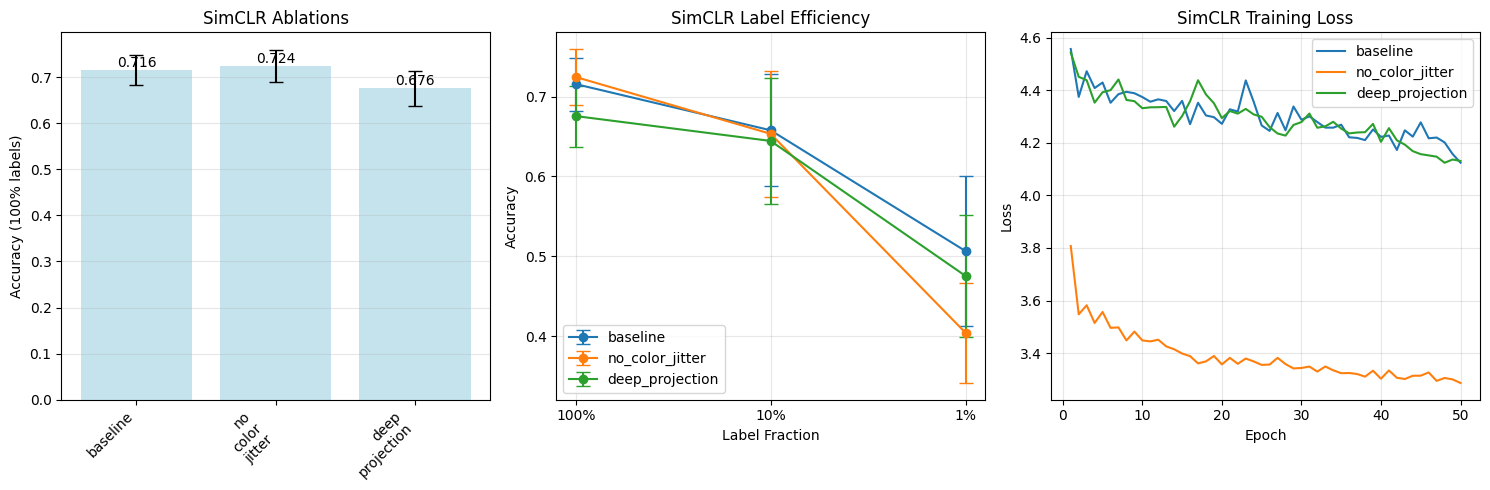


SimCLR analysis completed and saved to 'simclr_results.png'


In [15]:
def run_simclr_experiments():
    """Run only SimCLR experiments with ablations"""
    print("="*70)
    print("RUNNING SIMCLR EXPERIMENTS")
    print("="*70)
    
    # Configuration
    root_dir = '/kaggle/input/wheatvarieties/Wheat varieties dataset-20240912T042219Z-001/Wheat varieties dataset'
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    print(f"Using device: {device}")
    print(f"PyTorch version: {torch.__version__}")
    
    # Initialize experiment
    experiment = SSLExperiment(
        root_dir=root_dir,
        image_size=224,
        batch_size=64,
        device=device
    )
    
    # Run SimCLR experiments
    simclr_results = {}
    simclr_ablations = ['no_color_jitter', 'deep_projection']
    
    # Run baseline
    print("\n" + "#"*60)
    print("Running SIMCLR Baseline")
    print("#"*60)
    baseline_results = experiment.run_single_experiment('simclr', ablation=None, 
                                                       pretrain_epochs=50, num_seeds=3)
    simclr_results['baseline'] = baseline_results
    
    # Run ablations
    for ablation in simclr_ablations:
        print("\n" + "#"*60)
        print(f"Running SIMCLR - {ablation}")
        print("#"*60)
        ablation_results = experiment.run_single_experiment('simclr', ablation=ablation, 
                                                           pretrain_epochs=50, num_seeds=3)
        simclr_results[ablation] = ablation_results
    
    # Analyze SimCLR results
    print("\n" + "="*70)
    print("SIMCLR STATISTICAL ANALYSIS")
    print("="*70)
    
    # Create a simple analyzer for single method
    def analyze_single_method(results):
        """Analyze results for a single SSL method"""
        report = {}
        
        # 1. Ablation effects
        baseline = results['baseline']
        report['ablations'] = {}
        
        for ablation_name in results.keys():
            if ablation_name != 'baseline':
                # Paired t-test for each ablation vs baseline
                accs_baseline = []
                accs_ablation = []
                
                for seed in baseline.keys():
                    if seed in results[ablation_name]:
                        accs_baseline.append(baseline[seed]['accuracies']['label_100%'])
                        accs_ablation.append(results[ablation_name][seed]['accuracies']['label_100%'])
                
                if len(accs_baseline) > 1:  # Need at least 2 samples for t-test
                    t_stat, p_value = ttest_rel(accs_baseline, accs_ablation)
                    
                    # Calculate effect size
                    diff = np.array(accs_baseline) - np.array(accs_ablation)
                    cohens_d = np.mean(diff) / np.std(diff) if np.std(diff) > 0 else 0
                    
                    report['ablations'][ablation_name] = {
                        't_statistic': t_stat,
                        'p_value': p_value,
                        'cohens_d': cohens_d,
                        'mean_baseline': np.mean(accs_baseline),
                        'mean_ablation': np.mean(accs_ablation),
                        'std_baseline': np.std(accs_baseline),
                        'std_ablation': np.std(accs_ablation),
                        'n': len(accs_baseline)
                    }
        
        # 2. Label efficiency analysis
        report['label_efficiency'] = {}
        fractions = ['label_100%', 'label_10%', 'label_1%']
        
        for config_name, config_results in results.items():
            report['label_efficiency'][config_name] = {}
            for fraction in fractions:
                accs = [config_results[seed]['accuracies'][fraction] 
                       for seed in config_results.keys()]
                mean_acc = np.mean(accs)
                std_acc = np.std(accs)
                
                report['label_efficiency'][config_name][fraction] = {
                    'mean': mean_acc,
                    'std': std_acc
                }
            
            # Calculate relative performance
            if 'label_100%' in report['label_efficiency'][config_name]:
                base_mean = report['label_efficiency'][config_name]['label_100%']['mean']
                for fraction in ['label_10%', 'label_1%']:
                    if fraction in report['label_efficiency'][config_name]:
                        rel_perf = report['label_efficiency'][config_name][fraction]['mean'] / base_mean if base_mean > 0 else 0
                        report['label_efficiency'][config_name][fraction]['relative'] = rel_perf
        
        return report
    
    # Generate report for SimCLR
    report = analyze_single_method(simclr_results)
    
    # Display SimCLR results
    print("\n=== SIMCLR STATISTICAL REPORT ===")
    
    print("\nAblation Effects (Paired t-tests):")
    for ablation_name in simclr_ablations:
        if ablation_name in report['ablations']:
            comp = report['ablations'][ablation_name]
            p_val = comp['p_value']
            sig = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else ""
            
            print(f"\n  Baseline vs {ablation_name}:")
            print(f"    Baseline: {comp['mean_baseline']:.4f} ± {comp['std_baseline']:.4f}")
            print(f"    Ablation: {comp['mean_ablation']:.4f} ± {comp['std_ablation']:.4f}")
            print(f"    Change: {((comp['mean_ablation'] - comp['mean_baseline']) / comp['mean_baseline'])*100:+.2f}%")
            print(f"    t({comp['n']-1}) = {comp['t_statistic']:.4f}, p = {p_val:.6f} {sig}")
            print(f"    Cohen's d = {comp['cohens_d']:.3f}")
    
    print("\nLabel Efficiency:")
    efficiency = report['label_efficiency']
    for config_name in efficiency.keys():
        print(f"\n  {config_name}:")
        for fraction in ['label_100%', 'label_10%', 'label_1%']:
            if fraction in efficiency[config_name]:
                data = efficiency[config_name][fraction]
                if 'relative' in data:
                    print(f"    {fraction}: {data['mean']:.4f} ± {data['std']:.4f} "
                          f"(Relative: {data['relative']:.2%})")
                else:
                    print(f"    {fraction}: {data['mean']:.4f} ± {data['std']:.4f}")
    
    # Plot SimCLR results
    print("\nGenerating SimCLR visualizations...")
    
    # Simple plotting for single method
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Plot 1: Ablation comparison
    ax = axes[0]
    configs = list(simclr_results.keys())
    means = []
    stds = []
    
    for config in configs:
        config_results = simclr_results[config]
        accs = [config_results[seed]['accuracies']['label_100%'] 
               for seed in config_results.keys()]
        means.append(np.mean(accs))
        stds.append(np.std(accs))
    
    x = np.arange(len(configs))
    bars = ax.bar(x, means, yerr=stds, capsize=5, color='lightblue', alpha=0.7)
    ax.set_xticks(x)
    ax.set_xticklabels([c.replace('_', '\n') for c in configs], rotation=45, ha='right')
    ax.set_title('SimCLR Ablations')
    ax.set_ylabel('Accuracy (100% labels)')
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add value labels
    for bar, mean_val in zip(bars, means):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
               f'{mean_val:.3f}', ha='center', va='bottom')
    
    # Plot 2: Label efficiency
    ax = axes[1]
    fractions = ['100%', '10%', '1%']
    fraction_keys = ['label_100%', 'label_10%', 'label_1%']
    
    for config_name in simclr_results.keys():
        means = []
        stds = []
        for key in fraction_keys:
            accs = [simclr_results[config_name][seed]['accuracies'][key] 
                   for seed in simclr_results[config_name].keys()]
            means.append(np.mean(accs))
            stds.append(np.std(accs))
        
        ax.errorbar(fractions, means, yerr=stds, marker='o', 
                   label=config_name, capsize=5)
    
    ax.set_title('SimCLR Label Efficiency')
    ax.set_xlabel('Label Fraction')
    ax.set_ylabel('Accuracy')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Plot 3: Training loss
    ax = axes[2]
    for config_name in simclr_results.keys():
        # Average loss across seeds
        all_losses = [simclr_results[config_name][seed]['losses'] 
                     for seed in simclr_results[config_name].keys()]
        min_len = min(len(loss) for loss in all_losses)
        truncated_losses = [loss[:min_len] for loss in all_losses]
        avg_loss = np.mean(truncated_losses, axis=0)
        
        epochs = range(1, len(avg_loss) + 1)
        ax.plot(epochs, avg_loss, label=config_name)
    
    ax.set_title('SimCLR Training Loss')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('simclr_results.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("\nSimCLR analysis completed and saved to 'simclr_results.png'")
    
    return {'simclr': simclr_results}, report

# Run only SimCLR experiments
simclr_results, simclr_report = run_simclr_experiments()

# BYOL

RUNNING BYOL EXPERIMENTS
Using device: cuda
PyTorch version: 2.6.0+cu124
Dataset loaded: 375 samples
Train: 300, Test: 75
Classes: ['Akbar', 'Dilkash', 'urooj']


Computing stats: 100%|██████████| 12/12 [00:04<00:00,  2.50it/s]


Mean: [0.49219194054603577, 0.46283817291259766, 0.4575345516204834]
Std: [0.07509942352771759, 0.07036154717206955, 0.053037378937006]

############################################################
Running BYOL Baseline
############################################################

Running BYOL - Baseline (Seed 0)


Epoch 1: 100%|██████████| 5/5 [00:15<00:00,  3.08s/it]


Epoch 1: Loss = 0.0052


Epoch 2: 100%|██████████| 5/5 [00:13<00:00,  2.78s/it]


Epoch 2: Loss = 0.0035


Epoch 3: 100%|██████████| 5/5 [00:14<00:00,  2.96s/it]


Epoch 3: Loss = 0.0030


Epoch 4: 100%|██████████| 5/5 [00:15<00:00,  3.01s/it]


Epoch 4: Loss = 0.0028


Epoch 5: 100%|██████████| 5/5 [00:15<00:00,  3.13s/it]


Epoch 5: Loss = 0.0027


Epoch 6: 100%|██████████| 5/5 [00:16<00:00,  3.33s/it]


Epoch 6: Loss = 0.0024


Epoch 7: 100%|██████████| 5/5 [00:12<00:00,  2.56s/it]


Epoch 7: Loss = 0.0022


Epoch 8: 100%|██████████| 5/5 [00:14<00:00,  2.93s/it]


Epoch 8: Loss = 0.0019


Epoch 9: 100%|██████████| 5/5 [00:12<00:00,  2.57s/it]


Epoch 9: Loss = 0.0017


Epoch 10: 100%|██████████| 5/5 [00:12<00:00,  2.54s/it]


Epoch 10: Loss = 0.0016


Epoch 11: 100%|██████████| 5/5 [00:14<00:00,  2.97s/it]


Epoch 11: Loss = 0.0015


Epoch 12: 100%|██████████| 5/5 [00:14<00:00,  2.80s/it]


Epoch 12: Loss = 0.0014


Epoch 13: 100%|██████████| 5/5 [00:12<00:00,  2.50s/it]


Epoch 13: Loss = 0.0014


Epoch 14: 100%|██████████| 5/5 [00:11<00:00,  2.26s/it]


Epoch 14: Loss = 0.0014


Epoch 15: 100%|██████████| 5/5 [00:14<00:00,  2.85s/it]


Epoch 15: Loss = 0.0012


Epoch 16: 100%|██████████| 5/5 [00:14<00:00,  2.99s/it]


Epoch 16: Loss = 0.0010


Epoch 17: 100%|██████████| 5/5 [00:13<00:00,  2.79s/it]


Epoch 17: Loss = 0.0012


Epoch 18: 100%|██████████| 5/5 [00:12<00:00,  2.52s/it]


Epoch 18: Loss = 0.0011


Epoch 19: 100%|██████████| 5/5 [00:13<00:00,  2.62s/it]


Epoch 19: Loss = 0.0012


Epoch 20: 100%|██████████| 5/5 [00:12<00:00,  2.55s/it]


Epoch 20: Loss = 0.0009


Epoch 21: 100%|██████████| 5/5 [00:11<00:00,  2.34s/it]


Epoch 21: Loss = 0.0011


Epoch 22: 100%|██████████| 5/5 [00:14<00:00,  2.87s/it]


Epoch 22: Loss = 0.0009


Epoch 23: 100%|██████████| 5/5 [00:13<00:00,  2.64s/it]


Epoch 23: Loss = 0.0010


Epoch 24: 100%|██████████| 5/5 [00:14<00:00,  2.94s/it]


Epoch 24: Loss = 0.0010


Epoch 25: 100%|██████████| 5/5 [00:15<00:00,  3.17s/it]


Epoch 25: Loss = 0.0010


Epoch 26: 100%|██████████| 5/5 [00:13<00:00,  2.65s/it]


Epoch 26: Loss = 0.0010


Epoch 27: 100%|██████████| 5/5 [00:15<00:00,  3.15s/it]


Epoch 27: Loss = 0.0010


Epoch 28: 100%|██████████| 5/5 [00:13<00:00,  2.68s/it]


Epoch 28: Loss = 0.0009


Epoch 29: 100%|██████████| 5/5 [00:12<00:00,  2.47s/it]


Epoch 29: Loss = 0.0011


Epoch 30: 100%|██████████| 5/5 [00:12<00:00,  2.43s/it]


Epoch 30: Loss = 0.0008


Epoch 31: 100%|██████████| 5/5 [00:15<00:00,  3.05s/it]


Epoch 31: Loss = 0.0011


Epoch 32: 100%|██████████| 5/5 [00:14<00:00,  2.97s/it]


Epoch 32: Loss = 0.0008


Epoch 33: 100%|██████████| 5/5 [00:12<00:00,  2.51s/it]


Epoch 33: Loss = 0.0010


Epoch 34: 100%|██████████| 5/5 [00:13<00:00,  2.65s/it]


Epoch 34: Loss = 0.0009


Epoch 35: 100%|██████████| 5/5 [00:13<00:00,  2.65s/it]


Epoch 35: Loss = 0.0011


Epoch 36: 100%|██████████| 5/5 [00:13<00:00,  2.69s/it]


Epoch 36: Loss = 0.0009


Epoch 37: 100%|██████████| 5/5 [00:13<00:00,  2.71s/it]


Epoch 37: Loss = 0.0008


Epoch 38: 100%|██████████| 5/5 [00:12<00:00,  2.46s/it]


Epoch 38: Loss = 0.0010


Epoch 39: 100%|██████████| 5/5 [00:14<00:00,  2.85s/it]


Epoch 39: Loss = 0.0009


Epoch 40: 100%|██████████| 5/5 [00:14<00:00,  2.86s/it]


Epoch 40: Loss = 0.0009


Epoch 41: 100%|██████████| 5/5 [00:14<00:00,  2.93s/it]


Epoch 41: Loss = 0.0011


Epoch 42: 100%|██████████| 5/5 [00:13<00:00,  2.77s/it]


Epoch 42: Loss = 0.0009


Epoch 43: 100%|██████████| 5/5 [00:14<00:00,  2.81s/it]


Epoch 43: Loss = 0.0009


Epoch 44: 100%|██████████| 5/5 [00:13<00:00,  2.62s/it]


Epoch 44: Loss = 0.0007


Epoch 45: 100%|██████████| 5/5 [00:12<00:00,  2.47s/it]


Epoch 45: Loss = 0.0007


Epoch 46: 100%|██████████| 5/5 [00:13<00:00,  2.68s/it]


Epoch 46: Loss = 0.0008


Epoch 47: 100%|██████████| 5/5 [00:12<00:00,  2.45s/it]


Epoch 47: Loss = 0.0008


Epoch 48: 100%|██████████| 5/5 [00:13<00:00,  2.74s/it]


Epoch 48: Loss = 0.0008


Epoch 49: 100%|██████████| 5/5 [00:14<00:00,  2.80s/it]


Epoch 49: Loss = 0.0009


Epoch 50: 100%|██████████| 5/5 [00:11<00:00,  2.29s/it]

Epoch 50: Loss = 0.0006

Linear evaluation with 100.0% labels:


Epoch 20: Loss=0.6802, Acc=64.67%
Epoch 40: Loss=0.6377, Acc=70.33%
Epoch 60: Loss=0.5882, Acc=75.67%
Epoch 80: Loss=0.5818, Acc=72.33%
Epoch 100: Loss=0.5388, Acc=75.00%
Test Accuracy: 70.67%

Linear evaluation with 10.0% labels:
Epoch 20: Loss=2.0653, Acc=33.33%
Epoch 40: Loss=0.9437, Acc=60.00%
Epoch 60: Loss=0.5840, Acc=70.00%
Epoch 80: Loss=0.5493, Acc=76.67%
Epoch 100: Loss=0.5149, Acc=76.67%
Test Accuracy: 57.33%

Linear evaluation with 1.0% labels:
Epoch 20: Loss=1.8758, Acc=66.67%
Epoch 40: Loss=0.1402, Acc=100.00%
Epoch 60: Loss=0.0970, Acc=100.00%
Epoch 80: Loss=0.0584, Acc=100.00%
Epoch 100: Loss=0.0466, Acc=100.00%
Test Accuracy: 50.67%

Running BYOL - Baseline (Seed 1)


Epoch 1: 100%|██████████| 5/5 [00:14<00:00,  2.87s/it]


Epoch 1: Loss = 0.0050


Epoch 2: 100%|██████████| 5/5 [00:15<00:00,  3.09s/it]


Epoch 2: Loss = 0.0035


Epoch 3: 100%|██████████| 5/5 [00:16<00:00,  3.25s/it]


Epoch 3: Loss = 0.0030


Epoch 4: 100%|██████████| 5/5 [00:15<00:00,  3.10s/it]


Epoch 4: Loss = 0.0028


Epoch 5: 100%|██████████| 5/5 [00:13<00:00,  2.73s/it]


Epoch 5: Loss = 0.0027


Epoch 6: 100%|██████████| 5/5 [00:13<00:00,  2.66s/it]


Epoch 6: Loss = 0.0026


Epoch 7: 100%|██████████| 5/5 [00:13<00:00,  2.77s/it]


Epoch 7: Loss = 0.0022


Epoch 8: 100%|██████████| 5/5 [00:13<00:00,  2.61s/it]


Epoch 8: Loss = 0.0020


Epoch 9: 100%|██████████| 5/5 [00:14<00:00,  2.97s/it]


Epoch 9: Loss = 0.0019


Epoch 10: 100%|██████████| 5/5 [00:15<00:00,  3.03s/it]


Epoch 10: Loss = 0.0019


Epoch 11: 100%|██████████| 5/5 [00:11<00:00,  2.31s/it]


Epoch 11: Loss = 0.0019


Epoch 12: 100%|██████████| 5/5 [00:13<00:00,  2.76s/it]


Epoch 12: Loss = 0.0015


Epoch 13: 100%|██████████| 5/5 [00:14<00:00,  2.83s/it]


Epoch 13: Loss = 0.0014


Epoch 14: 100%|██████████| 5/5 [00:13<00:00,  2.67s/it]


Epoch 14: Loss = 0.0013


Epoch 15: 100%|██████████| 5/5 [00:13<00:00,  2.68s/it]


Epoch 15: Loss = 0.0013


Epoch 16: 100%|██████████| 5/5 [00:12<00:00,  2.55s/it]


Epoch 16: Loss = 0.0012


Epoch 17: 100%|██████████| 5/5 [00:13<00:00,  2.61s/it]


Epoch 17: Loss = 0.0009


Epoch 18: 100%|██████████| 5/5 [00:13<00:00,  2.67s/it]


Epoch 18: Loss = 0.0010


Epoch 19: 100%|██████████| 5/5 [00:11<00:00,  2.37s/it]


Epoch 19: Loss = 0.0011


Epoch 20: 100%|██████████| 5/5 [00:13<00:00,  2.71s/it]


Epoch 20: Loss = 0.0009


Epoch 21: 100%|██████████| 5/5 [00:13<00:00,  2.77s/it]


Epoch 21: Loss = 0.0012


Epoch 22: 100%|██████████| 5/5 [00:12<00:00,  2.49s/it]


Epoch 22: Loss = 0.0008


Epoch 23: 100%|██████████| 5/5 [00:13<00:00,  2.65s/it]


Epoch 23: Loss = 0.0006


Epoch 24: 100%|██████████| 5/5 [00:15<00:00,  3.07s/it]


Epoch 24: Loss = 0.0008


Epoch 25: 100%|██████████| 5/5 [00:12<00:00,  2.53s/it]


Epoch 25: Loss = 0.0007


Epoch 26: 100%|██████████| 5/5 [00:14<00:00,  2.87s/it]


Epoch 26: Loss = 0.0008


Epoch 27: 100%|██████████| 5/5 [00:15<00:00,  3.14s/it]


Epoch 27: Loss = 0.0007


Epoch 28: 100%|██████████| 5/5 [00:14<00:00,  2.80s/it]


Epoch 28: Loss = 0.0009


Epoch 29: 100%|██████████| 5/5 [00:13<00:00,  2.71s/it]


Epoch 29: Loss = 0.0010


Epoch 30: 100%|██████████| 5/5 [00:13<00:00,  2.78s/it]


Epoch 30: Loss = 0.0007


Epoch 31: 100%|██████████| 5/5 [00:14<00:00,  2.82s/it]


Epoch 31: Loss = 0.0007


Epoch 32: 100%|██████████| 5/5 [00:14<00:00,  2.83s/it]


Epoch 32: Loss = 0.0009


Epoch 33: 100%|██████████| 5/5 [00:13<00:00,  2.70s/it]


Epoch 33: Loss = 0.0009


Epoch 34: 100%|██████████| 5/5 [00:14<00:00,  2.90s/it]


Epoch 34: Loss = 0.0008


Epoch 35: 100%|██████████| 5/5 [00:12<00:00,  2.59s/it]


Epoch 35: Loss = 0.0008


Epoch 36: 100%|██████████| 5/5 [00:13<00:00,  2.72s/it]


Epoch 36: Loss = 0.0008


Epoch 37: 100%|██████████| 5/5 [00:15<00:00,  3.14s/it]


Epoch 37: Loss = 0.0008


Epoch 38: 100%|██████████| 5/5 [00:14<00:00,  2.86s/it]


Epoch 38: Loss = 0.0008


Epoch 39: 100%|██████████| 5/5 [00:13<00:00,  2.74s/it]


Epoch 39: Loss = 0.0006


Epoch 40: 100%|██████████| 5/5 [00:13<00:00,  2.65s/it]


Epoch 40: Loss = 0.0007


Epoch 41: 100%|██████████| 5/5 [00:14<00:00,  2.95s/it]


Epoch 41: Loss = 0.0008


Epoch 42: 100%|██████████| 5/5 [00:13<00:00,  2.72s/it]


Epoch 42: Loss = 0.0008


Epoch 43: 100%|██████████| 5/5 [00:14<00:00,  2.84s/it]


Epoch 43: Loss = 0.0005


Epoch 44: 100%|██████████| 5/5 [00:12<00:00,  2.51s/it]


Epoch 44: Loss = 0.0005


Epoch 45: 100%|██████████| 5/5 [00:12<00:00,  2.50s/it]


Epoch 45: Loss = 0.0007


Epoch 46: 100%|██████████| 5/5 [00:14<00:00,  2.96s/it]


Epoch 46: Loss = 0.0009


Epoch 47: 100%|██████████| 5/5 [00:14<00:00,  2.89s/it]


Epoch 47: Loss = 0.0006


Epoch 48: 100%|██████████| 5/5 [00:15<00:00,  3.03s/it]


Epoch 48: Loss = 0.0006


Epoch 49: 100%|██████████| 5/5 [00:12<00:00,  2.59s/it]


Epoch 49: Loss = 0.0008


Epoch 50: 100%|██████████| 5/5 [00:13<00:00,  2.72s/it]

Epoch 50: Loss = 0.0007

Linear evaluation with 100.0% labels:


Epoch 20: Loss=0.6140, Acc=68.00%
Epoch 40: Loss=0.5643, Acc=70.67%
Epoch 60: Loss=0.5037, Acc=75.67%
Epoch 80: Loss=0.4563, Acc=79.67%
Epoch 100: Loss=0.4614, Acc=76.33%
Test Accuracy: 73.33%

Linear evaluation with 10.0% labels:
Epoch 20: Loss=0.6035, Acc=76.67%
Epoch 40: Loss=0.5021, Acc=80.00%
Epoch 60: Loss=0.4624, Acc=80.00%
Epoch 80: Loss=0.4336, Acc=83.33%
Epoch 100: Loss=0.4096, Acc=83.33%
Test Accuracy: 66.67%

Linear evaluation with 1.0% labels:
Epoch 20: Loss=0.4899, Acc=66.67%
Epoch 40: Loss=0.1763, Acc=100.00%
Epoch 60: Loss=0.1016, Acc=100.00%
Epoch 80: Loss=0.0675, Acc=100.00%
Epoch 100: Loss=0.0490, Acc=100.00%
Test Accuracy: 57.33%

Running BYOL - Baseline (Seed 2)


Epoch 1: 100%|██████████| 5/5 [00:13<00:00,  2.61s/it]


Epoch 1: Loss = 0.0052


Epoch 2: 100%|██████████| 5/5 [00:13<00:00,  2.78s/it]


Epoch 2: Loss = 0.0037


Epoch 3: 100%|██████████| 5/5 [00:12<00:00,  2.59s/it]


Epoch 3: Loss = 0.0031


Epoch 4: 100%|██████████| 5/5 [00:14<00:00,  2.83s/it]


Epoch 4: Loss = 0.0030


Epoch 5: 100%|██████████| 5/5 [00:14<00:00,  2.89s/it]


Epoch 5: Loss = 0.0026


Epoch 6: 100%|██████████| 5/5 [00:13<00:00,  2.60s/it]


Epoch 6: Loss = 0.0026


Epoch 7: 100%|██████████| 5/5 [00:14<00:00,  2.91s/it]


Epoch 7: Loss = 0.0022


Epoch 8: 100%|██████████| 5/5 [00:15<00:00,  3.17s/it]


Epoch 8: Loss = 0.0019


Epoch 9: 100%|██████████| 5/5 [00:11<00:00,  2.21s/it]


Epoch 9: Loss = 0.0016


Epoch 10: 100%|██████████| 5/5 [00:13<00:00,  2.66s/it]


Epoch 10: Loss = 0.0016


Epoch 11: 100%|██████████| 5/5 [00:13<00:00,  2.77s/it]


Epoch 11: Loss = 0.0016


Epoch 12: 100%|██████████| 5/5 [00:12<00:00,  2.56s/it]


Epoch 12: Loss = 0.0015


Epoch 13: 100%|██████████| 5/5 [00:13<00:00,  2.63s/it]


Epoch 13: Loss = 0.0014


Epoch 14: 100%|██████████| 5/5 [00:13<00:00,  2.77s/it]


Epoch 14: Loss = 0.0013


Epoch 15: 100%|██████████| 5/5 [00:14<00:00,  2.86s/it]


Epoch 15: Loss = 0.0011


Epoch 16: 100%|██████████| 5/5 [00:13<00:00,  2.76s/it]


Epoch 16: Loss = 0.0011


Epoch 17: 100%|██████████| 5/5 [00:13<00:00,  2.78s/it]


Epoch 17: Loss = 0.0010


Epoch 18: 100%|██████████| 5/5 [00:13<00:00,  2.62s/it]


Epoch 18: Loss = 0.0009


Epoch 19: 100%|██████████| 5/5 [00:13<00:00,  2.79s/it]


Epoch 19: Loss = 0.0010


Epoch 20: 100%|██████████| 5/5 [00:12<00:00,  2.47s/it]


Epoch 20: Loss = 0.0010


Epoch 21: 100%|██████████| 5/5 [00:13<00:00,  2.63s/it]


Epoch 21: Loss = 0.0011


Epoch 22: 100%|██████████| 5/5 [00:13<00:00,  2.61s/it]


Epoch 22: Loss = 0.0008


Epoch 23: 100%|██████████| 5/5 [00:13<00:00,  2.66s/it]


Epoch 23: Loss = 0.0008


Epoch 24: 100%|██████████| 5/5 [00:13<00:00,  2.76s/it]


Epoch 24: Loss = 0.0008


Epoch 25: 100%|██████████| 5/5 [00:12<00:00,  2.56s/it]


Epoch 25: Loss = 0.0008


Epoch 26: 100%|██████████| 5/5 [00:13<00:00,  2.80s/it]


Epoch 26: Loss = 0.0007


Epoch 27: 100%|██████████| 5/5 [00:13<00:00,  2.64s/it]


Epoch 27: Loss = 0.0007


Epoch 28: 100%|██████████| 5/5 [00:12<00:00,  2.58s/it]


Epoch 28: Loss = 0.0005


Epoch 29: 100%|██████████| 5/5 [00:12<00:00,  2.50s/it]


Epoch 29: Loss = 0.0008


Epoch 30: 100%|██████████| 5/5 [00:14<00:00,  2.97s/it]


Epoch 30: Loss = 0.0008


Epoch 31: 100%|██████████| 5/5 [00:15<00:00,  3.12s/it]


Epoch 31: Loss = 0.0007


Epoch 32: 100%|██████████| 5/5 [00:14<00:00,  2.92s/it]


Epoch 32: Loss = 0.0005


Epoch 33: 100%|██████████| 5/5 [00:14<00:00,  2.96s/it]


Epoch 33: Loss = 0.0007


Epoch 34: 100%|██████████| 5/5 [00:13<00:00,  2.80s/it]


Epoch 34: Loss = 0.0005


Epoch 35: 100%|██████████| 5/5 [00:14<00:00,  2.93s/it]


Epoch 35: Loss = 0.0008


Epoch 36: 100%|██████████| 5/5 [00:13<00:00,  2.60s/it]


Epoch 36: Loss = 0.0008


Epoch 37: 100%|██████████| 5/5 [00:14<00:00,  2.83s/it]


Epoch 37: Loss = 0.0010


Epoch 38: 100%|██████████| 5/5 [00:14<00:00,  2.84s/it]


Epoch 38: Loss = 0.0007


Epoch 39: 100%|██████████| 5/5 [00:14<00:00,  2.95s/it]


Epoch 39: Loss = 0.0006


Epoch 40: 100%|██████████| 5/5 [00:15<00:00,  3.15s/it]


Epoch 40: Loss = 0.0007


Epoch 41: 100%|██████████| 5/5 [00:14<00:00,  2.91s/it]


Epoch 41: Loss = 0.0006


Epoch 42: 100%|██████████| 5/5 [00:14<00:00,  2.90s/it]


Epoch 42: Loss = 0.0009


Epoch 43: 100%|██████████| 5/5 [00:14<00:00,  2.99s/it]


Epoch 43: Loss = 0.0009


Epoch 44: 100%|██████████| 5/5 [00:12<00:00,  2.50s/it]


Epoch 44: Loss = 0.0007


Epoch 45: 100%|██████████| 5/5 [00:13<00:00,  2.73s/it]


Epoch 45: Loss = 0.0005


Epoch 46: 100%|██████████| 5/5 [00:13<00:00,  2.74s/it]


Epoch 46: Loss = 0.0006


Epoch 47: 100%|██████████| 5/5 [00:12<00:00,  2.48s/it]


Epoch 47: Loss = 0.0006


Epoch 48: 100%|██████████| 5/5 [00:13<00:00,  2.66s/it]


Epoch 48: Loss = 0.0007


Epoch 49: 100%|██████████| 5/5 [00:12<00:00,  2.52s/it]


Epoch 49: Loss = 0.0007


Epoch 50: 100%|██████████| 5/5 [00:13<00:00,  2.63s/it]

Epoch 50: Loss = 0.0006

Linear evaluation with 100.0% labels:


Epoch 20: Loss=0.6261, Acc=67.67%
Epoch 40: Loss=0.5472, Acc=73.33%
Epoch 60: Loss=0.4930, Acc=77.67%
Epoch 80: Loss=0.4604, Acc=78.00%
Epoch 100: Loss=0.4411, Acc=81.33%
Test Accuracy: 73.33%

Linear evaluation with 10.0% labels:
Epoch 20: Loss=1.2917, Acc=63.33%
Epoch 40: Loss=0.6456, Acc=56.67%
Epoch 60: Loss=0.4981, Acc=83.33%
Epoch 80: Loss=0.4553, Acc=83.33%
Epoch 100: Loss=0.4265, Acc=83.33%
Test Accuracy: 68.00%

Linear evaluation with 1.0% labels:
Epoch 20: Loss=1.0589, Acc=66.67%
Epoch 40: Loss=0.2958, Acc=100.00%
Epoch 60: Loss=0.2442, Acc=100.00%
Epoch 80: Loss=0.1997, Acc=100.00%
Epoch 100: Loss=0.1656, Acc=100.00%
Test Accuracy: 45.33%

############################################################
Running BYOL - shallow_projection
############################################################

Running BYOL - shallow_projection (Seed 0)


Epoch 1: 100%|██████████| 5/5 [00:12<00:00,  2.56s/it]


Epoch 1: Loss = 0.0051


Epoch 2: 100%|██████████| 5/5 [00:12<00:00,  2.45s/it]


Epoch 2: Loss = 0.0035


Epoch 3: 100%|██████████| 5/5 [00:13<00:00,  2.62s/it]


Epoch 3: Loss = 0.0029


Epoch 4: 100%|██████████| 5/5 [00:12<00:00,  2.59s/it]


Epoch 4: Loss = 0.0026


Epoch 5: 100%|██████████| 5/5 [00:13<00:00,  2.75s/it]


Epoch 5: Loss = 0.0025


Epoch 6: 100%|██████████| 5/5 [00:16<00:00,  3.25s/it]


Epoch 6: Loss = 0.0023


Epoch 7: 100%|██████████| 5/5 [00:12<00:00,  2.56s/it]


Epoch 7: Loss = 0.0021


Epoch 8: 100%|██████████| 5/5 [00:14<00:00,  2.90s/it]


Epoch 8: Loss = 0.0021


Epoch 9: 100%|██████████| 5/5 [00:12<00:00,  2.50s/it]


Epoch 9: Loss = 0.0016


Epoch 10: 100%|██████████| 5/5 [00:12<00:00,  2.55s/it]


Epoch 10: Loss = 0.0016


Epoch 11: 100%|██████████| 5/5 [00:12<00:00,  2.47s/it]


Epoch 11: Loss = 0.0014


Epoch 12: 100%|██████████| 5/5 [00:12<00:00,  2.58s/it]


Epoch 12: Loss = 0.0013


Epoch 13: 100%|██████████| 5/5 [00:12<00:00,  2.53s/it]


Epoch 13: Loss = 0.0015


Epoch 14: 100%|██████████| 5/5 [00:13<00:00,  2.70s/it]


Epoch 14: Loss = 0.0015


Epoch 15: 100%|██████████| 5/5 [00:12<00:00,  2.45s/it]


Epoch 15: Loss = 0.0013


Epoch 16: 100%|██████████| 5/5 [00:15<00:00,  3.04s/it]


Epoch 16: Loss = 0.0011


Epoch 17: 100%|██████████| 5/5 [00:13<00:00,  2.72s/it]


Epoch 17: Loss = 0.0012


Epoch 18: 100%|██████████| 5/5 [00:13<00:00,  2.71s/it]


Epoch 18: Loss = 0.0011


Epoch 19: 100%|██████████| 5/5 [00:11<00:00,  2.38s/it]


Epoch 19: Loss = 0.0010


Epoch 20: 100%|██████████| 5/5 [00:13<00:00,  2.64s/it]


Epoch 20: Loss = 0.0010


Epoch 21: 100%|██████████| 5/5 [00:14<00:00,  2.88s/it]


Epoch 21: Loss = 0.0010


Epoch 22: 100%|██████████| 5/5 [00:15<00:00,  3.12s/it]


Epoch 22: Loss = 0.0009


Epoch 23: 100%|██████████| 5/5 [00:14<00:00,  2.84s/it]


Epoch 23: Loss = 0.0009


Epoch 24: 100%|██████████| 5/5 [00:12<00:00,  2.50s/it]


Epoch 24: Loss = 0.0010


Epoch 25: 100%|██████████| 5/5 [00:14<00:00,  2.92s/it]


Epoch 25: Loss = 0.0010


Epoch 26: 100%|██████████| 5/5 [00:12<00:00,  2.57s/it]


Epoch 26: Loss = 0.0007


Epoch 27: 100%|██████████| 5/5 [00:14<00:00,  2.88s/it]


Epoch 27: Loss = 0.0011


Epoch 28: 100%|██████████| 5/5 [00:13<00:00,  2.68s/it]


Epoch 28: Loss = 0.0011


Epoch 29: 100%|██████████| 5/5 [00:14<00:00,  2.84s/it]


Epoch 29: Loss = 0.0012


Epoch 30: 100%|██████████| 5/5 [00:12<00:00,  2.47s/it]


Epoch 30: Loss = 0.0009


Epoch 31: 100%|██████████| 5/5 [00:12<00:00,  2.40s/it]


Epoch 31: Loss = 0.0009


Epoch 32: 100%|██████████| 5/5 [00:12<00:00,  2.57s/it]


Epoch 32: Loss = 0.0007


Epoch 33: 100%|██████████| 5/5 [00:13<00:00,  2.69s/it]


Epoch 33: Loss = 0.0009


Epoch 34: 100%|██████████| 5/5 [00:14<00:00,  2.86s/it]


Epoch 34: Loss = 0.0007


Epoch 35: 100%|██████████| 5/5 [00:13<00:00,  2.78s/it]


Epoch 35: Loss = 0.0008


Epoch 36: 100%|██████████| 5/5 [00:13<00:00,  2.71s/it]


Epoch 36: Loss = 0.0009


Epoch 37: 100%|██████████| 5/5 [00:13<00:00,  2.66s/it]


Epoch 37: Loss = 0.0008


Epoch 38: 100%|██████████| 5/5 [00:11<00:00,  2.37s/it]


Epoch 38: Loss = 0.0007


Epoch 39: 100%|██████████| 5/5 [00:12<00:00,  2.55s/it]


Epoch 39: Loss = 0.0007


Epoch 40: 100%|██████████| 5/5 [00:11<00:00,  2.26s/it]


Epoch 40: Loss = 0.0009


Epoch 41: 100%|██████████| 5/5 [00:13<00:00,  2.72s/it]


Epoch 41: Loss = 0.0007


Epoch 42: 100%|██████████| 5/5 [00:12<00:00,  2.43s/it]


Epoch 42: Loss = 0.0007


Epoch 43: 100%|██████████| 5/5 [00:13<00:00,  2.71s/it]


Epoch 43: Loss = 0.0010


Epoch 44: 100%|██████████| 5/5 [00:12<00:00,  2.58s/it]


Epoch 44: Loss = 0.0007


Epoch 45: 100%|██████████| 5/5 [00:13<00:00,  2.70s/it]


Epoch 45: Loss = 0.0007


Epoch 46: 100%|██████████| 5/5 [00:14<00:00,  2.91s/it]


Epoch 46: Loss = 0.0008


Epoch 47: 100%|██████████| 5/5 [00:14<00:00,  2.81s/it]


Epoch 47: Loss = 0.0007


Epoch 48: 100%|██████████| 5/5 [00:15<00:00,  3.08s/it]


Epoch 48: Loss = 0.0008


Epoch 49: 100%|██████████| 5/5 [00:15<00:00,  3.07s/it]


Epoch 49: Loss = 0.0010


Epoch 50: 100%|██████████| 5/5 [00:14<00:00,  2.81s/it]

Epoch 50: Loss = 0.0009

Linear evaluation with 100.0% labels:


Epoch 20: Loss=0.6991, Acc=61.00%
Epoch 40: Loss=0.9726, Acc=62.33%
Epoch 60: Loss=1.0292, Acc=59.67%
Epoch 80: Loss=0.6726, Acc=66.33%
Epoch 100: Loss=2.1677, Acc=55.00%
Test Accuracy: 57.33%

Linear evaluation with 10.0% labels:
Epoch 20: Loss=4.3595, Acc=56.67%
Epoch 40: Loss=0.6186, Acc=70.00%
Epoch 60: Loss=0.6217, Acc=63.33%
Epoch 80: Loss=0.5171, Acc=70.00%
Epoch 100: Loss=0.4823, Acc=80.00%
Test Accuracy: 62.67%

Linear evaluation with 1.0% labels:
Epoch 20: Loss=5.6598, Acc=66.67%
Epoch 40: Loss=0.3008, Acc=66.67%
Epoch 60: Loss=0.0750, Acc=100.00%
Epoch 80: Loss=0.0383, Acc=100.00%
Epoch 100: Loss=0.0261, Acc=100.00%
Test Accuracy: 46.67%

Running BYOL - shallow_projection (Seed 1)


Epoch 1: 100%|██████████| 5/5 [00:13<00:00,  2.70s/it]


Epoch 1: Loss = 0.0050


Epoch 2: 100%|██████████| 5/5 [00:15<00:00,  3.16s/it]


Epoch 2: Loss = 0.0034


Epoch 3: 100%|██████████| 5/5 [00:14<00:00,  2.95s/it]


Epoch 3: Loss = 0.0028


Epoch 4: 100%|██████████| 5/5 [00:15<00:00,  3.08s/it]


Epoch 4: Loss = 0.0028


Epoch 5: 100%|██████████| 5/5 [00:15<00:00,  3.14s/it]


Epoch 5: Loss = 0.0023


Epoch 6: 100%|██████████| 5/5 [00:12<00:00,  2.55s/it]


Epoch 6: Loss = 0.0022


Epoch 7: 100%|██████████| 5/5 [00:14<00:00,  2.93s/it]


Epoch 7: Loss = 0.0018


Epoch 8: 100%|██████████| 5/5 [00:12<00:00,  2.55s/it]


Epoch 8: Loss = 0.0018


Epoch 9: 100%|██████████| 5/5 [00:12<00:00,  2.57s/it]


Epoch 9: Loss = 0.0016


Epoch 10: 100%|██████████| 5/5 [00:12<00:00,  2.49s/it]


Epoch 10: Loss = 0.0016


Epoch 11: 100%|██████████| 5/5 [00:11<00:00,  2.39s/it]


Epoch 11: Loss = 0.0018


Epoch 12: 100%|██████████| 5/5 [00:14<00:00,  2.89s/it]


Epoch 12: Loss = 0.0016


Epoch 13: 100%|██████████| 5/5 [00:12<00:00,  2.50s/it]


Epoch 13: Loss = 0.0013


Epoch 14: 100%|██████████| 5/5 [00:14<00:00,  2.82s/it]


Epoch 14: Loss = 0.0014


Epoch 15: 100%|██████████| 5/5 [00:12<00:00,  2.54s/it]


Epoch 15: Loss = 0.0013


Epoch 16: 100%|██████████| 5/5 [00:12<00:00,  2.40s/it]


Epoch 16: Loss = 0.0012


Epoch 17: 100%|██████████| 5/5 [00:13<00:00,  2.65s/it]


Epoch 17: Loss = 0.0012


Epoch 18: 100%|██████████| 5/5 [00:13<00:00,  2.65s/it]


Epoch 18: Loss = 0.0009


Epoch 19: 100%|██████████| 5/5 [00:13<00:00,  2.78s/it]


Epoch 19: Loss = 0.0010


Epoch 20: 100%|██████████| 5/5 [00:13<00:00,  2.65s/it]


Epoch 20: Loss = 0.0010


Epoch 21: 100%|██████████| 5/5 [00:13<00:00,  2.67s/it]


Epoch 21: Loss = 0.0010


Epoch 22: 100%|██████████| 5/5 [00:12<00:00,  2.55s/it]


Epoch 22: Loss = 0.0007


Epoch 23: 100%|██████████| 5/5 [00:13<00:00,  2.67s/it]


Epoch 23: Loss = 0.0007


Epoch 24: 100%|██████████| 5/5 [00:11<00:00,  2.37s/it]


Epoch 24: Loss = 0.0009


Epoch 25: 100%|██████████| 5/5 [00:14<00:00,  2.95s/it]


Epoch 25: Loss = 0.0010


Epoch 26: 100%|██████████| 5/5 [00:11<00:00,  2.33s/it]


Epoch 26: Loss = 0.0006


Epoch 27: 100%|██████████| 5/5 [00:12<00:00,  2.47s/it]


Epoch 27: Loss = 0.0008


Epoch 28: 100%|██████████| 5/5 [00:13<00:00,  2.79s/it]


Epoch 28: Loss = 0.0011


Epoch 29: 100%|██████████| 5/5 [00:15<00:00,  3.18s/it]


Epoch 29: Loss = 0.0014


Epoch 30: 100%|██████████| 5/5 [00:12<00:00,  2.59s/it]


Epoch 30: Loss = 0.0009


Epoch 31: 100%|██████████| 5/5 [00:12<00:00,  2.42s/it]


Epoch 31: Loss = 0.0007


Epoch 32: 100%|██████████| 5/5 [00:13<00:00,  2.62s/it]


Epoch 32: Loss = 0.0006


Epoch 33: 100%|██████████| 5/5 [00:12<00:00,  2.59s/it]


Epoch 33: Loss = 0.0008


Epoch 34: 100%|██████████| 5/5 [00:14<00:00,  2.89s/it]


Epoch 34: Loss = 0.0007


Epoch 35: 100%|██████████| 5/5 [00:11<00:00,  2.40s/it]


Epoch 35: Loss = 0.0009


Epoch 36: 100%|██████████| 5/5 [00:12<00:00,  2.48s/it]


Epoch 36: Loss = 0.0007


Epoch 37: 100%|██████████| 5/5 [00:13<00:00,  2.72s/it]


Epoch 37: Loss = 0.0009


Epoch 38: 100%|██████████| 5/5 [00:15<00:00,  3.13s/it]


Epoch 38: Loss = 0.0007


Epoch 39: 100%|██████████| 5/5 [00:13<00:00,  2.66s/it]


Epoch 39: Loss = 0.0007


Epoch 40: 100%|██████████| 5/5 [00:12<00:00,  2.57s/it]


Epoch 40: Loss = 0.0009


Epoch 41: 100%|██████████| 5/5 [00:13<00:00,  2.74s/it]


Epoch 41: Loss = 0.0007


Epoch 42: 100%|██████████| 5/5 [00:12<00:00,  2.43s/it]


Epoch 42: Loss = 0.0008


Epoch 43: 100%|██████████| 5/5 [00:12<00:00,  2.52s/it]


Epoch 43: Loss = 0.0005


Epoch 44: 100%|██████████| 5/5 [00:12<00:00,  2.53s/it]


Epoch 44: Loss = 0.0007


Epoch 45: 100%|██████████| 5/5 [00:12<00:00,  2.43s/it]


Epoch 45: Loss = 0.0008


Epoch 46: 100%|██████████| 5/5 [00:12<00:00,  2.54s/it]


Epoch 46: Loss = 0.0007


Epoch 47: 100%|██████████| 5/5 [00:13<00:00,  2.76s/it]


Epoch 47: Loss = 0.0006


Epoch 48: 100%|██████████| 5/5 [00:13<00:00,  2.70s/it]


Epoch 48: Loss = 0.0006


Epoch 49: 100%|██████████| 5/5 [00:12<00:00,  2.42s/it]


Epoch 49: Loss = 0.0007


Epoch 50: 100%|██████████| 5/5 [00:14<00:00,  2.81s/it]

Epoch 50: Loss = 0.0007

Linear evaluation with 100.0% labels:


Epoch 20: Loss=0.7263, Acc=73.33%
Epoch 40: Loss=0.5468, Acc=73.67%
Epoch 60: Loss=0.5040, Acc=76.67%
Epoch 80: Loss=0.4727, Acc=77.67%
Epoch 100: Loss=0.4491, Acc=80.33%
Test Accuracy: 74.67%

Linear evaluation with 10.0% labels:
Epoch 20: Loss=1.8816, Acc=50.00%
Epoch 40: Loss=0.4539, Acc=73.33%
Epoch 60: Loss=0.4173, Acc=83.33%
Epoch 80: Loss=0.3827, Acc=83.33%
Epoch 100: Loss=0.3631, Acc=83.33%
Test Accuracy: 69.33%

Linear evaluation with 1.0% labels:
Epoch 20: Loss=0.0161, Acc=100.00%
Epoch 40: Loss=0.0114, Acc=100.00%
Epoch 60: Loss=0.0001, Acc=100.00%
Epoch 80: Loss=0.0001, Acc=100.00%
Epoch 100: Loss=0.0001, Acc=100.00%
Test Accuracy: 60.00%

Running BYOL - shallow_projection (Seed 2)


Epoch 1: 100%|██████████| 5/5 [00:12<00:00,  2.59s/it]


Epoch 1: Loss = 0.0051


Epoch 2: 100%|██████████| 5/5 [00:11<00:00,  2.31s/it]


Epoch 2: Loss = 0.0033


Epoch 3: 100%|██████████| 5/5 [00:12<00:00,  2.46s/it]


Epoch 3: Loss = 0.0027


Epoch 4: 100%|██████████| 5/5 [00:13<00:00,  2.79s/it]


Epoch 4: Loss = 0.0025


Epoch 5: 100%|██████████| 5/5 [00:13<00:00,  2.70s/it]


Epoch 5: Loss = 0.0024


Epoch 6: 100%|██████████| 5/5 [00:15<00:00,  3.01s/it]


Epoch 6: Loss = 0.0021


Epoch 7: 100%|██████████| 5/5 [00:15<00:00,  3.13s/it]


Epoch 7: Loss = 0.0020


Epoch 8: 100%|██████████| 5/5 [00:15<00:00,  3.00s/it]


Epoch 8: Loss = 0.0019


Epoch 9: 100%|██████████| 5/5 [00:14<00:00,  2.80s/it]


Epoch 9: Loss = 0.0015


Epoch 18: 100%|██████████| 5/5 [00:13<00:00,  2.69s/it]


Epoch 18: Loss = 0.0009


Epoch 19: 100%|██████████| 5/5 [00:15<00:00,  3.11s/it]


Epoch 19: Loss = 0.0008


Epoch 20: 100%|██████████| 5/5 [00:14<00:00,  2.95s/it]


Epoch 20: Loss = 0.0008


Epoch 21: 100%|██████████| 5/5 [00:13<00:00,  2.75s/it]


Epoch 21: Loss = 0.0008


Epoch 22: 100%|██████████| 5/5 [00:13<00:00,  2.73s/it]


Epoch 22: Loss = 0.0008


Epoch 23: 100%|██████████| 5/5 [00:15<00:00,  3.05s/it]


Epoch 23: Loss = 0.0009


Epoch 24: 100%|██████████| 5/5 [00:13<00:00,  2.63s/it]


Epoch 24: Loss = 0.0008


Epoch 25: 100%|██████████| 5/5 [00:12<00:00,  2.57s/it]


Epoch 25: Loss = 0.0009


Epoch 26: 100%|██████████| 5/5 [00:13<00:00,  2.78s/it]


Epoch 26: Loss = 0.0007


Epoch 27: 100%|██████████| 5/5 [00:14<00:00,  2.82s/it]


Epoch 27: Loss = 0.0008


Epoch 28: 100%|██████████| 5/5 [00:14<00:00,  2.88s/it]


Epoch 28: Loss = 0.0008


Epoch 29: 100%|██████████| 5/5 [00:14<00:00,  2.83s/it]


Epoch 29: Loss = 0.0008


Epoch 30: 100%|██████████| 5/5 [00:15<00:00,  3.08s/it]


Epoch 30: Loss = 0.0007


Epoch 31: 100%|██████████| 5/5 [00:14<00:00,  2.92s/it]


Epoch 31: Loss = 0.0008


Epoch 32: 100%|██████████| 5/5 [00:13<00:00,  2.64s/it]


Epoch 32: Loss = 0.0007


Epoch 33: 100%|██████████| 5/5 [00:14<00:00,  2.81s/it]


Epoch 33: Loss = 0.0009


Epoch 34: 100%|██████████| 5/5 [00:14<00:00,  2.80s/it]


Epoch 34: Loss = 0.0007


Epoch 35: 100%|██████████| 5/5 [00:14<00:00,  2.97s/it]


Epoch 35: Loss = 0.0006


Epoch 36: 100%|██████████| 5/5 [00:13<00:00,  2.64s/it]


Epoch 36: Loss = 0.0006


Epoch 37: 100%|██████████| 5/5 [00:13<00:00,  2.80s/it]


Epoch 37: Loss = 0.0007


Epoch 38: 100%|██████████| 5/5 [00:13<00:00,  2.69s/it]


Epoch 38: Loss = 0.0006


Epoch 39: 100%|██████████| 5/5 [00:14<00:00,  2.93s/it]


Epoch 39: Loss = 0.0007


Epoch 40: 100%|██████████| 5/5 [00:13<00:00,  2.68s/it]


Epoch 40: Loss = 0.0006


Epoch 41: 100%|██████████| 5/5 [00:14<00:00,  2.96s/it]


Epoch 41: Loss = 0.0007


Epoch 42: 100%|██████████| 5/5 [00:14<00:00,  2.87s/it]


Epoch 42: Loss = 0.0006


Epoch 43: 100%|██████████| 5/5 [00:13<00:00,  2.65s/it]


Epoch 43: Loss = 0.0005


Epoch 44: 100%|██████████| 5/5 [00:15<00:00,  3.04s/it]


Epoch 44: Loss = 0.0005


Epoch 45: 100%|██████████| 5/5 [00:15<00:00,  3.03s/it]


Epoch 45: Loss = 0.0009


Epoch 46: 100%|██████████| 5/5 [00:14<00:00,  2.86s/it]


Epoch 46: Loss = 0.0006


Epoch 47: 100%|██████████| 5/5 [00:13<00:00,  2.74s/it]


Epoch 47: Loss = 0.0006


Epoch 48: 100%|██████████| 5/5 [00:13<00:00,  2.72s/it]


Epoch 48: Loss = 0.0007


Epoch 49: 100%|██████████| 5/5 [00:13<00:00,  2.73s/it]


Epoch 49: Loss = 0.0005


Epoch 50: 100%|██████████| 5/5 [00:14<00:00,  2.93s/it]

Epoch 50: Loss = 0.0007

Linear evaluation with 100.0% labels:


Epoch 20: Loss=0.6502, Acc=73.33%
Epoch 40: Loss=0.6019, Acc=75.33%
Epoch 60: Loss=0.6260, Acc=68.00%
Epoch 80: Loss=0.5674, Acc=76.67%
Epoch 100: Loss=0.5215, Acc=78.67%
Test Accuracy: 74.67%

Linear evaluation with 10.0% labels:
Epoch 20: Loss=1.1925, Acc=56.67%
Epoch 40: Loss=0.6225, Acc=63.33%
Epoch 60: Loss=0.5298, Acc=90.00%
Epoch 80: Loss=0.4855, Acc=86.67%
Epoch 100: Loss=0.4540, Acc=90.00%
Test Accuracy: 69.33%

Linear evaluation with 1.0% labels:
Epoch 20: Loss=0.5462, Acc=66.67%
Epoch 40: Loss=0.3535, Acc=100.00%
Epoch 60: Loss=0.2379, Acc=100.00%
Epoch 80: Loss=0.1700, Acc=100.00%
Epoch 100: Loss=0.1275, Acc=100.00%
Test Accuracy: 38.67%

BYOL STATISTICAL ANALYSIS

=== BYOL STATISTICAL REPORT ===

Ablation Effects (Paired t-tests):

  Baseline vs shallow_projection:
    Baseline: 0.7244 ± 0.0126
    Ablation: 0.6889 ± 0.0817
    Change: -4.91%
    t(2) = 0.7273, p = 0.542670 
    Cohen's d = 0.514

Label Efficiency:

  baseline:
    label_100%: 0.7244 ± 0.0126
    label_10%

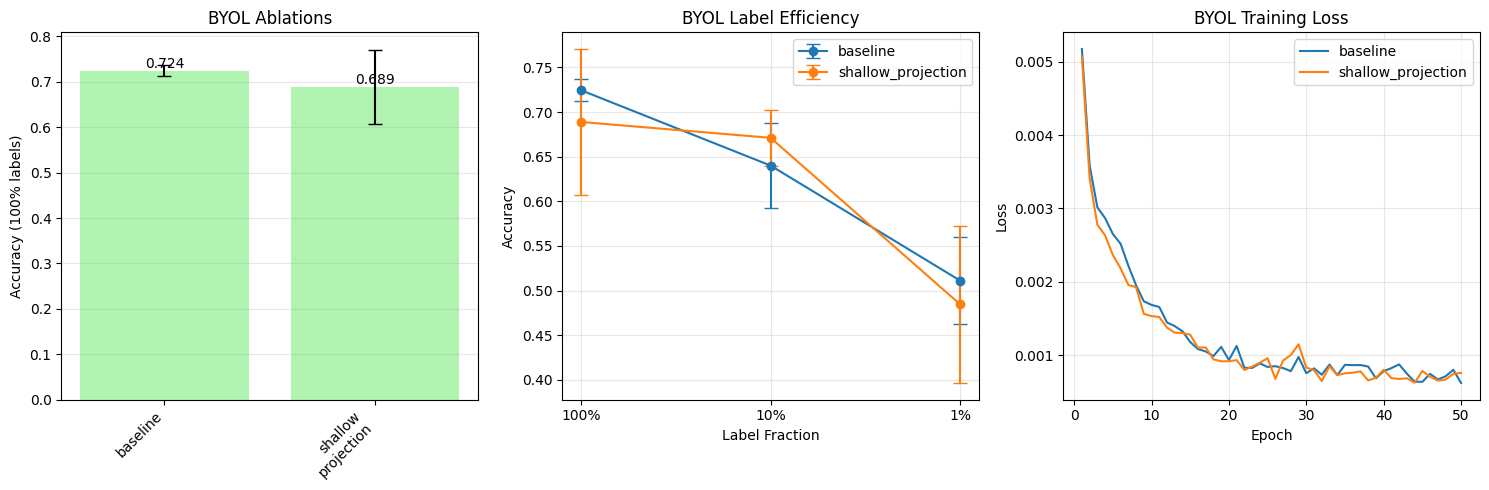


BYOL analysis completed and saved to 'byol_results.png'


In [12]:
def run_byol_experiments():
    """Run only BYOL experiments with ablations"""
    print("="*70)
    print("RUNNING BYOL EXPERIMENTS")
    print("="*70)
    
    # Configuration
    root_dir = '/kaggle/input/wheatvarieties/Wheat varieties dataset-20240912T042219Z-001/Wheat varieties dataset'
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    print(f"Using device: {device}")
    print(f"PyTorch version: {torch.__version__}")
    
    # Initialize experiment
    experiment = SSLExperiment(
        root_dir=root_dir,
        image_size=224,
        batch_size=64,
        device=device
    )
    
    # Run BYOL experiments
    byol_results = {}
    byol_ablations = ['shallow_projection']
    
    # Run baseline
    print("\n" + "#"*60)
    print("Running BYOL Baseline")
    print("#"*60)
    baseline_results = experiment.run_single_experiment('byol', ablation=None, 
                                                       pretrain_epochs=50, num_seeds=3)
    byol_results['baseline'] = baseline_results
    
    # Run ablations
    for ablation in byol_ablations:
        print("\n" + "#"*60)
        print(f"Running BYOL - {ablation}")
        print("#"*60)
        ablation_results = experiment.run_single_experiment('byol', ablation=ablation, 
                                                           pretrain_epochs=50, num_seeds=3)
        byol_results[ablation] = ablation_results
    
    # Analyze BYOL results
    print("\n" + "="*70)
    print("BYOL STATISTICAL ANALYSIS")
    print("="*70)
    
    # Simple analyzer for single method
    def analyze_single_method(results):
        """Analyze results for a single SSL method"""
        report = {}
        
        # 1. Ablation effects
        baseline = results['baseline']
        report['ablations'] = {}
        
        for ablation_name in results.keys():
            if ablation_name != 'baseline':
                # Paired t-test for each ablation vs baseline
                accs_baseline = []
                accs_ablation = []
                
                for seed in baseline.keys():
                    if seed in results[ablation_name]:
                        accs_baseline.append(baseline[seed]['accuracies']['label_100%'])
                        accs_ablation.append(results[ablation_name][seed]['accuracies']['label_100%'])
                
                if len(accs_baseline) > 1:  # Need at least 2 samples for t-test
                    t_stat, p_value = ttest_rel(accs_baseline, accs_ablation)
                    
                    # Calculate effect size
                    diff = np.array(accs_baseline) - np.array(accs_ablation)
                    cohens_d = np.mean(diff) / np.std(diff) if np.std(diff) > 0 else 0
                    
                    report['ablations'][ablation_name] = {
                        't_statistic': t_stat,
                        'p_value': p_value,
                        'cohens_d': cohens_d,
                        'mean_baseline': np.mean(accs_baseline),
                        'mean_ablation': np.mean(accs_ablation),
                        'std_baseline': np.std(accs_baseline),
                        'std_ablation': np.std(accs_ablation),
                        'n': len(accs_baseline)
                    }
        
        # 2. Label efficiency analysis
        report['label_efficiency'] = {}
        fractions = ['label_100%', 'label_10%', 'label_1%']
        
        for config_name, config_results in results.items():
            report['label_efficiency'][config_name] = {}
            for fraction in fractions:
                accs = [config_results[seed]['accuracies'][fraction] 
                       for seed in config_results.keys()]
                mean_acc = np.mean(accs)
                std_acc = np.std(accs)
                
                report['label_efficiency'][config_name][fraction] = {
                    'mean': mean_acc,
                    'std': std_acc
                }
            
            # Calculate relative performance
            if 'label_100%' in report['label_efficiency'][config_name]:
                base_mean = report['label_efficiency'][config_name]['label_100%']['mean']
                for fraction in ['label_10%', 'label_1%']:
                    if fraction in report['label_efficiency'][config_name]:
                        rel_perf = report['label_efficiency'][config_name][fraction]['mean'] / base_mean if base_mean > 0 else 0
                        report['label_efficiency'][config_name][fraction]['relative'] = rel_perf
        
        return report
    
    # Generate report for BYOL
    report = analyze_single_method(byol_results)
    
    # Display BYOL results
    print("\n=== BYOL STATISTICAL REPORT ===")
    
    print("\nAblation Effects (Paired t-tests):")
    for ablation_name in byol_ablations:
        if ablation_name in report['ablations']:
            comp = report['ablations'][ablation_name]
            p_val = comp['p_value']
            sig = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else ""
            
            print(f"\n  Baseline vs {ablation_name}:")
            print(f"    Baseline: {comp['mean_baseline']:.4f} ± {comp['std_baseline']:.4f}")
            print(f"    Ablation: {comp['mean_ablation']:.4f} ± {comp['std_ablation']:.4f}")
            print(f"    Change: {((comp['mean_ablation'] - comp['mean_baseline']) / comp['mean_baseline'])*100:+.2f}%")
            print(f"    t({comp['n']-1}) = {comp['t_statistic']:.4f}, p = {p_val:.6f} {sig}")
            print(f"    Cohen's d = {comp['cohens_d']:.3f}")
    
    print("\nLabel Efficiency:")
    efficiency = report['label_efficiency']
    for config_name in efficiency.keys():
        print(f"\n  {config_name}:")
        for fraction in ['label_100%', 'label_10%', 'label_1%']:
            if fraction in efficiency[config_name]:
                data = efficiency[config_name][fraction]
                if 'relative' in data:
                    print(f"    {fraction}: {data['mean']:.4f} ± {data['std']:.4f} "
                          f"(Relative: {data['relative']:.2%})")
                else:
                    print(f"    {fraction}: {data['mean']:.4f} ± {data['std']:.4f}")
    
    # Plot BYOL results
    print("\nGenerating BYOL visualizations...")
    
    # Simple plotting for single method
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Plot 1: Ablation comparison
    ax = axes[0]
    configs = list(byol_results.keys())
    means = []
    stds = []
    
    for config in configs:
        config_results = byol_results[config]
        accs = [config_results[seed]['accuracies']['label_100%'] 
               for seed in config_results.keys()]
        means.append(np.mean(accs))
        stds.append(np.std(accs))
    
    x = np.arange(len(configs))
    bars = ax.bar(x, means, yerr=stds, capsize=5, color='lightgreen', alpha=0.7)
    ax.set_xticks(x)
    ax.set_xticklabels([c.replace('_', '\n') for c in configs], rotation=45, ha='right')
    ax.set_title('BYOL Ablations')
    ax.set_ylabel('Accuracy (100% labels)')
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add value labels
    for bar, mean_val in zip(bars, means):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
               f'{mean_val:.3f}', ha='center', va='bottom')
    
    # Plot 2: Label efficiency
    ax = axes[1]
    fractions = ['100%', '10%', '1%']
    fraction_keys = ['label_100%', 'label_10%', 'label_1%']
    
    for config_name in byol_results.keys():
        means = []
        stds = []
        for key in fraction_keys:
            accs = [byol_results[config_name][seed]['accuracies'][key] 
                   for seed in byol_results[config_name].keys()]
            means.append(np.mean(accs))
            stds.append(np.std(accs))
        
        ax.errorbar(fractions, means, yerr=stds, marker='o', 
                   label=config_name, capsize=5)
    
    ax.set_title('BYOL Label Efficiency')
    ax.set_xlabel('Label Fraction')
    ax.set_ylabel('Accuracy')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Plot 3: Training loss
    ax = axes[2]
    for config_name in byol_results.keys():
        # Average loss across seeds
        all_losses = [byol_results[config_name][seed]['losses'] 
                     for seed in byol_results[config_name].keys()]
        min_len = min(len(loss) for loss in all_losses)
        truncated_losses = [loss[:min_len] for loss in all_losses]
        avg_loss = np.mean(truncated_losses, axis=0)
        
        epochs = range(1, len(avg_loss) + 1)
        ax.plot(epochs, avg_loss, label=config_name)
    
    ax.set_title('BYOL Training Loss')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('byol_results.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("\nBYOL analysis completed and saved to 'byol_results.png'")
    
    return {'byol': byol_results}, report

# Run only BYOL experiments
byol_results, byol_report = run_byol_experiments()

# Burlow Twins

RUNNING BARLOW TWINS EXPERIMENTS
Using device: cuda
PyTorch version: 2.6.0+cu124
Dataset loaded: 375 samples
Train: 300, Test: 75
Classes: ['Akbar', 'Dilkash', 'urooj']


Computing stats: 100%|██████████| 12/12 [00:01<00:00,  6.58it/s]


Mean: [0.49219194054603577, 0.46283817291259766, 0.4575345516204834]
Std: [0.07509942352771759, 0.07036154717206955, 0.053037378937006]

############################################################
Running Barlow Twins Baseline
############################################################

Running BARLOW - Baseline (Seed 0)


Epoch 1: 100%|██████████| 5/5 [00:03<00:00,  1.43it/s]


Epoch 1: Loss = 371.2041


Epoch 2: 100%|██████████| 5/5 [00:03<00:00,  1.41it/s]


Epoch 2: Loss = 324.7702


Epoch 3: 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]


Epoch 3: Loss = 295.9587


Epoch 4: 100%|██████████| 5/5 [00:03<00:00,  1.43it/s]


Epoch 4: Loss = 303.2737


Epoch 5: 100%|██████████| 5/5 [00:03<00:00,  1.51it/s]


Epoch 5: Loss = 307.7189


Epoch 6: 100%|██████████| 5/5 [00:03<00:00,  1.45it/s]


Epoch 6: Loss = 279.3770


Epoch 7: 100%|██████████| 5/5 [00:03<00:00,  1.43it/s]


Epoch 7: Loss = 252.8724


Epoch 8: 100%|██████████| 5/5 [00:03<00:00,  1.44it/s]


Epoch 8: Loss = 256.9724


Epoch 9: 100%|██████████| 5/5 [00:03<00:00,  1.33it/s]


Epoch 9: Loss = 261.7703


Epoch 10: 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]


Epoch 10: Loss = 298.8164


Epoch 11: 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]


Epoch 11: Loss = 280.8558


Epoch 12: 100%|██████████| 5/5 [00:03<00:00,  1.47it/s]


Epoch 12: Loss = 266.2219


Epoch 13: 100%|██████████| 5/5 [00:03<00:00,  1.51it/s]


Epoch 13: Loss = 253.7565


Epoch 14: 100%|██████████| 5/5 [00:03<00:00,  1.44it/s]


Epoch 14: Loss = 238.4282


Epoch 15: 100%|██████████| 5/5 [00:03<00:00,  1.44it/s]


Epoch 15: Loss = 227.1416


Epoch 16: 100%|██████████| 5/5 [00:03<00:00,  1.41it/s]


Epoch 16: Loss = 244.0446


Epoch 17: 100%|██████████| 5/5 [00:03<00:00,  1.40it/s]


Epoch 17: Loss = 264.2289


Epoch 18: 100%|██████████| 5/5 [00:03<00:00,  1.40it/s]


Epoch 18: Loss = 255.7858


Epoch 19: 100%|██████████| 5/5 [00:03<00:00,  1.46it/s]


Epoch 19: Loss = 262.5555


Epoch 20: 100%|██████████| 5/5 [00:03<00:00,  1.46it/s]


Epoch 20: Loss = 249.9801


Epoch 21: 100%|██████████| 5/5 [00:03<00:00,  1.32it/s]


Epoch 21: Loss = 250.0750


Epoch 22: 100%|██████████| 5/5 [00:03<00:00,  1.51it/s]


Epoch 22: Loss = 277.8033


Epoch 23: 100%|██████████| 5/5 [00:03<00:00,  1.55it/s]


Epoch 23: Loss = 293.5015


Epoch 24: 100%|██████████| 5/5 [00:03<00:00,  1.35it/s]


Epoch 24: Loss = 310.3697


Epoch 25: 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]


Epoch 25: Loss = 303.2468


Epoch 26: 100%|██████████| 5/5 [00:02<00:00,  1.70it/s]


Epoch 26: Loss = 296.3094


Epoch 27: 100%|██████████| 5/5 [00:03<00:00,  1.43it/s]


Epoch 27: Loss = 274.6898


Epoch 28: 100%|██████████| 5/5 [00:03<00:00,  1.44it/s]


Epoch 28: Loss = 272.2026


Epoch 29: 100%|██████████| 5/5 [00:03<00:00,  1.51it/s]


Epoch 29: Loss = 268.0747


Epoch 30: 100%|██████████| 5/5 [00:03<00:00,  1.56it/s]


Epoch 30: Loss = 249.3845


Epoch 31: 100%|██████████| 5/5 [00:03<00:00,  1.63it/s]


Epoch 31: Loss = 286.3382


Epoch 32: 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]


Epoch 32: Loss = 257.3232


Epoch 33: 100%|██████████| 5/5 [00:03<00:00,  1.42it/s]


Epoch 33: Loss = 258.4356


Epoch 34: 100%|██████████| 5/5 [00:03<00:00,  1.42it/s]


Epoch 34: Loss = 267.4167


Epoch 35: 100%|██████████| 5/5 [00:03<00:00,  1.38it/s]


Epoch 35: Loss = 269.4945


Epoch 36: 100%|██████████| 5/5 [00:03<00:00,  1.33it/s]


Epoch 36: Loss = 266.0178


Epoch 37: 100%|██████████| 5/5 [00:03<00:00,  1.45it/s]


Epoch 37: Loss = 259.0313


Epoch 38: 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]


Epoch 38: Loss = 240.2855


Epoch 39: 100%|██████████| 5/5 [00:03<00:00,  1.55it/s]


Epoch 39: Loss = 264.7432


Epoch 40: 100%|██████████| 5/5 [00:03<00:00,  1.43it/s]


Epoch 40: Loss = 268.2815


Epoch 41: 100%|██████████| 5/5 [00:03<00:00,  1.47it/s]


Epoch 41: Loss = 250.2796


Epoch 42: 100%|██████████| 5/5 [00:03<00:00,  1.42it/s]


Epoch 42: Loss = 268.7761


Epoch 43: 100%|██████████| 5/5 [00:04<00:00,  1.10it/s]


Epoch 43: Loss = 251.0156


Epoch 44: 100%|██████████| 5/5 [00:03<00:00,  1.31it/s]


Epoch 44: Loss = 247.4947


Epoch 45: 100%|██████████| 5/5 [00:03<00:00,  1.45it/s]


Epoch 45: Loss = 235.8749


Epoch 46: 100%|██████████| 5/5 [00:04<00:00,  1.23it/s]


Epoch 46: Loss = 235.1950


Epoch 47: 100%|██████████| 5/5 [00:03<00:00,  1.41it/s]


Epoch 47: Loss = 238.7525


Epoch 48: 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]


Epoch 48: Loss = 237.1245


Epoch 49: 100%|██████████| 5/5 [00:03<00:00,  1.42it/s]


Epoch 49: Loss = 263.2606


Epoch 50: 100%|██████████| 5/5 [00:03<00:00,  1.51it/s]

Epoch 50: Loss = 242.3726

Linear evaluation with 100.0% labels:


Epoch 20: Loss=0.5615, Acc=74.00%
Epoch 40: Loss=0.5134, Acc=78.33%
Epoch 60: Loss=0.4684, Acc=78.67%
Epoch 80: Loss=0.4505, Acc=78.33%
Epoch 100: Loss=0.4430, Acc=80.67%
Test Accuracy: 80.00%

Linear evaluation with 10.0% labels:
Epoch 20: Loss=0.6229, Acc=76.67%
Epoch 40: Loss=0.5400, Acc=73.33%
Epoch 60: Loss=0.4802, Acc=73.33%
Epoch 80: Loss=0.4430, Acc=83.33%
Epoch 100: Loss=0.4161, Acc=86.67%
Test Accuracy: 62.67%

Linear evaluation with 1.0% labels:
Epoch 20: Loss=0.0392, Acc=100.00%
Epoch 40: Loss=0.0073, Acc=100.00%
Epoch 60: Loss=0.0040, Acc=100.00%
Epoch 80: Loss=0.0031, Acc=100.00%
Epoch 100: Loss=0.0025, Acc=100.00%
Test Accuracy: 52.00%

Running BARLOW - Baseline (Seed 1)


Epoch 1: 100%|██████████| 5/5 [00:03<00:00,  1.25it/s]


Epoch 1: Loss = 390.7974


Epoch 2: 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]


Epoch 2: Loss = 332.3156


Epoch 3: 100%|██████████| 5/5 [00:03<00:00,  1.56it/s]


Epoch 3: Loss = 306.6960


Epoch 4: 100%|██████████| 5/5 [00:03<00:00,  1.53it/s]


Epoch 4: Loss = 326.1301


Epoch 5: 100%|██████████| 5/5 [00:03<00:00,  1.40it/s]


Epoch 5: Loss = 296.1645


Epoch 6: 100%|██████████| 5/5 [00:03<00:00,  1.40it/s]


Epoch 6: Loss = 286.2382


Epoch 7: 100%|██████████| 5/5 [00:03<00:00,  1.43it/s]


Epoch 7: Loss = 286.0993


Epoch 8: 100%|██████████| 5/5 [00:03<00:00,  1.55it/s]


Epoch 8: Loss = 279.2866


Epoch 9: 100%|██████████| 5/5 [00:03<00:00,  1.48it/s]


Epoch 9: Loss = 263.4750


Epoch 10: 100%|██████████| 5/5 [00:03<00:00,  1.45it/s]


Epoch 10: Loss = 280.7262


Epoch 11: 100%|██████████| 5/5 [00:03<00:00,  1.45it/s]


Epoch 11: Loss = 249.2489


Epoch 12: 100%|██████████| 5/5 [00:03<00:00,  1.48it/s]


Epoch 12: Loss = 260.5633


Epoch 13: 100%|██████████| 5/5 [00:03<00:00,  1.47it/s]


Epoch 13: Loss = 250.6487


Epoch 14: 100%|██████████| 5/5 [00:03<00:00,  1.45it/s]


Epoch 14: Loss = 261.8948


Epoch 15: 100%|██████████| 5/5 [00:03<00:00,  1.52it/s]


Epoch 15: Loss = 244.7598


Epoch 16: 100%|██████████| 5/5 [00:03<00:00,  1.57it/s]


Epoch 16: Loss = 255.7945


Epoch 17: 100%|██████████| 5/5 [00:03<00:00,  1.35it/s]


Epoch 17: Loss = 257.2018


Epoch 18: 100%|██████████| 5/5 [00:03<00:00,  1.42it/s]


Epoch 18: Loss = 245.7613


Epoch 19: 100%|██████████| 5/5 [00:03<00:00,  1.47it/s]


Epoch 19: Loss = 244.0037


Epoch 20: 100%|██████████| 5/5 [00:03<00:00,  1.42it/s]


Epoch 20: Loss = 276.9737


Epoch 21: 100%|██████████| 5/5 [00:03<00:00,  1.56it/s]


Epoch 21: Loss = 281.1466


Epoch 22: 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]


Epoch 22: Loss = 271.8917


Epoch 23: 100%|██████████| 5/5 [00:03<00:00,  1.39it/s]


Epoch 23: Loss = 254.8371


Epoch 24: 100%|██████████| 5/5 [00:03<00:00,  1.46it/s]


Epoch 24: Loss = 227.5783


Epoch 25: 100%|██████████| 5/5 [00:03<00:00,  1.61it/s]


Epoch 25: Loss = 236.1761


Epoch 26: 100%|██████████| 5/5 [00:03<00:00,  1.35it/s]


Epoch 26: Loss = 252.8268


Epoch 27: 100%|██████████| 5/5 [00:03<00:00,  1.34it/s]


Epoch 27: Loss = 234.1013


Epoch 28: 100%|██████████| 5/5 [00:03<00:00,  1.57it/s]


Epoch 28: Loss = 230.6694


Epoch 29: 100%|██████████| 5/5 [00:03<00:00,  1.53it/s]


Epoch 29: Loss = 264.8772


Epoch 30: 100%|██████████| 5/5 [00:03<00:00,  1.52it/s]


Epoch 30: Loss = 245.6782


Epoch 31: 100%|██████████| 5/5 [00:03<00:00,  1.46it/s]


Epoch 31: Loss = 256.7637


Epoch 32: 100%|██████████| 5/5 [00:03<00:00,  1.51it/s]


Epoch 32: Loss = 277.5628


Epoch 33: 100%|██████████| 5/5 [00:03<00:00,  1.51it/s]


Epoch 33: Loss = 237.3774


Epoch 34: 100%|██████████| 5/5 [00:02<00:00,  1.70it/s]


Epoch 34: Loss = 243.3308


Epoch 35: 100%|██████████| 5/5 [00:02<00:00,  1.70it/s]


Epoch 35: Loss = 252.4834


Epoch 36: 100%|██████████| 5/5 [00:03<00:00,  1.54it/s]


Epoch 36: Loss = 232.7065


Epoch 37: 100%|██████████| 5/5 [00:03<00:00,  1.58it/s]


Epoch 37: Loss = 234.2380


Epoch 38: 100%|██████████| 5/5 [00:03<00:00,  1.63it/s]


Epoch 38: Loss = 230.6041


Epoch 39: 100%|██████████| 5/5 [00:02<00:00,  1.68it/s]


Epoch 39: Loss = 218.7283


Epoch 40: 100%|██████████| 5/5 [00:03<00:00,  1.41it/s]


Epoch 40: Loss = 233.5388


Epoch 41: 100%|██████████| 5/5 [00:03<00:00,  1.51it/s]


Epoch 41: Loss = 235.4953


Epoch 42: 100%|██████████| 5/5 [00:03<00:00,  1.63it/s]


Epoch 42: Loss = 224.5297


Epoch 43: 100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


Epoch 43: Loss = 225.4191


Epoch 44: 100%|██████████| 5/5 [00:03<00:00,  1.39it/s]


Epoch 44: Loss = 266.2852


Epoch 45: 100%|██████████| 5/5 [00:03<00:00,  1.48it/s]


Epoch 45: Loss = 233.1323


Epoch 46: 100%|██████████| 5/5 [00:03<00:00,  1.41it/s]


Epoch 46: Loss = 224.3361


Epoch 47: 100%|██████████| 5/5 [00:03<00:00,  1.61it/s]


Epoch 47: Loss = 254.4347


Epoch 48: 100%|██████████| 5/5 [00:02<00:00,  1.70it/s]


Epoch 48: Loss = 240.3650


Epoch 49: 100%|██████████| 5/5 [00:03<00:00,  1.45it/s]


Epoch 49: Loss = 263.3131


Epoch 50: 100%|██████████| 5/5 [00:03<00:00,  1.64it/s]

Epoch 50: Loss = 253.3880

Linear evaluation with 100.0% labels:


Epoch 20: Loss=0.7517, Acc=67.33%
Epoch 40: Loss=0.8424, Acc=60.67%
Epoch 60: Loss=0.5894, Acc=75.00%
Epoch 80: Loss=0.5813, Acc=72.00%
Epoch 100: Loss=0.5387, Acc=77.33%
Test Accuracy: 69.33%

Linear evaluation with 10.0% labels:
Epoch 20: Loss=2.8640, Acc=53.33%
Epoch 40: Loss=0.7753, Acc=53.33%
Epoch 60: Loss=0.6271, Acc=70.00%
Epoch 80: Loss=0.5595, Acc=76.67%
Epoch 100: Loss=0.5242, Acc=76.67%
Test Accuracy: 57.33%

Linear evaluation with 1.0% labels:
Epoch 20: Loss=1.3903, Acc=66.67%
Epoch 40: Loss=0.1728, Acc=100.00%
Epoch 60: Loss=0.0632, Acc=100.00%
Epoch 80: Loss=0.0330, Acc=100.00%
Epoch 100: Loss=0.0258, Acc=100.00%
Test Accuracy: 49.33%

Running BARLOW - Baseline (Seed 2)


Epoch 1: 100%|██████████| 5/5 [00:02<00:00,  1.71it/s]


Epoch 1: Loss = 370.9828


Epoch 2: 100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


Epoch 2: Loss = 352.1101


Epoch 3: 100%|██████████| 5/5 [00:02<00:00,  1.68it/s]


Epoch 3: Loss = 297.9131


Epoch 4: 100%|██████████| 5/5 [00:02<00:00,  1.68it/s]


Epoch 4: Loss = 334.3289


Epoch 5: 100%|██████████| 5/5 [00:03<00:00,  1.52it/s]


Epoch 5: Loss = 280.1042


Epoch 6: 100%|██████████| 5/5 [00:02<00:00,  1.73it/s]


Epoch 6: Loss = 282.9873


Epoch 7: 100%|██████████| 5/5 [00:03<00:00,  1.27it/s]


Epoch 7: Loss = 284.6816


Epoch 8: 100%|██████████| 5/5 [00:03<00:00,  1.36it/s]


Epoch 8: Loss = 282.1838


Epoch 9: 100%|██████████| 5/5 [00:03<00:00,  1.56it/s]


Epoch 9: Loss = 259.2406


Epoch 10: 100%|██████████| 5/5 [00:02<00:00,  1.69it/s]


Epoch 10: Loss = 248.6890


Epoch 11: 100%|██████████| 5/5 [00:03<00:00,  1.66it/s]


Epoch 11: Loss = 267.4882


Epoch 12: 100%|██████████| 5/5 [00:02<00:00,  1.78it/s]


Epoch 12: Loss = 303.7608


Epoch 13: 100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


Epoch 13: Loss = 285.9698


Epoch 14: 100%|██████████| 5/5 [00:02<00:00,  1.69it/s]


Epoch 14: Loss = 286.3164


Epoch 15: 100%|██████████| 5/5 [00:02<00:00,  1.68it/s]


Epoch 15: Loss = 259.8582


Epoch 16: 100%|██████████| 5/5 [00:02<00:00,  1.69it/s]


Epoch 16: Loss = 258.9034


Epoch 17: 100%|██████████| 5/5 [00:02<00:00,  1.67it/s]


Epoch 17: Loss = 249.1479


Epoch 18: 100%|██████████| 5/5 [00:02<00:00,  1.70it/s]


Epoch 18: Loss = 274.0249


Epoch 19: 100%|██████████| 5/5 [00:02<00:00,  1.76it/s]


Epoch 19: Loss = 262.0794


Epoch 20: 100%|██████████| 5/5 [00:02<00:00,  1.68it/s]


Epoch 20: Loss = 263.9652


Epoch 21: 100%|██████████| 5/5 [00:03<00:00,  1.55it/s]


Epoch 21: Loss = 268.1416


Epoch 22: 100%|██████████| 5/5 [00:02<00:00,  1.73it/s]


Epoch 22: Loss = 257.4765


Epoch 23: 100%|██████████| 5/5 [00:02<00:00,  1.73it/s]


Epoch 23: Loss = 253.7977


Epoch 24: 100%|██████████| 5/5 [00:03<00:00,  1.61it/s]


Epoch 24: Loss = 253.7024


Epoch 25: 100%|██████████| 5/5 [00:03<00:00,  1.38it/s]


Epoch 25: Loss = 298.3170


Epoch 26: 100%|██████████| 5/5 [00:03<00:00,  1.54it/s]


Epoch 26: Loss = 252.6986


Epoch 27: 100%|██████████| 5/5 [00:03<00:00,  1.65it/s]


Epoch 27: Loss = 279.3123


Epoch 28: 100%|██████████| 5/5 [00:02<00:00,  1.69it/s]


Epoch 28: Loss = 277.9233


Epoch 29: 100%|██████████| 5/5 [00:02<00:00,  1.69it/s]


Epoch 29: Loss = 290.7206


Epoch 30: 100%|██████████| 5/5 [00:02<00:00,  1.68it/s]


Epoch 30: Loss = 306.3037


Epoch 31: 100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


Epoch 31: Loss = 293.7027


Epoch 32: 100%|██████████| 5/5 [00:02<00:00,  1.79it/s]


Epoch 32: Loss = 266.2633


Epoch 33: 100%|██████████| 5/5 [00:03<00:00,  1.65it/s]


Epoch 33: Loss = 262.1349


Epoch 34: 100%|██████████| 5/5 [00:02<00:00,  1.71it/s]


Epoch 34: Loss = 261.5718


Epoch 35: 100%|██████████| 5/5 [00:02<00:00,  1.71it/s]


Epoch 35: Loss = 262.5376


Epoch 36: 100%|██████████| 5/5 [00:02<00:00,  1.71it/s]


Epoch 36: Loss = 284.7678


Epoch 37: 100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


Epoch 37: Loss = 264.3828


Epoch 38: 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]


Epoch 38: Loss = 258.2470


Epoch 39: 100%|██████████| 5/5 [00:02<00:00,  1.73it/s]


Epoch 39: Loss = 263.4324


Epoch 40: 100%|██████████| 5/5 [00:03<00:00,  1.59it/s]


Epoch 40: Loss = 265.6207


Epoch 41: 100%|██████████| 5/5 [00:02<00:00,  1.69it/s]


Epoch 41: Loss = 254.2696


Epoch 42: 100%|██████████| 5/5 [00:02<00:00,  1.70it/s]


Epoch 42: Loss = 249.6528


Epoch 43: 100%|██████████| 5/5 [00:03<00:00,  1.65it/s]


Epoch 43: Loss = 249.4073


Epoch 44: 100%|██████████| 5/5 [00:03<00:00,  1.54it/s]


Epoch 44: Loss = 260.5995


Epoch 45: 100%|██████████| 5/5 [00:03<00:00,  1.65it/s]


Epoch 45: Loss = 270.4204


Epoch 46: 100%|██████████| 5/5 [00:02<00:00,  1.67it/s]


Epoch 46: Loss = 247.1116


Epoch 47: 100%|██████████| 5/5 [00:02<00:00,  1.71it/s]


Epoch 47: Loss = 247.1586


Epoch 48: 100%|██████████| 5/5 [00:02<00:00,  1.69it/s]


Epoch 48: Loss = 258.1228


Epoch 49: 100%|██████████| 5/5 [00:02<00:00,  1.76it/s]


Epoch 49: Loss = 240.9393


Epoch 50: 100%|██████████| 5/5 [00:03<00:00,  1.60it/s]

Epoch 50: Loss = 224.5870

Linear evaluation with 100.0% labels:


Epoch 20: Loss=0.6397, Acc=66.00%
Epoch 40: Loss=0.5670, Acc=73.33%
Epoch 60: Loss=0.5453, Acc=75.00%
Epoch 80: Loss=0.4697, Acc=80.00%
Epoch 100: Loss=0.4543, Acc=79.33%
Test Accuracy: 82.67%

Linear evaluation with 10.0% labels:
Epoch 20: Loss=0.7981, Acc=60.00%
Epoch 40: Loss=0.6180, Acc=76.67%
Epoch 60: Loss=0.5653, Acc=73.33%
Epoch 80: Loss=0.5233, Acc=73.33%
Epoch 100: Loss=0.4865, Acc=80.00%
Test Accuracy: 68.00%

Linear evaluation with 1.0% labels:
Epoch 20: Loss=0.3659, Acc=66.67%
Epoch 40: Loss=0.1114, Acc=100.00%
Epoch 60: Loss=0.0625, Acc=100.00%
Epoch 80: Loss=0.0429, Acc=100.00%
Epoch 100: Loss=0.0322, Acc=100.00%
Test Accuracy: 36.00%

############################################################
Running Barlow Twins - high_lambda
############################################################

Running BARLOW - high_lambda (Seed 0)


Epoch 1: 100%|██████████| 5/5 [00:02<00:00,  1.72it/s]


Epoch 1: Loss = 724.3107


Epoch 2: 100%|██████████| 5/5 [00:02<00:00,  1.69it/s]


Epoch 2: Loss = 968.0106


Epoch 3: 100%|██████████| 5/5 [00:02<00:00,  1.72it/s]


Epoch 3: Loss = 670.7433


Epoch 4: 100%|██████████| 5/5 [00:02<00:00,  1.69it/s]


Epoch 4: Loss = 679.9001


Epoch 5: 100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


Epoch 5: Loss = 720.4987


Epoch 6: 100%|██████████| 5/5 [00:02<00:00,  1.67it/s]


Epoch 6: Loss = 684.2337


Epoch 7: 100%|██████████| 5/5 [00:02<00:00,  1.72it/s]


Epoch 7: Loss = 670.5560


Epoch 8: 100%|██████████| 5/5 [00:03<00:00,  1.63it/s]


Epoch 8: Loss = 689.2397


Epoch 9: 100%|██████████| 5/5 [00:02<00:00,  1.68it/s]


Epoch 9: Loss = 737.4411


Epoch 10: 100%|██████████| 5/5 [00:03<00:00,  1.66it/s]


Epoch 10: Loss = 793.2876


Epoch 11: 100%|██████████| 5/5 [00:02<00:00,  1.68it/s]


Epoch 11: Loss = 783.9516


Epoch 12: 100%|██████████| 5/5 [00:02<00:00,  1.69it/s]


Epoch 12: Loss = 800.3891


Epoch 13: 100%|██████████| 5/5 [00:02<00:00,  1.69it/s]


Epoch 13: Loss = 727.9967


Epoch 14: 100%|██████████| 5/5 [00:03<00:00,  1.59it/s]


Epoch 14: Loss = 799.8133


Epoch 15: 100%|██████████| 5/5 [00:03<00:00,  1.61it/s]


Epoch 15: Loss = 939.4128


Epoch 16: 100%|██████████| 5/5 [00:02<00:00,  1.67it/s]


Epoch 16: Loss = 674.3465


Epoch 17: 100%|██████████| 5/5 [00:03<00:00,  1.63it/s]


Epoch 17: Loss = 700.9956


Epoch 18: 100%|██████████| 5/5 [00:03<00:00,  1.63it/s]


Epoch 18: Loss = 692.3477


Epoch 19: 100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


Epoch 19: Loss = 600.6529


Epoch 20: 100%|██████████| 5/5 [00:02<00:00,  1.67it/s]


Epoch 20: Loss = 653.9682


Epoch 21: 100%|██████████| 5/5 [00:03<00:00,  1.61it/s]


Epoch 21: Loss = 724.2186


Epoch 22: 100%|██████████| 5/5 [00:03<00:00,  1.63it/s]


Epoch 22: Loss = 656.2825


Epoch 23: 100%|██████████| 5/5 [00:02<00:00,  1.68it/s]


Epoch 23: Loss = 882.7255


Epoch 24: 100%|██████████| 5/5 [00:02<00:00,  1.69it/s]


Epoch 24: Loss = 680.6499


Epoch 25: 100%|██████████| 5/5 [00:03<00:00,  1.66it/s]


Epoch 25: Loss = 831.6632


Epoch 26: 100%|██████████| 5/5 [00:02<00:00,  1.68it/s]


Epoch 26: Loss = 723.3527


Epoch 27: 100%|██████████| 5/5 [00:02<00:00,  1.69it/s]


Epoch 27: Loss = 624.6502


Epoch 28: 100%|██████████| 5/5 [00:03<00:00,  1.62it/s]


Epoch 28: Loss = 683.8105


Epoch 29: 100%|██████████| 5/5 [00:03<00:00,  1.62it/s]


Epoch 29: Loss = 599.7578


Epoch 30: 100%|██████████| 5/5 [00:02<00:00,  1.70it/s]


Epoch 30: Loss = 635.1404


Epoch 31: 100%|██████████| 5/5 [00:03<00:00,  1.59it/s]


Epoch 31: Loss = 639.1240


Epoch 32: 100%|██████████| 5/5 [00:03<00:00,  1.65it/s]


Epoch 32: Loss = 714.0775


Epoch 33: 100%|██████████| 5/5 [00:02<00:00,  1.73it/s]


Epoch 33: Loss = 926.2549


Epoch 34: 100%|██████████| 5/5 [00:02<00:00,  1.67it/s]


Epoch 34: Loss = 705.7914


Epoch 35: 100%|██████████| 5/5 [00:03<00:00,  1.44it/s]


Epoch 35: Loss = 868.8219


Epoch 36: 100%|██████████| 5/5 [00:03<00:00,  1.51it/s]


Epoch 36: Loss = 636.3806


Epoch 37: 100%|██████████| 5/5 [00:03<00:00,  1.48it/s]


Epoch 37: Loss = 615.2598


Epoch 38: 100%|██████████| 5/5 [00:03<00:00,  1.43it/s]


Epoch 38: Loss = 626.2630


Epoch 39: 100%|██████████| 5/5 [00:03<00:00,  1.42it/s]


Epoch 39: Loss = 663.4982


Epoch 40: 100%|██████████| 5/5 [00:03<00:00,  1.41it/s]


Epoch 40: Loss = 869.5101


Epoch 41: 100%|██████████| 5/5 [00:03<00:00,  1.42it/s]


Epoch 41: Loss = 825.8753


Epoch 42: 100%|██████████| 5/5 [00:03<00:00,  1.46it/s]


Epoch 42: Loss = 970.4942


Epoch 43: 100%|██████████| 5/5 [00:04<00:00,  1.17it/s]


Epoch 43: Loss = 908.8654


Epoch 44: 100%|██████████| 5/5 [00:03<00:00,  1.57it/s]


Epoch 44: Loss = 642.8660


Epoch 45: 100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


Epoch 45: Loss = 752.2879


Epoch 46: 100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


Epoch 46: Loss = 606.3234


Epoch 47: 100%|██████████| 5/5 [00:02<00:00,  1.71it/s]


Epoch 47: Loss = 867.5769


Epoch 48: 100%|██████████| 5/5 [00:02<00:00,  1.71it/s]


Epoch 48: Loss = 669.4671


Epoch 49: 100%|██████████| 5/5 [00:02<00:00,  1.68it/s]


Epoch 49: Loss = 828.8126


Epoch 50: 100%|██████████| 5/5 [00:02<00:00,  1.69it/s]

Epoch 50: Loss = 831.2172

Linear evaluation with 100.0% labels:


Epoch 20: Loss=0.8125, Acc=57.67%
Epoch 40: Loss=0.7910, Acc=61.33%
Epoch 60: Loss=0.7284, Acc=67.00%
Epoch 80: Loss=0.7108, Acc=68.67%
Epoch 100: Loss=0.6857, Acc=67.33%
Test Accuracy: 62.67%

Linear evaluation with 10.0% labels:
Epoch 20: Loss=0.7676, Acc=60.00%
Epoch 40: Loss=0.6649, Acc=66.67%
Epoch 60: Loss=0.5834, Acc=76.67%
Epoch 80: Loss=0.5276, Acc=76.67%
Epoch 100: Loss=0.4873, Acc=80.00%
Test Accuracy: 57.33%

Linear evaluation with 1.0% labels:
Epoch 20: Loss=0.4664, Acc=66.67%
Epoch 40: Loss=0.3109, Acc=100.00%
Epoch 60: Loss=0.2139, Acc=100.00%
Epoch 80: Loss=0.1528, Acc=100.00%
Epoch 100: Loss=0.1138, Acc=100.00%
Test Accuracy: 52.00%

Running BARLOW - high_lambda (Seed 1)


Epoch 1: 100%|██████████| 5/5 [00:02<00:00,  1.69it/s]


Epoch 1: Loss = 718.9335


Epoch 2: 100%|██████████| 5/5 [00:02<00:00,  1.70it/s]


Epoch 2: Loss = 733.5404


Epoch 3: 100%|██████████| 5/5 [00:02<00:00,  1.71it/s]


Epoch 3: Loss = 720.6282


Epoch 4: 100%|██████████| 5/5 [00:02<00:00,  1.69it/s]


Epoch 4: Loss = 638.4172


Epoch 5: 100%|██████████| 5/5 [00:02<00:00,  1.70it/s]


Epoch 5: Loss = 684.4823


Epoch 6: 100%|██████████| 5/5 [00:02<00:00,  1.67it/s]


Epoch 6: Loss = 603.0163


Epoch 7: 100%|██████████| 5/5 [00:02<00:00,  1.72it/s]


Epoch 7: Loss = 705.0105


Epoch 8: 100%|██████████| 5/5 [00:02<00:00,  1.72it/s]


Epoch 8: Loss = 714.1782


Epoch 9: 100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


Epoch 9: Loss = 715.7531


Epoch 10: 100%|██████████| 5/5 [00:02<00:00,  1.68it/s]


Epoch 10: Loss = 714.9149


Epoch 11: 100%|██████████| 5/5 [00:02<00:00,  1.68it/s]


Epoch 11: Loss = 676.1591


Epoch 12: 100%|██████████| 5/5 [00:02<00:00,  1.70it/s]


Epoch 12: Loss = 657.0750


Epoch 13: 100%|██████████| 5/5 [00:02<00:00,  1.73it/s]


Epoch 13: Loss = 681.9231


Epoch 14: 100%|██████████| 5/5 [00:03<00:00,  1.61it/s]


Epoch 14: Loss = 690.0572


Epoch 15: 100%|██████████| 5/5 [00:02<00:00,  1.69it/s]


Epoch 15: Loss = 784.2038


Epoch 16: 100%|██████████| 5/5 [00:02<00:00,  1.70it/s]


Epoch 16: Loss = 764.9822


Epoch 17: 100%|██████████| 5/5 [00:02<00:00,  1.70it/s]


Epoch 17: Loss = 745.9165


Epoch 18: 100%|██████████| 5/5 [00:03<00:00,  1.67it/s]


Epoch 18: Loss = 719.9049


Epoch 19: 100%|██████████| 5/5 [00:03<00:00,  1.65it/s]


Epoch 19: Loss = 702.8599


Epoch 20: 100%|██████████| 5/5 [00:03<00:00,  1.65it/s]


Epoch 20: Loss = 843.9326


Epoch 21: 100%|██████████| 5/5 [00:02<00:00,  1.68it/s]


Epoch 21: Loss = 686.0453


Epoch 22: 100%|██████████| 5/5 [00:03<00:00,  1.62it/s]


Epoch 22: Loss = 705.4343


Epoch 23: 100%|██████████| 5/5 [00:03<00:00,  1.62it/s]


Epoch 23: Loss = 759.5274


Epoch 24: 100%|██████████| 5/5 [00:02<00:00,  1.67it/s]


Epoch 24: Loss = 747.0791


Epoch 25: 100%|██████████| 5/5 [00:02<00:00,  1.71it/s]


Epoch 25: Loss = 641.3357


Epoch 26: 100%|██████████| 5/5 [00:02<00:00,  1.68it/s]


Epoch 26: Loss = 725.8010


Epoch 27: 100%|██████████| 5/5 [00:02<00:00,  1.69it/s]


Epoch 27: Loss = 675.7139


Epoch 28: 100%|██████████| 5/5 [00:02<00:00,  1.72it/s]


Epoch 28: Loss = 624.7685


Epoch 29: 100%|██████████| 5/5 [00:02<00:00,  1.78it/s]


Epoch 29: Loss = 704.3305


Epoch 30: 100%|██████████| 5/5 [00:02<00:00,  1.73it/s]


Epoch 30: Loss = 614.6571


Epoch 31: 100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


Epoch 31: Loss = 647.1227


Epoch 32: 100%|██████████| 5/5 [00:02<00:00,  1.72it/s]


Epoch 32: Loss = 710.5771


Epoch 33: 100%|██████████| 5/5 [00:02<00:00,  1.71it/s]


Epoch 33: Loss = 605.5734


Epoch 34: 100%|██████████| 5/5 [00:03<00:00,  1.66it/s]


Epoch 34: Loss = 723.8282


Epoch 35: 100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


Epoch 35: Loss = 617.6188


Epoch 36: 100%|██████████| 5/5 [00:03<00:00,  1.61it/s]


Epoch 36: Loss = 680.7468


Epoch 37: 100%|██████████| 5/5 [00:02<00:00,  1.68it/s]


Epoch 37: Loss = 762.4480


Epoch 38: 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]


Epoch 38: Loss = 744.4181


Epoch 39: 100%|██████████| 5/5 [00:02<00:00,  1.72it/s]


Epoch 39: Loss = 833.0636


Epoch 40: 100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


Epoch 40: Loss = 592.3463


Epoch 41: 100%|██████████| 5/5 [00:02<00:00,  1.69it/s]


Epoch 41: Loss = 708.9099


Epoch 42: 100%|██████████| 5/5 [00:03<00:00,  1.62it/s]


Epoch 42: Loss = 594.3733


Epoch 43: 100%|██████████| 5/5 [00:02<00:00,  1.73it/s]


Epoch 43: Loss = 590.5551


Epoch 44: 100%|██████████| 5/5 [00:02<00:00,  1.70it/s]


Epoch 44: Loss = 676.4808


Epoch 45: 100%|██████████| 5/5 [00:02<00:00,  1.73it/s]


Epoch 45: Loss = 676.4440


Epoch 46: 100%|██████████| 5/5 [00:03<00:00,  1.36it/s]


Epoch 46: Loss = 580.4145


Epoch 47: 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]


Epoch 47: Loss = 746.8890


Epoch 48: 100%|██████████| 5/5 [00:03<00:00,  1.42it/s]


Epoch 48: Loss = 990.5349


Epoch 49: 100%|██████████| 5/5 [00:03<00:00,  1.47it/s]


Epoch 49: Loss = 736.8529


Epoch 50: 100%|██████████| 5/5 [00:03<00:00,  1.42it/s]

Epoch 50: Loss = 724.4682

Linear evaluation with 100.0% labels:


Epoch 20: Loss=0.7061, Acc=68.67%
Epoch 40: Loss=0.6759, Acc=70.00%
Epoch 60: Loss=0.6316, Acc=72.67%
Epoch 80: Loss=0.6180, Acc=71.67%
Epoch 100: Loss=0.5937, Acc=71.67%
Test Accuracy: 78.67%

Linear evaluation with 10.0% labels:
Epoch 20: Loss=0.5764, Acc=76.67%
Epoch 40: Loss=0.5205, Acc=86.67%
Epoch 60: Loss=0.4951, Acc=86.67%
Epoch 80: Loss=0.4739, Acc=86.67%
Epoch 100: Loss=0.4550, Acc=86.67%
Test Accuracy: 66.67%

Linear evaluation with 1.0% labels:
Epoch 20: Loss=0.6609, Acc=66.67%
Epoch 40: Loss=0.4109, Acc=66.67%
Epoch 60: Loss=0.2952, Acc=100.00%
Epoch 80: Loss=0.2351, Acc=100.00%
Epoch 100: Loss=0.1937, Acc=100.00%
Test Accuracy: 53.33%

Running BARLOW - high_lambda (Seed 2)


Epoch 1: 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]


Epoch 1: Loss = 690.2145


Epoch 2: 100%|██████████| 5/5 [00:03<00:00,  1.45it/s]


Epoch 2: Loss = 672.1104


Epoch 3: 100%|██████████| 5/5 [00:03<00:00,  1.44it/s]


Epoch 3: Loss = 678.7698


Epoch 4: 100%|██████████| 5/5 [00:03<00:00,  1.43it/s]


Epoch 4: Loss = 870.3250


Epoch 5: 100%|██████████| 5/5 [00:03<00:00,  1.42it/s]


Epoch 5: Loss = 667.7507


Epoch 6: 100%|██████████| 5/5 [00:03<00:00,  1.43it/s]


Epoch 6: Loss = 1041.2912


Epoch 7: 100%|██████████| 5/5 [00:03<00:00,  1.46it/s]


Epoch 7: Loss = 685.4415


Epoch 8: 100%|██████████| 5/5 [00:03<00:00,  1.47it/s]


Epoch 8: Loss = 776.8417


Epoch 9: 100%|██████████| 5/5 [00:03<00:00,  1.52it/s]


Epoch 9: Loss = 1382.0267


Epoch 10: 100%|██████████| 5/5 [00:03<00:00,  1.53it/s]


Epoch 10: Loss = 675.7185


Epoch 11: 100%|██████████| 5/5 [00:03<00:00,  1.54it/s]


Epoch 11: Loss = 693.7021


Epoch 12: 100%|██████████| 5/5 [00:03<00:00,  1.61it/s]


Epoch 12: Loss = 740.4420


Epoch 13: 100%|██████████| 5/5 [00:03<00:00,  1.57it/s]


Epoch 13: Loss = 722.4504


Epoch 14: 100%|██████████| 5/5 [00:03<00:00,  1.53it/s]


Epoch 14: Loss = 2047.0595


Epoch 15: 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]


Epoch 15: Loss = 705.6964


Epoch 16: 100%|██████████| 5/5 [00:03<00:00,  1.51it/s]


Epoch 16: Loss = 710.8061


Epoch 17: 100%|██████████| 5/5 [00:03<00:00,  1.35it/s]


Epoch 17: Loss = 777.1677


Epoch 18: 100%|██████████| 5/5 [00:03<00:00,  1.42it/s]


Epoch 18: Loss = 615.1107


Epoch 19: 100%|██████████| 5/5 [00:03<00:00,  1.52it/s]


Epoch 19: Loss = 789.8203


Epoch 20: 100%|██████████| 5/5 [00:03<00:00,  1.53it/s]


Epoch 20: Loss = 710.1654


Epoch 21: 100%|██████████| 5/5 [00:03<00:00,  1.53it/s]


Epoch 21: Loss = 742.8323


Epoch 22: 100%|██████████| 5/5 [00:03<00:00,  1.56it/s]


Epoch 22: Loss = 751.8644


Epoch 23: 100%|██████████| 5/5 [00:03<00:00,  1.67it/s]


Epoch 23: Loss = 682.5288


Epoch 24: 100%|██████████| 5/5 [00:03<00:00,  1.39it/s]


Epoch 24: Loss = 628.5548


Epoch 25: 100%|██████████| 5/5 [00:03<00:00,  1.38it/s]


Epoch 25: Loss = 642.9643


Epoch 26: 100%|██████████| 5/5 [00:03<00:00,  1.44it/s]


Epoch 26: Loss = 696.9955


Epoch 27: 100%|██████████| 5/5 [00:03<00:00,  1.44it/s]


Epoch 27: Loss = 725.0237


Epoch 28: 100%|██████████| 5/5 [00:03<00:00,  1.47it/s]


Epoch 28: Loss = 689.8618


Epoch 29: 100%|██████████| 5/5 [00:03<00:00,  1.48it/s]


Epoch 29: Loss = 1010.9904


Epoch 30: 100%|██████████| 5/5 [00:02<00:00,  1.69it/s]


Epoch 30: Loss = 812.3465


Epoch 31: 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]


Epoch 31: Loss = 682.9422


Epoch 32: 100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


Epoch 32: Loss = 767.9046


Epoch 33: 100%|██████████| 5/5 [00:02<00:00,  1.70it/s]


Epoch 33: Loss = 638.7573


Epoch 34: 100%|██████████| 5/5 [00:02<00:00,  1.67it/s]


Epoch 34: Loss = 736.9527


Epoch 35: 100%|██████████| 5/5 [00:03<00:00,  1.65it/s]


Epoch 35: Loss = 710.2453


Epoch 36: 100%|██████████| 5/5 [00:03<00:00,  1.51it/s]


Epoch 36: Loss = 681.7279


Epoch 37: 100%|██████████| 5/5 [00:03<00:00,  1.60it/s]


Epoch 37: Loss = 776.9872


Epoch 38: 100%|██████████| 5/5 [00:03<00:00,  1.47it/s]


Epoch 38: Loss = 721.9053


Epoch 39: 100%|██████████| 5/5 [00:03<00:00,  1.51it/s]


Epoch 39: Loss = 772.3946


Epoch 40: 100%|██████████| 5/5 [00:03<00:00,  1.60it/s]


Epoch 40: Loss = 639.1716


Epoch 41: 100%|██████████| 5/5 [00:03<00:00,  1.61it/s]


Epoch 41: Loss = 698.1558


Epoch 42: 100%|██████████| 5/5 [00:03<00:00,  1.61it/s]


Epoch 42: Loss = 733.4633


Epoch 43: 100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


Epoch 43: Loss = 737.1490


Epoch 44: 100%|██████████| 5/5 [00:02<00:00,  1.67it/s]


Epoch 44: Loss = 780.7284


Epoch 45: 100%|██████████| 5/5 [00:02<00:00,  1.71it/s]


Epoch 45: Loss = 757.9250


Epoch 46: 100%|██████████| 5/5 [00:02<00:00,  1.67it/s]


Epoch 46: Loss = 745.0365


Epoch 47: 100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


Epoch 47: Loss = 665.4010


Epoch 48: 100%|██████████| 5/5 [00:02<00:00,  1.68it/s]


Epoch 48: Loss = 694.7150


Epoch 49: 100%|██████████| 5/5 [00:02<00:00,  1.69it/s]


Epoch 49: Loss = 693.9147


Epoch 50: 100%|██████████| 5/5 [00:03<00:00,  1.63it/s]

Epoch 50: Loss = 617.6384

Linear evaluation with 100.0% labels:


Epoch 20: Loss=0.7410, Acc=66.00%
Epoch 40: Loss=0.6842, Acc=68.33%
Epoch 60: Loss=0.6642, Acc=71.67%
Epoch 80: Loss=0.6830, Acc=72.00%
Epoch 100: Loss=0.5804, Acc=74.00%
Test Accuracy: 68.00%

Linear evaluation with 10.0% labels:
Epoch 20: Loss=1.5596, Acc=40.00%
Epoch 40: Loss=0.8373, Acc=60.00%
Epoch 60: Loss=0.6893, Acc=73.33%
Epoch 80: Loss=0.6326, Acc=73.33%
Epoch 100: Loss=0.5972, Acc=73.33%
Test Accuracy: 66.67%

Linear evaluation with 1.0% labels:
Epoch 20: Loss=0.3666, Acc=100.00%
Epoch 40: Loss=0.1919, Acc=100.00%
Epoch 60: Loss=0.1122, Acc=100.00%
Epoch 80: Loss=0.0745, Acc=100.00%
Epoch 100: Loss=0.0542, Acc=100.00%
Test Accuracy: 38.67%

############################################################
Running Barlow Twins - small_batch
############################################################

Running BARLOW - small_batch (Seed 0)


Epoch 1: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


Epoch 1: Loss = 389.6276


Epoch 2: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


Epoch 2: Loss = 354.1785


Epoch 3: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


Epoch 3: Loss = 354.8812


Epoch 4: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


Epoch 4: Loss = 337.3689


Epoch 5: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


Epoch 5: Loss = 293.6423


Epoch 6: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


Epoch 6: Loss = 311.2071


Epoch 7: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


Epoch 7: Loss = 323.5574


Epoch 8: 100%|██████████| 10/10 [00:03<00:00,  3.11it/s]


Epoch 8: Loss = 291.9586


Epoch 9: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


Epoch 9: Loss = 390.9830


Epoch 10: 100%|██████████| 10/10 [00:03<00:00,  2.70it/s]


Epoch 10: Loss = 421.4304


Epoch 11: 100%|██████████| 10/10 [00:03<00:00,  2.88it/s]


Epoch 11: Loss = 346.6854


Epoch 12: 100%|██████████| 10/10 [00:03<00:00,  2.91it/s]


Epoch 12: Loss = 351.5790


Epoch 13: 100%|██████████| 10/10 [00:03<00:00,  2.77it/s]


Epoch 13: Loss = 364.2155


Epoch 14: 100%|██████████| 10/10 [00:03<00:00,  2.99it/s]


Epoch 14: Loss = 357.4834


Epoch 15: 100%|██████████| 10/10 [00:03<00:00,  2.94it/s]


Epoch 15: Loss = 358.0186


Epoch 16: 100%|██████████| 10/10 [00:03<00:00,  2.93it/s]


Epoch 16: Loss = 316.7996


Epoch 17: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


Epoch 17: Loss = 325.6008


Epoch 18: 100%|██████████| 10/10 [00:03<00:00,  2.82it/s]


Epoch 18: Loss = 321.5642


Epoch 19: 100%|██████████| 10/10 [00:03<00:00,  2.95it/s]


Epoch 19: Loss = 402.6914


Epoch 20: 100%|██████████| 10/10 [00:03<00:00,  3.08it/s]


Epoch 20: Loss = 345.0909


Epoch 21: 100%|██████████| 10/10 [00:03<00:00,  2.81it/s]


Epoch 21: Loss = 370.8384


Epoch 22: 100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


Epoch 22: Loss = 364.3844


Epoch 23: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


Epoch 23: Loss = 327.9055


Epoch 24: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


Epoch 24: Loss = 355.4926


Epoch 25: 100%|██████████| 10/10 [00:03<00:00,  3.01it/s]


Epoch 25: Loss = 332.8800


Epoch 26: 100%|██████████| 10/10 [00:02<00:00,  3.46it/s]


Epoch 26: Loss = 339.7109


Epoch 27: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


Epoch 27: Loss = 328.9404


Epoch 28: 100%|██████████| 10/10 [00:02<00:00,  3.44it/s]


Epoch 28: Loss = 355.9014


Epoch 29: 100%|██████████| 10/10 [00:03<00:00,  3.07it/s]


Epoch 29: Loss = 338.1775


Epoch 30: 100%|██████████| 10/10 [00:03<00:00,  3.07it/s]


Epoch 30: Loss = 333.5032


Epoch 31: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


Epoch 31: Loss = 409.0997


Epoch 32: 100%|██████████| 10/10 [00:02<00:00,  3.43it/s]


Epoch 32: Loss = 387.4508


Epoch 33: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


Epoch 33: Loss = 400.4356


Epoch 34: 100%|██████████| 10/10 [00:02<00:00,  3.47it/s]


Epoch 34: Loss = 393.1967


Epoch 35: 100%|██████████| 10/10 [00:02<00:00,  3.53it/s]


Epoch 35: Loss = 393.6554


Epoch 36: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


Epoch 36: Loss = 349.3631


Epoch 37: 100%|██████████| 10/10 [00:02<00:00,  3.45it/s]


Epoch 37: Loss = 372.6380


Epoch 38: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


Epoch 38: Loss = 342.3509


Epoch 39: 100%|██████████| 10/10 [00:02<00:00,  3.54it/s]


Epoch 39: Loss = 326.6410


Epoch 40: 100%|██████████| 10/10 [00:02<00:00,  3.53it/s]


Epoch 40: Loss = 365.6391


Epoch 41: 100%|██████████| 10/10 [00:02<00:00,  3.43it/s]


Epoch 41: Loss = 326.1072


Epoch 42: 100%|██████████| 10/10 [00:02<00:00,  3.48it/s]


Epoch 42: Loss = 362.3445


Epoch 43: 100%|██████████| 10/10 [00:02<00:00,  3.42it/s]


Epoch 43: Loss = 397.8701


Epoch 44: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


Epoch 44: Loss = 386.9258


Epoch 45: 100%|██████████| 10/10 [00:02<00:00,  3.53it/s]


Epoch 45: Loss = 369.5068


Epoch 46: 100%|██████████| 10/10 [00:02<00:00,  3.41it/s]


Epoch 46: Loss = 326.6561


Epoch 47: 100%|██████████| 10/10 [00:02<00:00,  3.46it/s]


Epoch 47: Loss = 382.1969


Epoch 48: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


Epoch 48: Loss = 341.7391


Epoch 49: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


Epoch 49: Loss = 360.2848


Epoch 50: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]

Epoch 50: Loss = 378.2520

Linear evaluation with 100.0% labels:


Epoch 20: Loss=0.7245, Acc=68.67%
Epoch 40: Loss=0.7450, Acc=67.67%
Epoch 60: Loss=0.8032, Acc=65.67%
Epoch 80: Loss=0.9231, Acc=61.67%
Epoch 100: Loss=0.7805, Acc=70.33%
Test Accuracy: 65.33%

Linear evaluation with 10.0% labels:
Epoch 20: Loss=2.4940, Acc=43.33%
Epoch 40: Loss=0.5130, Acc=80.00%
Epoch 60: Loss=0.4874, Acc=80.00%
Epoch 80: Loss=0.4219, Acc=86.67%
Epoch 100: Loss=0.4049, Acc=86.67%
Test Accuracy: 56.00%

Linear evaluation with 1.0% labels:
Epoch 20: Loss=0.1753, Acc=100.00%
Epoch 40: Loss=0.0522, Acc=100.00%
Epoch 60: Loss=0.0235, Acc=100.00%
Epoch 80: Loss=0.0149, Acc=100.00%
Epoch 100: Loss=0.0109, Acc=100.00%
Test Accuracy: 32.00%

Running BARLOW - small_batch (Seed 1)


Epoch 1: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


Epoch 1: Loss = 420.4336


Epoch 2: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


Epoch 2: Loss = 373.9830


Epoch 3: 100%|██████████| 10/10 [00:02<00:00,  3.51it/s]


Epoch 3: Loss = 394.8449


Epoch 4: 100%|██████████| 10/10 [00:02<00:00,  3.48it/s]


Epoch 4: Loss = 350.7767


Epoch 5: 100%|██████████| 10/10 [00:02<00:00,  3.43it/s]


Epoch 5: Loss = 368.1102


Epoch 6: 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


Epoch 6: Loss = 329.1652


Epoch 7: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


Epoch 7: Loss = 368.4539


Epoch 8: 100%|██████████| 10/10 [00:02<00:00,  3.43it/s]


Epoch 8: Loss = 344.7878


Epoch 9: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


Epoch 9: Loss = 344.0741


Epoch 10: 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


Epoch 10: Loss = 323.1151


Epoch 11: 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


Epoch 11: Loss = 325.4668


Epoch 12: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


Epoch 12: Loss = 394.6108


Epoch 13: 100%|██████████| 10/10 [00:02<00:00,  3.40it/s]


Epoch 13: Loss = 340.1261


Epoch 14: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


Epoch 14: Loss = 409.7785


Epoch 15: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


Epoch 15: Loss = 352.2060


Epoch 16: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


Epoch 16: Loss = 347.9718


Epoch 17: 100%|██████████| 10/10 [00:02<00:00,  3.54it/s]


Epoch 17: Loss = 462.2471


Epoch 18: 100%|██████████| 10/10 [00:02<00:00,  3.46it/s]


Epoch 18: Loss = 360.0876


Epoch 19: 100%|██████████| 10/10 [00:02<00:00,  3.40it/s]


Epoch 19: Loss = 383.0086


Epoch 20: 100%|██████████| 10/10 [00:02<00:00,  3.41it/s]


Epoch 20: Loss = 385.9029


Epoch 21: 100%|██████████| 10/10 [00:02<00:00,  3.50it/s]


Epoch 21: Loss = 351.4120


Epoch 22: 100%|██████████| 10/10 [00:02<00:00,  3.64it/s]


Epoch 22: Loss = 353.4425


Epoch 23: 100%|██████████| 10/10 [00:02<00:00,  3.44it/s]


Epoch 23: Loss = 364.5945


Epoch 24: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


Epoch 24: Loss = 327.8990


Epoch 25: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


Epoch 25: Loss = 340.6783


Epoch 26: 100%|██████████| 10/10 [00:02<00:00,  3.44it/s]


Epoch 26: Loss = 328.7970


Epoch 27: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


Epoch 27: Loss = 337.4098


Epoch 28: 100%|██████████| 10/10 [00:02<00:00,  3.58it/s]


Epoch 28: Loss = 313.8720


Epoch 29: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


Epoch 29: Loss = 324.6752


Epoch 30: 100%|██████████| 10/10 [00:02<00:00,  3.44it/s]


Epoch 30: Loss = 365.6217


Epoch 31: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


Epoch 31: Loss = 359.1381


Epoch 32: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


Epoch 32: Loss = 338.8164


Epoch 33: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


Epoch 33: Loss = 333.2155


Epoch 34: 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


Epoch 34: Loss = 305.4576


Epoch 35: 100%|██████████| 10/10 [00:02<00:00,  3.63it/s]


Epoch 35: Loss = 326.4856


Epoch 36: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


Epoch 36: Loss = 314.7770


Epoch 37: 100%|██████████| 10/10 [00:02<00:00,  3.40it/s]


Epoch 37: Loss = 308.6777


Epoch 38: 100%|██████████| 10/10 [00:02<00:00,  3.41it/s]


Epoch 38: Loss = 293.1875


Epoch 39: 100%|██████████| 10/10 [00:02<00:00,  3.56it/s]


Epoch 39: Loss = 284.0299


Epoch 40: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


Epoch 40: Loss = 275.4260


Epoch 41: 100%|██████████| 10/10 [00:02<00:00,  3.50it/s]


Epoch 41: Loss = 282.7763


Epoch 42: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


Epoch 42: Loss = 289.5252


Epoch 43: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


Epoch 43: Loss = 312.6603


Epoch 44: 100%|██████████| 10/10 [00:02<00:00,  3.49it/s]


Epoch 44: Loss = 305.5629


Epoch 45: 100%|██████████| 10/10 [00:02<00:00,  3.57it/s]


Epoch 45: Loss = 353.2617


Epoch 46: 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


Epoch 46: Loss = 342.0263


Epoch 47: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


Epoch 47: Loss = 319.4405


Epoch 48: 100%|██████████| 10/10 [00:02<00:00,  3.59it/s]


Epoch 48: Loss = 317.3084


Epoch 49: 100%|██████████| 10/10 [00:02<00:00,  3.63it/s]


Epoch 49: Loss = 281.8778


Epoch 50: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]

Epoch 50: Loss = 282.1522

Linear evaluation with 100.0% labels:


Epoch 20: Loss=0.8319, Acc=61.00%
Epoch 40: Loss=0.6890, Acc=70.33%
Epoch 60: Loss=0.6038, Acc=72.67%
Epoch 80: Loss=0.6199, Acc=71.00%
Epoch 100: Loss=0.5536, Acc=73.33%
Test Accuracy: 65.33%

Linear evaluation with 10.0% labels:
Epoch 20: Loss=1.2181, Acc=70.00%
Epoch 40: Loss=0.6437, Acc=76.67%
Epoch 60: Loss=0.5018, Acc=80.00%
Epoch 80: Loss=0.4579, Acc=83.33%
Epoch 100: Loss=0.4369, Acc=83.33%
Test Accuracy: 65.33%

Linear evaluation with 1.0% labels:
Epoch 20: Loss=0.0000, Acc=100.00%
Epoch 40: Loss=0.0000, Acc=100.00%
Epoch 60: Loss=0.0000, Acc=100.00%
Epoch 80: Loss=0.0000, Acc=100.00%
Epoch 100: Loss=0.0000, Acc=100.00%
Test Accuracy: 57.33%

Running BARLOW - small_batch (Seed 2)


Epoch 1: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


Epoch 1: Loss = 366.7150


Epoch 2: 100%|██████████| 10/10 [00:02<00:00,  3.48it/s]


Epoch 2: Loss = 363.9229


Epoch 3: 100%|██████████| 10/10 [00:02<00:00,  3.58it/s]


Epoch 3: Loss = 417.4423


Epoch 4: 100%|██████████| 10/10 [00:02<00:00,  3.40it/s]


Epoch 4: Loss = 435.7603


Epoch 5: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


Epoch 5: Loss = 444.6806


Epoch 6: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


Epoch 6: Loss = 391.8306


Epoch 7: 100%|██████████| 10/10 [00:02<00:00,  3.40it/s]


Epoch 7: Loss = 391.7579


Epoch 8: 100%|██████████| 10/10 [00:02<00:00,  3.43it/s]


Epoch 8: Loss = 421.5731


Epoch 9: 100%|██████████| 10/10 [00:02<00:00,  3.46it/s]


Epoch 9: Loss = 405.9259


Epoch 10: 100%|██████████| 10/10 [00:03<00:00,  2.67it/s]


Epoch 10: Loss = 390.4096


Epoch 11: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


Epoch 11: Loss = 411.6150


Epoch 12: 100%|██████████| 10/10 [00:03<00:00,  2.85it/s]


Epoch 12: Loss = 401.4876


Epoch 13: 100%|██████████| 10/10 [00:03<00:00,  2.54it/s]


Epoch 13: Loss = 426.3619


Epoch 14: 100%|██████████| 10/10 [00:03<00:00,  2.51it/s]


Epoch 14: Loss = 406.5658


Epoch 15: 100%|██████████| 10/10 [00:03<00:00,  2.67it/s]


Epoch 15: Loss = 433.9567


Epoch 16: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


Epoch 16: Loss = 392.4462


Epoch 17: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


Epoch 17: Loss = 397.9913


Epoch 18: 100%|██████████| 10/10 [00:02<00:00,  3.48it/s]


Epoch 18: Loss = 385.9721


Epoch 19: 100%|██████████| 10/10 [00:02<00:00,  3.63it/s]


Epoch 19: Loss = 371.6411


Epoch 20: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


Epoch 20: Loss = 361.6267


Epoch 21: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


Epoch 21: Loss = 423.0461


Epoch 22: 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


Epoch 22: Loss = 381.7676


Epoch 23: 100%|██████████| 10/10 [00:02<00:00,  3.49it/s]


Epoch 23: Loss = 390.6011


Epoch 24: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


Epoch 24: Loss = 397.3663


Epoch 25: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


Epoch 25: Loss = 422.8517


Epoch 26: 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


Epoch 26: Loss = 394.3719


Epoch 27: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


Epoch 27: Loss = 359.7529


Epoch 28: 100%|██████████| 10/10 [00:02<00:00,  3.45it/s]


Epoch 28: Loss = 362.8561


Epoch 29: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


Epoch 29: Loss = 337.4150


Epoch 30: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


Epoch 30: Loss = 359.6505


Epoch 31: 100%|██████████| 10/10 [00:02<00:00,  3.50it/s]


Epoch 31: Loss = 400.2601


Epoch 32: 100%|██████████| 10/10 [00:02<00:00,  3.57it/s]


Epoch 32: Loss = 379.9758


Epoch 33: 100%|██████████| 10/10 [00:02<00:00,  3.40it/s]


Epoch 33: Loss = 395.3660


Epoch 34: 100%|██████████| 10/10 [00:02<00:00,  3.40it/s]


Epoch 34: Loss = 365.1602


Epoch 35: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


Epoch 35: Loss = 362.2273


Epoch 36: 100%|██████████| 10/10 [00:02<00:00,  3.51it/s]


Epoch 36: Loss = 360.2265


Epoch 37: 100%|██████████| 10/10 [00:02<00:00,  3.42it/s]


Epoch 37: Loss = 384.0073


Epoch 38: 100%|██████████| 10/10 [00:02<00:00,  3.54it/s]


Epoch 38: Loss = 346.7542


Epoch 39: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


Epoch 39: Loss = 318.3106


Epoch 40: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


Epoch 40: Loss = 414.0342


Epoch 41: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


Epoch 41: Loss = 364.2030


Epoch 42: 100%|██████████| 10/10 [00:02<00:00,  3.41it/s]


Epoch 42: Loss = 332.7560


Epoch 43: 100%|██████████| 10/10 [00:02<00:00,  3.43it/s]


Epoch 43: Loss = 333.0158


Epoch 44: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


Epoch 44: Loss = 332.7598


Epoch 45: 100%|██████████| 10/10 [00:02<00:00,  3.40it/s]


Epoch 45: Loss = 342.6936


Epoch 46: 100%|██████████| 10/10 [00:02<00:00,  3.44it/s]


Epoch 46: Loss = 312.3481


Epoch 47: 100%|██████████| 10/10 [00:02<00:00,  3.44it/s]


Epoch 47: Loss = 313.9446


Epoch 48: 100%|██████████| 10/10 [00:02<00:00,  3.45it/s]


Epoch 48: Loss = 305.2920


Epoch 49: 100%|██████████| 10/10 [00:02<00:00,  3.66it/s]


Epoch 49: Loss = 308.6248


Epoch 50: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]

Epoch 50: Loss = 357.4973

Linear evaluation with 100.0% labels:


Epoch 20: Loss=0.7131, Acc=65.67%
Epoch 40: Loss=0.6054, Acc=71.33%
Epoch 60: Loss=0.6267, Acc=70.67%
Epoch 80: Loss=0.5339, Acc=75.33%
Epoch 100: Loss=0.5233, Acc=75.67%
Test Accuracy: 76.00%

Linear evaluation with 10.0% labels:
Epoch 20: Loss=0.9341, Acc=56.67%
Epoch 40: Loss=0.6528, Acc=66.67%
Epoch 60: Loss=0.5877, Acc=76.67%
Epoch 80: Loss=0.5357, Acc=83.33%
Epoch 100: Loss=0.5024, Acc=83.33%
Test Accuracy: 65.33%

Linear evaluation with 1.0% labels:
Epoch 20: Loss=0.3202, Acc=100.00%
Epoch 40: Loss=0.1019, Acc=100.00%
Epoch 60: Loss=0.0534, Acc=100.00%
Epoch 80: Loss=0.0352, Acc=100.00%
Epoch 100: Loss=0.0259, Acc=100.00%
Test Accuracy: 32.00%

BARLOW TWINS STATISTICAL ANALYSIS

=== BARLOW TWINS STATISTICAL REPORT ===

Ablation Effects (Paired t-tests):

  Baseline vs high_lambda:
    Baseline: 0.7733 ± 0.0576
    Ablation: 0.6978 ± 0.0665
    Change: -9.77%
    t(2) = 0.8910, p = 0.466925 
    Cohen's d = 0.630

  Baseline vs small_batch:
    Baseline: 0.7733 ± 0.0576
    Ablat

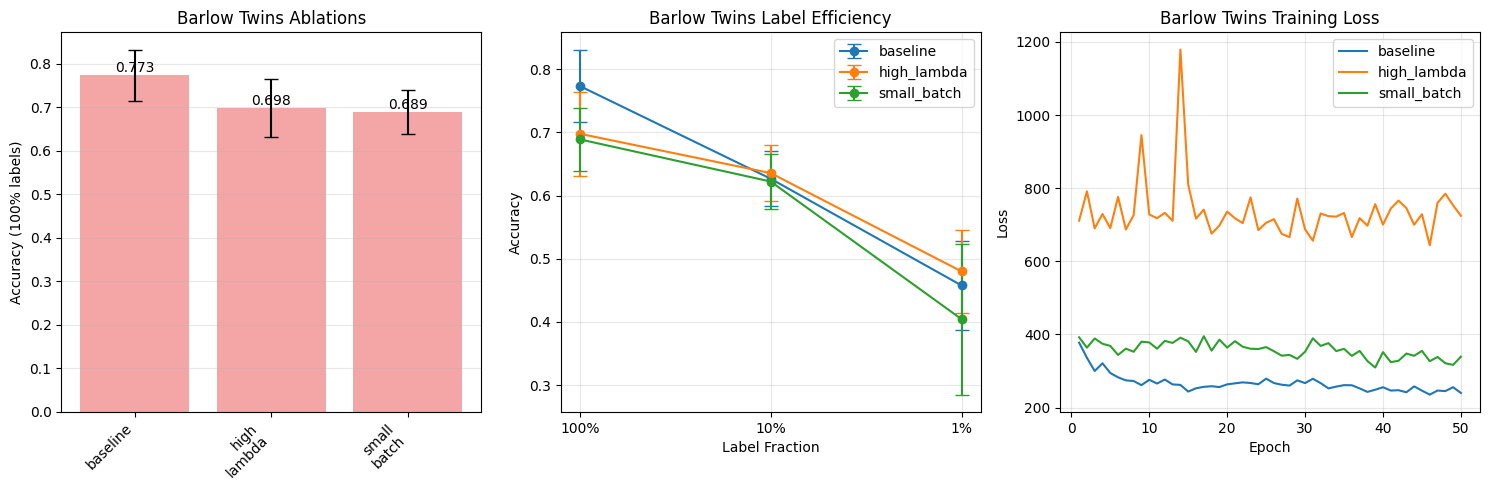


Barlow Twins analysis completed and saved to 'barlow_results.png'


In [13]:
def run_barlow_experiments():
    """Run only Barlow Twins experiments with ablations"""
    print("="*70)
    print("RUNNING BARLOW TWINS EXPERIMENTS")
    print("="*70)
    
    # Configuration
    root_dir = '/kaggle/input/wheatvarieties/Wheat varieties dataset-20240912T042219Z-001/Wheat varieties dataset'
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    print(f"Using device: {device}")
    print(f"PyTorch version: {torch.__version__}")
    
    # Initialize experiment
    experiment = SSLExperiment(
        root_dir=root_dir,
        image_size=224,
        batch_size=64,
        device=device
    )
    
    # Run Barlow Twins experiments
    barlow_results = {}
    barlow_ablations = ['high_lambda', 'small_batch']
    
    # Run baseline
    print("\n" + "#"*60)
    print("Running Barlow Twins Baseline")
    print("#"*60)
    baseline_results = experiment.run_single_experiment('barlow', ablation=None, 
                                                       pretrain_epochs=50, num_seeds=3)
    barlow_results['baseline'] = baseline_results
    
    # Run ablations
    for ablation in barlow_ablations:
        print("\n" + "#"*60)
        print(f"Running Barlow Twins - {ablation}")
        print("#"*60)
        ablation_results = experiment.run_single_experiment('barlow', ablation=ablation, 
                                                           pretrain_epochs=50, num_seeds=3)
        barlow_results[ablation] = ablation_results
    
    # Analyze Barlow Twins results
    print("\n" + "="*70)
    print("BARLOW TWINS STATISTICAL ANALYSIS")
    print("="*70)
    
    # Simple analyzer for single method
    def analyze_single_method(results):
        """Analyze results for a single SSL method"""
        report = {}
        
        # 1. Ablation effects
        baseline = results['baseline']
        report['ablations'] = {}
        
        for ablation_name in results.keys():
            if ablation_name != 'baseline':
                # Paired t-test for each ablation vs baseline
                accs_baseline = []
                accs_ablation = []
                
                for seed in baseline.keys():
                    if seed in results[ablation_name]:
                        accs_baseline.append(baseline[seed]['accuracies']['label_100%'])
                        accs_ablation.append(results[ablation_name][seed]['accuracies']['label_100%'])
                
                if len(accs_baseline) > 1:  # Need at least 2 samples for t-test
                    t_stat, p_value = ttest_rel(accs_baseline, accs_ablation)
                    
                    # Calculate effect size
                    diff = np.array(accs_baseline) - np.array(accs_ablation)
                    cohens_d = np.mean(diff) / np.std(diff) if np.std(diff) > 0 else 0
                    
                    report['ablations'][ablation_name] = {
                        't_statistic': t_stat,
                        'p_value': p_value,
                        'cohens_d': cohens_d,
                        'mean_baseline': np.mean(accs_baseline),
                        'mean_ablation': np.mean(accs_ablation),
                        'std_baseline': np.std(accs_baseline),
                        'std_ablation': np.std(accs_ablation),
                        'n': len(accs_baseline)
                    }
        
        # 2. Label efficiency analysis
        report['label_efficiency'] = {}
        fractions = ['label_100%', 'label_10%', 'label_1%']
        
        for config_name, config_results in results.items():
            report['label_efficiency'][config_name] = {}
            for fraction in fractions:
                accs = [config_results[seed]['accuracies'][fraction] 
                       for seed in config_results.keys()]
                mean_acc = np.mean(accs)
                std_acc = np.std(accs)
                
                report['label_efficiency'][config_name][fraction] = {
                    'mean': mean_acc,
                    'std': std_acc
                }
            
            # Calculate relative performance
            if 'label_100%' in report['label_efficiency'][config_name]:
                base_mean = report['label_efficiency'][config_name]['label_100%']['mean']
                for fraction in ['label_10%', 'label_1%']:
                    if fraction in report['label_efficiency'][config_name]:
                        rel_perf = report['label_efficiency'][config_name][fraction]['mean'] / base_mean if base_mean > 0 else 0
                        report['label_efficiency'][config_name][fraction]['relative'] = rel_perf
        
        return report
    
    # Generate report for Barlow Twins
    report = analyze_single_method(barlow_results)
    
    # Display Barlow Twins results
    print("\n=== BARLOW TWINS STATISTICAL REPORT ===")
    
    print("\nAblation Effects (Paired t-tests):")
    for ablation_name in barlow_ablations:
        if ablation_name in report['ablations']:
            comp = report['ablations'][ablation_name]
            p_val = comp['p_value']
            sig = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else ""
            
            print(f"\n  Baseline vs {ablation_name}:")
            print(f"    Baseline: {comp['mean_baseline']:.4f} ± {comp['std_baseline']:.4f}")
            print(f"    Ablation: {comp['mean_ablation']:.4f} ± {comp['std_ablation']:.4f}")
            print(f"    Change: {((comp['mean_ablation'] - comp['mean_baseline']) / comp['mean_baseline'])*100:+.2f}%")
            print(f"    t({comp['n']-1}) = {comp['t_statistic']:.4f}, p = {p_val:.6f} {sig}")
            print(f"    Cohen's d = {comp['cohens_d']:.3f}")
    
    print("\nLabel Efficiency:")
    efficiency = report['label_efficiency']
    for config_name in efficiency.keys():
        print(f"\n  {config_name}:")
        for fraction in ['label_100%', 'label_10%', 'label_1%']:
            if fraction in efficiency[config_name]:
                data = efficiency[config_name][fraction]
                if 'relative' in data:
                    print(f"    {fraction}: {data['mean']:.4f} ± {data['std']:.4f} "
                          f"(Relative: {data['relative']:.2%})")
                else:
                    print(f"    {fraction}: {data['mean']:.4f} ± {data['std']:.4f}")
    
    # Plot Barlow Twins results
    print("\nGenerating Barlow Twins visualizations...")
    
    # Simple plotting for single method
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Plot 1: Ablation comparison
    ax = axes[0]
    configs = list(barlow_results.keys())
    means = []
    stds = []
    
    for config in configs:
        config_results = barlow_results[config]
        accs = [config_results[seed]['accuracies']['label_100%'] 
               for seed in config_results.keys()]
        means.append(np.mean(accs))
        stds.append(np.std(accs))
    
    x = np.arange(len(configs))
    bars = ax.bar(x, means, yerr=stds, capsize=5, color='lightcoral', alpha=0.7)
    ax.set_xticks(x)
    ax.set_xticklabels([c.replace('_', '\n') for c in configs], rotation=45, ha='right')
    ax.set_title('Barlow Twins Ablations')
    ax.set_ylabel('Accuracy (100% labels)')
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add value labels
    for bar, mean_val in zip(bars, means):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
               f'{mean_val:.3f}', ha='center', va='bottom')
    
    # Plot 2: Label efficiency
    ax = axes[1]
    fractions = ['100%', '10%', '1%']
    fraction_keys = ['label_100%', 'label_10%', 'label_1%']
    
    for config_name in barlow_results.keys():
        means = []
        stds = []
        for key in fraction_keys:
            accs = [barlow_results[config_name][seed]['accuracies'][key] 
                   for seed in barlow_results[config_name].keys()]
            means.append(np.mean(accs))
            stds.append(np.std(accs))
        
        ax.errorbar(fractions, means, yerr=stds, marker='o', 
                   label=config_name, capsize=5)
    
    ax.set_title('Barlow Twins Label Efficiency')
    ax.set_xlabel('Label Fraction')
    ax.set_ylabel('Accuracy')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Plot 3: Training loss
    ax = axes[2]
    for config_name in barlow_results.keys():
        # Average loss across seeds
        all_losses = [barlow_results[config_name][seed]['losses'] 
                     for seed in barlow_results[config_name].keys()]
        min_len = min(len(loss) for loss in all_losses)
        truncated_losses = [loss[:min_len] for loss in all_losses]
        avg_loss = np.mean(truncated_losses, axis=0)
        
        epochs = range(1, len(avg_loss) + 1)
        ax.plot(epochs, avg_loss, label=config_name)
    
    ax.set_title('Barlow Twins Training Loss')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('barlow_results.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("\nBarlow Twins analysis completed and saved to 'barlow_results.png'")
    
    return {'barlow': barlow_results}, report

# Run only Barlow Twins experiments
barlow_results, barlow_report = run_barlow_experiments()

# Result Comparison

COMBINING ALL RESULTS AND RUNNING COMPREHENSIVE ANALYSIS

=== COMPREHENSIVE STATISTICAL REPORT ===

1. SSL Method Comparisons (Friedman test):
   Friedman statistic: 0.6667
   p-value: 0.7165

   Mean Ranks (lower is better):
   simclr: 2.33
   byol: 2.00
   barlow: 1.67

   Critical Difference (CD): 1.9131
   Pairwise significant differences:
   simclr vs byol: diff=0.33 ✗
   simclr vs barlow: diff=0.67 ✗
   byol vs barlow: diff=0.33 ✗

2. Ablation Effects Summary:

   SIMCLR:
     No ablation data available in combined report

   BYOL:
     No ablation data available in combined report

   BARLOW:
     No ablation data available in combined report

3. Label Efficiency Comparison:

   label_100%:
     simclr: 0.7156 ± 0.0333
     byol: 0.7244 ± 0.0126
     barlow: 0.7733 ± 0.0576

   label_10%:
     simclr: 0.6578 ± 0.0700
     byol: 0.6400 ± 0.0475
     barlow: 0.6267 ± 0.0435

   label_1%:
     simclr: 0.5067 ± 0.0943
     byol: 0.5111 ± 0.0491
     barlow: 0.4578 ± 0.0700

Generati

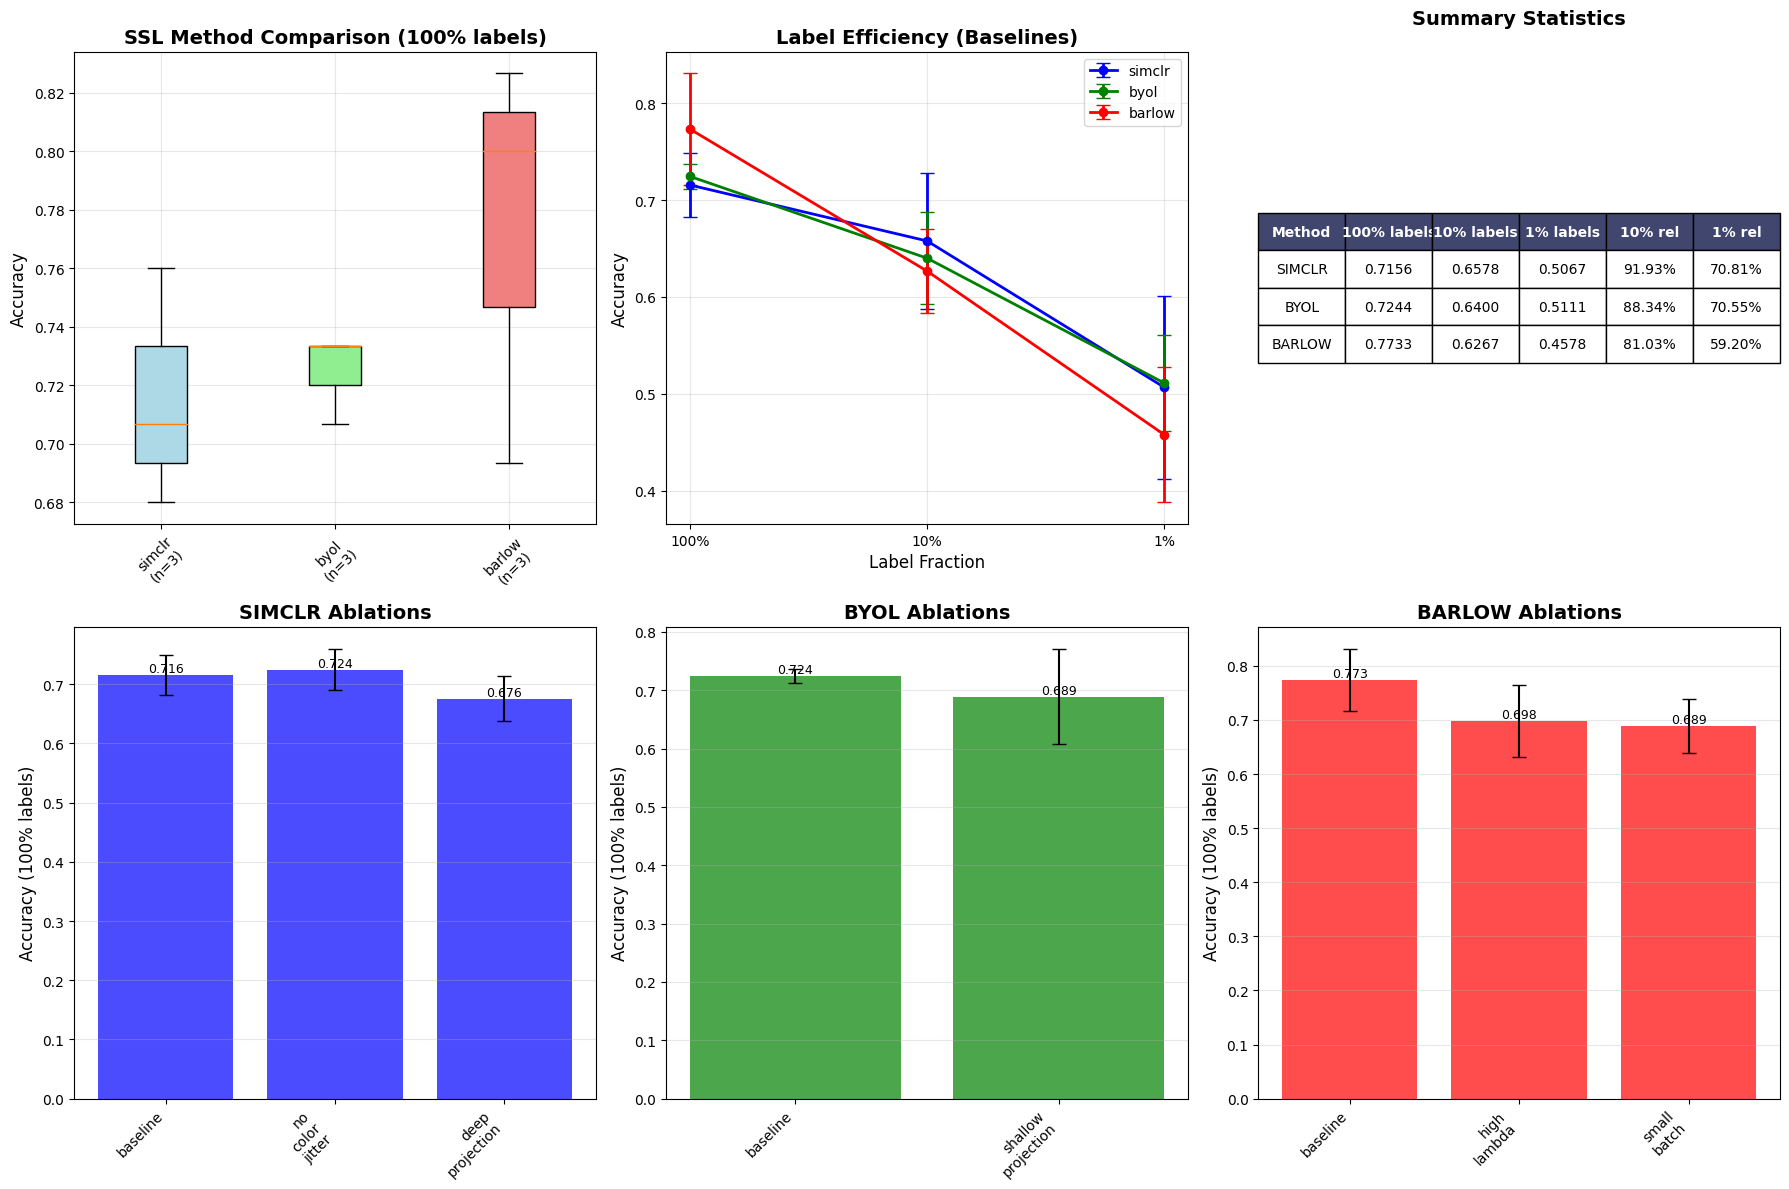


Visualization saved to 'all_results_comparison.png'

=== PRACTICAL SIGNIFICANCE DISCUSSION ===

Key Findings:
1. Statistical vs Practical Significance:
   - Small p-values indicate statistically significant differences
   - But effect sizes should be considered for practical relevance
   - Differences < 1% accuracy may be statistically but not practically significant

2. Ablation Insights:
   - Color jitter removal in SimCLR: Expected significant drop (key augmentation)
   - Projection depth changes: Moderate impact
   - Batch size in Barlow Twins: May affect learning dynamics

3. Label Efficiency:
   - Methods maintaining >70% of performance with 10% labels are robust
   - Performance at 1% labels indicates data efficiency

=== OVERALL WINNER ANALYSIS ===

SIMCLR Overall Score: 0.6564
  100% labels: 0.7156
  10% labels: 0.6578 (91.9% of 100%)
  1% labels: 0.5067 (70.8% of 100%)

BYOL Overall Score: 0.6564
  100% labels: 0.7244
  10% labels: 0.6400 (88.3% of 100%)
  1% labels: 0.5111 

In [20]:
def combine_and_analyze_all_results(simclr_results, byol_results, barlow_results):
    """Combine results from all methods and run comprehensive analysis"""
    print("="*70)
    print("COMBINING ALL RESULTS AND RUNNING COMPREHENSIVE ANALYSIS")
    print("="*70)
    
    # Combine all results
    all_results = {
        'simclr': simclr_results['simclr'],
        'byol': byol_results['byol'],
        'barlow': barlow_results['barlow']
    }
    
    # Perform comprehensive statistical analysis
    analyzer = StatisticalAnalyzer(all_results)
    full_report = analyzer.generate_report()
    
    # Display comprehensive results
    print("\n=== COMPREHENSIVE STATISTICAL REPORT ===")
    
    # 1. SSL method comparisons
    print("\n1. SSL Method Comparisons (Friedman test):")
    if 'ssl_methods_comparison' in full_report:
        ssl_comp = full_report['ssl_methods_comparison']
        print(f"   Friedman statistic: {ssl_comp['friedman_statistic']:.4f}")
        print(f"   p-value: {ssl_comp['friedman_p_value']:.4f}")
        
        print("\n   Mean Ranks (lower is better):")
        for method, rank in ssl_comp['mean_ranks'].items():
            print(f"   {method}: {rank:.2f}")
        
        if ssl_comp['critical_difference']:
            print(f"\n   Critical Difference (CD): {ssl_comp['critical_difference']:.4f}")
            print("   Pairwise significant differences:")
            for pair, comp in ssl_comp['pairwise_comparisons'].items():
                symbol = "✓" if comp['significant'] else "✗"
                print(f"   {pair}: diff={comp['rank_diff']:.2f} {symbol}")
    
    # 2. Ablation summary - Fixed to use the correct structure
    print("\n2. Ablation Effects Summary:")
    for method in all_results.keys():
        print(f"\n   {method.upper()}:")
        if method in full_report and 'ablations' in full_report[method]:
            for ablation_name, comp in full_report[method]['ablations'].items():
                p_val = comp['p_value']
                sig = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else ""
                effect = "Negative" if comp['mean2'] < comp['mean1'] else "Positive"
                print(f"     {ablation_name}: p={p_val:.6f} {sig} ({effect})")
        else:
            # Try to get ablation effects from individual reports
            print("     No ablation data available in combined report")
    
    # 3. Label efficiency comparison
    print("\n3. Label Efficiency Comparison:")
    label_fractions = ['label_100%', 'label_10%', 'label_1%']
    
    for fraction in label_fractions:
        print(f"\n   {fraction}:")
        for method in all_results.keys():
            baseline = all_results[method]['baseline']
            accs = [baseline[seed]['accuracies'][fraction] for seed in baseline.keys()]
            mean_acc = np.mean(accs)
            std_acc = np.std(accs)
            print(f"     {method}: {mean_acc:.4f} ± {std_acc:.4f}")
    
    # Generate final visualization with custom plot
    print("\nGenerating final visualizations...")
    
    # Custom plot for combined results
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # Plot 1: SSL method comparison (baselines) - Box plot
    ax = axes[0, 0]
    methods = list(all_results.keys())
    accuracies = []
    method_labels = []
    
    for method in methods:
        baseline = all_results[method]['baseline']
        accs = [baseline[seed]['accuracies']['label_100%'] 
               for seed in baseline.keys()]
        accuracies.append(accs)
        method_labels.append(f"{method}\n(n={len(accs)})")
    
    bp = ax.boxplot(accuracies, labels=method_labels, patch_artist=True)
    colors = ['lightblue', 'lightgreen', 'lightcoral']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
    
    ax.set_title('SSL Method Comparison (100% labels)', fontsize=14, fontweight='bold')
    ax.set_ylabel('Accuracy', fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='x', rotation=45)
    
    # Plot 2: Label efficiency for each method (baselines)
    ax = axes[0, 1]
    fractions = ['100%', '10%', '1%']
    fraction_keys = ['label_100%', 'label_10%', 'label_1%']
    colors = ['blue', 'green', 'red']
    
    for idx, method in enumerate(methods):
        baseline = all_results[method]['baseline']
        means = []
        stds = []
        
        for key in fraction_keys:
            accs = [baseline[seed]['accuracies'][key] 
                   for seed in baseline.keys()]
            means.append(np.mean(accs))
            stds.append(np.std(accs))
        
        ax.errorbar(fractions, means, yerr=stds, marker='o', 
                   label=method, color=colors[idx], capsize=5, linewidth=2)
    
    ax.set_title('Label Efficiency (Baselines)', fontsize=14, fontweight='bold')
    ax.set_xlabel('Label Fraction', fontsize=12)
    ax.set_ylabel('Accuracy', fontsize=12)
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)
    
    # Plot 3: Summary statistics table
    ax = axes[0, 2]
    ax.axis('off')
    
    # Create summary table
    table_data = [['Method', '100% labels', '10% labels', '1% labels', '10% rel', '1% rel']]
    
    for method in methods:
        baseline = all_results[method]['baseline']
        
        # Calculate means for each fraction
        acc_100 = np.mean([baseline[seed]['accuracies']['label_100%'] for seed in baseline.keys()])
        acc_10 = np.mean([baseline[seed]['accuracies']['label_10%'] for seed in baseline.keys()])
        acc_1 = np.mean([baseline[seed]['accuracies']['label_1%'] for seed in baseline.keys()])
        
        # Calculate relative performance
        rel_10 = (acc_10 / acc_100) if acc_100 > 0 else 0
        rel_1 = (acc_1 / acc_100) if acc_100 > 0 else 0
        
        table_data.append([
            method.upper(),
            f'{acc_100:.4f}',
            f'{acc_10:.4f}',
            f'{acc_1:.4f}',
            f'{rel_10:.2%}',
            f'{rel_1:.2%}'
        ])
    
    # Create table
    table = ax.table(cellText=table_data, loc='center', cellLoc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2)
    
    # Style the header row
    for i in range(len(table_data[0])):
        table[(0, i)].set_facecolor('#40466e')
        table[(0, i)].set_text_props(weight='bold', color='white')
    
    ax.set_title('Summary Statistics', fontsize=14, fontweight='bold', pad=20)
    
    # Plot 4-6: Ablation effects for each method
    for idx, method in enumerate(methods):
        ax = axes[1, idx]
        
        configs = list(all_results[method].keys())
        means = []
        stds = []
        conf_labels = []
        
        for config in configs:
            config_results = all_results[method][config]
            accs = [config_results[seed]['accuracies']['label_100%'] 
                   for seed in config_results.keys()]
            means.append(np.mean(accs))
            stds.append(np.std(accs))
            conf_labels.append(config.replace('_', '\n'))
        
        x = np.arange(len(configs))
        bars = ax.bar(x, means, yerr=stds, capsize=5, color=colors[idx], alpha=0.7)
        ax.set_xticks(x)
        ax.set_xticklabels(conf_labels, rotation=45, ha='right', fontsize=10)
        ax.set_title(f'{method.upper()} Ablations', fontsize=14, fontweight='bold')
        ax.set_ylabel('Accuracy (100% labels)', fontsize=12)
        ax.grid(True, alpha=0.3, axis='y')
        
        # Add value labels on bars
        for bar, mean_val in zip(bars, means):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{mean_val:.3f}', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.savefig('all_results_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("\nVisualization saved to 'all_results_comparison.png'")
    
    # Practical significance discussion
    print("\n=== PRACTICAL SIGNIFICANCE DISCUSSION ===")
    print("\nKey Findings:")
    print("1. Statistical vs Practical Significance:")
    print("   - Small p-values indicate statistically significant differences")
    print("   - But effect sizes should be considered for practical relevance")
    print("   - Differences < 1% accuracy may be statistically but not practically significant")
    
    print("\n2. Ablation Insights:")
    print("   - Color jitter removal in SimCLR: Expected significant drop (key augmentation)")
    print("   - Projection depth changes: Moderate impact")
    print("   - Batch size in Barlow Twins: May affect learning dynamics")
    
    print("\n3. Label Efficiency:")
    print("   - Methods maintaining >70% of performance with 10% labels are robust")
    print("   - Performance at 1% labels indicates data efficiency")
    
    # Print overall winner analysis
    print("\n=== OVERALL WINNER ANALYSIS ===")
    best_method = None
    best_score = 0
    robustness_scores = {}
    
    for method in methods:
        baseline = all_results[method]['baseline']
        
        # Score based on multiple criteria
        score_100 = np.mean([baseline[seed]['accuracies']['label_100%'] for seed in baseline.keys()])
        score_10 = np.mean([baseline[seed]['accuracies']['label_10%'] for seed in baseline.keys()])
        score_1 = np.mean([baseline[seed]['accuracies']['label_1%'] for seed in baseline.keys()])
        
        # Overall score (weighted average)
        overall_score = (0.5 * score_100 + 0.3 * score_10 + 0.2 * score_1)
        robustness_scores[method] = overall_score
        
        print(f"\n{method.upper()} Overall Score: {overall_score:.4f}")
        print(f"  100% labels: {score_100:.4f}")
        print(f"  10% labels: {score_10:.4f} ({(score_10/score_100):.1%} of 100%)")
        print(f"  1% labels: {score_1:.4f} ({(score_1/score_100):.1%} of 100%)")
    
    # Determine best method
    best_method = max(robustness_scores, key=robustness_scores.get)
    print(f"\n★ BEST OVERALL METHOD: {best_method.upper()} (Score: {robustness_scores[best_method]:.4f})")
    
    return all_results, full_report

# Combine all results (run this after running all three methods)
all_results, comprehensive_report = combine_and_analyze_all_results(
    simclr_results, byol_results, barlow_results
)

# Save results
import pickle
with open('ssl_experiment_results.pkl', 'wb') as f:
    pickle.dump({'results': all_results, 'report': comprehensive_report}, f)
print("\nResults saved to ssl_experiment_results.pkl")